<a href="https://colab.research.google.com/drive/1Xbx2His-wm_2TQqGeeARoocS38ERLzGw?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning SP 2022/2023

- Prof. Cesare Alippi
- Giorgia Adorni ([`giorgia.adorni@usi.ch`](mailto:giorgia.adorni@usi.ch))<br>
- Fatima Ezzeddine ([`fatima.ezzeddine@usi.ch`](mailto:fatima.ezzeddine@usi.ch))<br>
- Alessandro Manenti ([`alessandro.manenti@usi.ch`](mailto:alessandro.manenti@usi.ch))

---
# Lab 04: Feedforward Neural networks


Also known as __multilayer perceptrons__ , neural networks are computational models inspired by the connected structure of the brain. The core component of neural networks is the neuron, which is composed of a perceptron and an activation function: 

$$
f(x; \boldsymbol \theta) =  h( x^T \boldsymbol \theta).
$$

The main idea behind neural networks is to compose neurons in two different ways: 

1. by taking many neurons __in parallel__;
2. by composing many subsequent __layers__ of neurons;

The result is a network of neurons that take data as input, and compute sequential transformations until the desired result is produced as output.

![alt text](https://res.cloudinary.com/practicaldev/image/fetch/s--4XiAvCCB--/c_limit%2Cf_auto%2Cfl_progressive%2Cq_auto%2Cw_880/https://cdn-images-1.medium.com/max/1200/1%2AYgJ6SYO7byjfCmt5uV0PmA.png)

---

We can write the output of the hidden layer as:

$$
\begin{bmatrix} 
h_0 \\
h_1 \\
h_2 \\
\vdots\\
h_l 
\end{bmatrix}
=
h\left(
\begin{bmatrix} 
w_{00} & w_{01} & w_{02} & \cdots & w_{0m} \\
w_{10} & w_{11} & w_{12} & \cdots & w_{1m} \\
w_{20} & w_{21} & w_{22} & \cdots & w_{2m} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
w_{l0} & w_{l1} & w_{l2} & \cdots & w_{lm} \\
\end{bmatrix}
\begin{bmatrix} 
x_0 \\
x_1 \\
x_2 \\
\vdots\\
x_m
\end{bmatrix}
+
\begin{bmatrix} 
b_0 \\
b_1 \\
b_2 \\
\vdots\\
b_l
\end{bmatrix}
\right)
$$

In short, we write the output of a __layer__ of neurons as:
$$
H = h(Wx + b_w)
$$

_NB: without the activation function a layer is a simple affine trasformation._

We can compute the output of the network doing the same calculation for the  "Output" neurons, with the difference that their input is not $X$, as for the hidden neurons, but it is the output $H$ of the last hidden layer. The output layer can be written as: 

$$
Y = \sigma(VH + b_v)
$$

(note that $V$ is a different matrix of parameters).

Finally, stacking the two layers simply means __composing__ them together, so that the whole neural network can be written as: 

$$
\hat y = f(x;\boldsymbol \theta = \{W, b_w, V, b_v\}) = \sigma\left(V h(Wx + b_w)  + b_v\right)
$$

---
Neural networks are trained with __stochastic gradient descent__ (SGD). The key idea behind SGD is to update all the parameters of the network at the same time, based on how each parameter contributed to the __loss__ function $L( \boldsymbol \theta)$. 

The generalized update rule reads: 

$$
{\boldsymbol \theta}^{i+1} = {\boldsymbol \theta}^{i} - \varepsilon \frac{\partial L({\boldsymbol \theta})}{\partial {\boldsymbol \theta}}\bigg\vert_{{\boldsymbol \theta} = {\boldsymbol \theta}^i}
$$

where $\varepsilon$ is again called __learning rate__.

---

When training neural networks for binary classification, we take the loss to be the __cross-entropy error function__: 

$$
L({\boldsymbol \theta}) =  -\frac1n \sum_{i=1}^n \bigg[y_i  \log \hat y_i + (1 - y_i)  \log (1 - \hat y_i)\bigg]
$$


# Neural networks in Python

To build our neural network we will use [TensorFlow](https://www.tensorflow.org/), one of the most popular deep learning libraries for Python (the other being [PyTorch](https://pytorch.org/)). 
TensorFlow provides a huge number of functions, like Numpy, that can be used to manipulate arrays, but offers two great advantages w.r.t. Numpy: 

1. the computation can be accelerated on GPU via the CUDA library;
2. the library implements __automatic differentiation__, meaning that the most analytically complex step of training, the computation of the gradient, is handled for you.

While TensorFlow is a very powerful library that offers a fine-coarsened control over what you build, for this course we will skip the low level details and instead use the official high-level API for TensorFlow: [Keras](https://keras.io).

## Introduction to Keras

![alt text](https://s3.amazonaws.com/keras.io/img/keras-logo-2018-large-1200.png)



Keras offers collections of TF operations already arranged to implement neural networks with little to no effort. 
For instance, building a layer of 4 neurons like the one we saw above is as easy as calling `Dense(4)`. That's it. 

Moreover, Keras offers a high-level API for doing all the usual steps that we usually do when training a neural network, like training on some data, evaluating the performance, and predicting on unseen data. 

The core data structure of Keras is a model, a way to organize layers. The simplest type of model is the `Sequential` model, a linear stack of layers.

---

Let's start with a toy classification problem.

In [ ]:
import numpy as np
from sklearn.datasets import make_classification, make_circles, make_moons
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# color_maps
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF']) 

# function to generate classification problems
def get_data(n, ctype='simple'):
  if ctype == 'simple':
    x, y = make_classification(n_features=2, 
                               n_redundant=0, 
                               n_informative=2, 
                               n_clusters_per_class=1)
    x += np.random.uniform(size=x.shape) # add some noise
  elif ctype == 'circles':
    x, y = make_circles(n, noise=0.1, factor=0.5)
  
  elif ctype == 'moons':
    x, y = make_moons(n, noise=0.1)
  else:
    raise ValueError
  return x, y.reshape(-1, 1)

# function to plot decision boundaries
def plot_decision_surface(model, x, y, transform=lambda x:x):    
  #init figure
  fig = plt.figure()

  # Create mesh
  h = .01  # step size in the mesh
  x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
  y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

  # plot train data
  plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cm_bright,
              edgecolors='k')
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

  plt.xlabel(r'$x_1$')
  plt.ylabel(r'$x_2$');

  y_pred = model.predict(transform(np.c_[xx.ravel(), yy.ravel()]))

  y_pred = y_pred.reshape(xx.shape)
  plt.contourf(xx, yy, y_pred > 0.5, cmap=cm, alpha=.5)

Let's go back to the problem that we saw in the previous part.

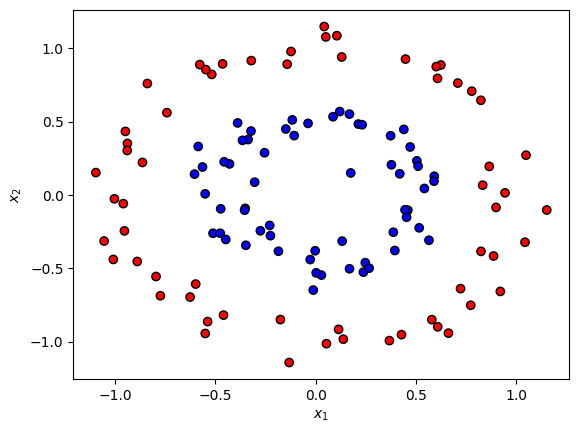

In [ ]:
np.random.seed(20)

# Create a classification problem
x, y = get_data(120, 'circles')

# Let's look at the data
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cm_bright, edgecolors='k')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$');

Now let's build a neural network to fit the data.

Using Keras, this will take only a few lines of code.

3362/3362 [==============================] - 4s 1ms/step


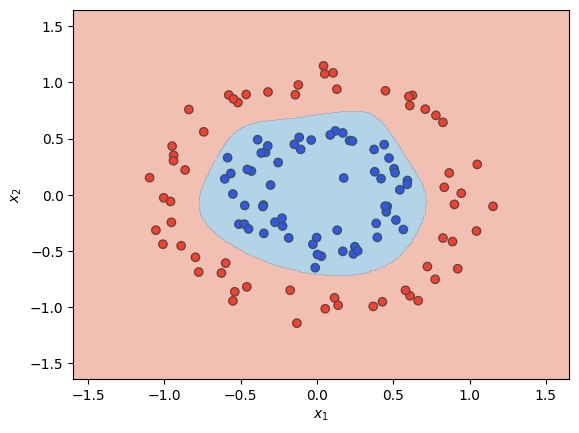

In [ ]:
from keras import Input, Model
from keras.models import Sequential
from keras.layers import Dense
from keras import losses
from tensorflow import keras
from keras.callbacks import EarlyStopping
import tensorflow as tf

tf.random.set_seed(25) # this makes the experiment easy to reproduce

# Define the network
classifier = Sequential()
classifier.add(Dense(8, activation='tanh', input_shape=(x.shape[1],)))
classifier.add(Dense(1, activation='sigmoid'))

# Set up the model for training
classifier.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.025), # choose optimizer and learning rate
                   loss=losses.BinaryCrossentropy(),                        # define loss function 
                   metrics=['accuracy']                                     # define metric to monitor during training
                  )

# Evaluate the performance
classifier.fit(x, y, epochs=100, verbose=0)
plot_decision_surface(classifier, x, y)

Let's try to understand why this is working adding another hidden layer with 2 units to visualize the space in which a neural network projects the data.

In [ ]:
def compute_boundary(out_layer):
  w = np.asarray(out_layer.weights[0]).ravel()
  b = np.asarray(out_layer.bias).ravel()
  theta = np.r_[b, w].ravel()
  b = -theta[0]/theta[2]
  m = -theta[1]/theta[2]

  x1 = np.array([x[:,0].min(), x[:,0].max()])
  x2 = b + m * x1
  return x1, x2



def plot_training_iterations(classifier, features, out_layer, iterations=200):
  from IPython import display

  phi = features.predict(x)
  xd, yd = compute_boundary(out_layer)


  #init figure
  fig = plt.figure()
  ax = fig.gca()
  #fixed plots
  ax.scatter(x[:, 0], x[:, 1], c=y, cmap=cm_bright, edgecolors='k', alpha=0.05)
  splt = ax.scatter(phi[:, 0], phi[:, 1], c=y, cmap=cm_bright, edgecolors='k')
  line = ax.plot(xd, yd, color='black')[0]
  ax.set_xlabel(r'$\phi_1$')
  ax.set_ylabel(r'$\phi_2$')
  ax.set_xlim([-1.3, 1.3])
  ax.set_ylim([-1.3, 1.3])
  display.display(plt.gcf(), display_id=40)

  n = iterations
  e = 10
  for i in range(n):
    hist = classifier.fit(x, y, epochs=e, verbose=0)
    phi = features.predict(x)
    _, yd = compute_boundary(out_layer)
    ax.set_title(f"Iteration {(i+1)*e}/{e*n} | Train accuracy: {hist.history['accuracy'][-1]:.2f}")
    # update plot
    splt.set_offsets(phi)
    line.set_ydata(yd)
    display.clear_output(wait=True)
    #display.update_display(plt.gcf(), display_id=40)
    display.display(plt.gcf(), display_id=40)

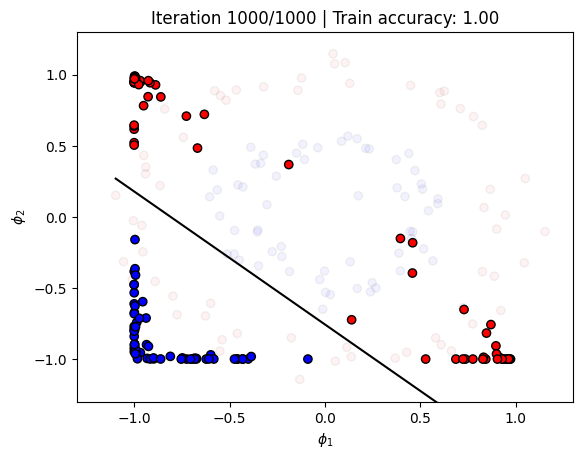

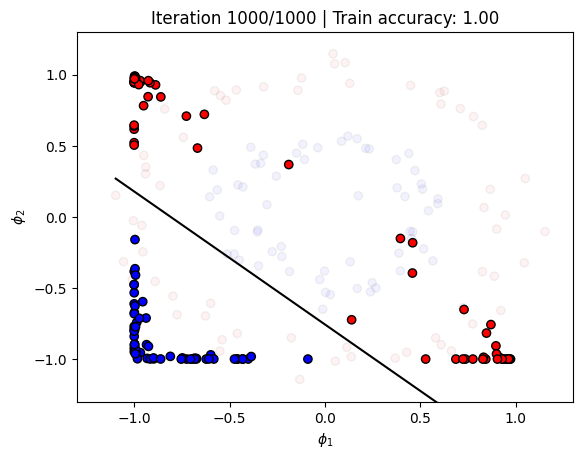

In [ ]:
tf.random.set_seed(25)
# An alternative way to define a network in keras as a sequence of operations

inp = Input((x.shape[1],)) # inpute layer
hidden1 = Dense(8, activation='tanh')(inp) # first nonlinear transormation
hidden2 = Dense(2, activation='tanh')(hidden1) # second nonlinear transformation

out_layer = Dense(1, activation='sigmoid')
out = out_layer(hidden2) # output layer

# define the model using the input and output layers
classifier = Model(inp, out)
classifier.compile(loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

features = Model(inp, hidden2)

plot_training_iterations(classifier, features, out_layer, iterations=100);

The data are linearly separable in the projected space!

If you go back and remove the nonlinear activation functions from the hidden layers, you'll see that this is not true anymore. In fact, without nonlinearities the hidden layers are simple affine transormations (e.g., can represent only linear mappings like rotation, translation, shear, ...).

_Homework: check [this](https://colah.github.io/posts/2014-03-NN-Manifolds-Topology/) insightful blog post from Chris Olah._

4/4 [==============================] - 0s 3ms/step


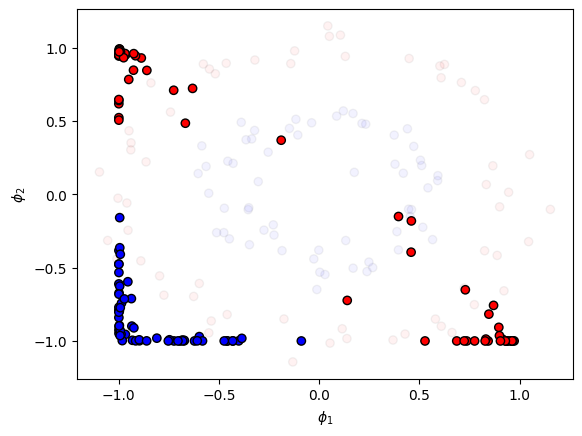

In [ ]:
features = Model(inp, hidden2)
phi = features.predict(x)

plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cm_bright, edgecolors='k', alpha=0.05)
plt.scatter(phi[:, 0], phi[:, 1], c=y, cmap=cm_bright, edgecolors='k')
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$');

# Wine quality dataset

Let's try with a real dataset now. 

We are given a set of wine reviews, with the following characteristics: 

In [ ]:
import pandas as pd

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(url, delimiter=';')

data.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


<Axes: >

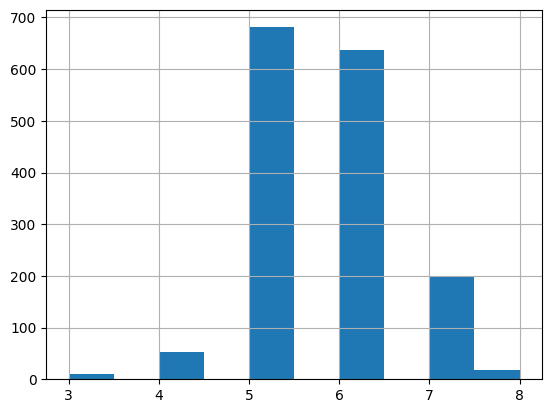

In [ ]:
# Let's look at the distribution of the reviews
data['quality'].hist(bins=10)

We can turn this into a binary classification problem by setting a threshold on the reviews: was the wine good (>= 6) or not?

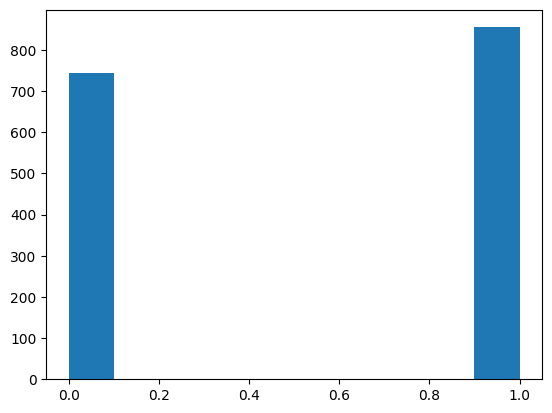

In [ ]:
# Extract features
X = data[data.columns[:-1]].values

# Extact targets
quality = data['quality'].values.astype(np.int32)
y = (quality >= 6).astype(np.int32)
plt.hist(y);

Notice how the values of the features are not commensurable with one another. For instance, "total sulfur dioxide" can have values up to 100, while the "density" is necessarily limited to be <= 1. 

While this in principle is not a problem for our machine learning models, in practice it can lead to issues in the training procedure.

To standardize the data, we compute the following transformation: 

$$
X_{\textrm{standardized}} = \frac{X - \textrm{mean}(X)}{\textrm{std}(X)}
$$

NB: here we are scaling the complete dataset at once for semplicity, but in reality you should use only training data to compute mean and std deviation. Do it in the proper way in the assignments :D

In [ ]:
# Normalize features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

In order to train our network, we will split the data into train and test set:

In [ ]:
from sklearn.model_selection import train_test_split

# Split train / test / validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

Let's also implement early stopping

<div style="text-align:center;">
    <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*nhmPdWSGh3ziatQKOmVq0Q.png" width="50%">
</div>

Now that we have loaded and pre-processed our data, we only need to build the neural network that we will train. 

In [ ]:
# Define the network
network = Sequential()
network.add(Dense(32, activation='relu', input_shape=X.shape[1:]))
network.add(Dense(1, activation='sigmoid'))

# Prepare the computational graph and training operations
network.compile(optimizer='sgd', 
                loss='binary_crossentropy', 
                metrics=['acc'])

# we would seek a minimum for validation loss, whereas we would seek a maximum for validation accuracy
es = EarlyStopping(monitor='///////////////////////////', mode='min', patience=10, verbose= 1)

# Train the network
history = network.fit(X_train, y_train, epochs=1000, callbacks = [es], validation_data=(X_val, y_val))

# Evaluate the performance
eval_results = network.evaluate(X_test, y_test)
print('Test loss: {} - Test acc: {}'.format(*eval_results))

Epoch 1/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.6607 - acc: 0.6310 

41/41 [==============================] - 1s 7ms/step - loss: 0.6602 - acc: 0.6278 - val_loss: 0.6690 - val_acc: 0.6111
Epoch 2/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.6239 - acc: 0.6552

41/41 [==============================] - 0s 3ms/step - loss: 0.6139 - acc: 0.6625 - val_loss: 0.6284 - val_acc: 0.6319
Epoch 3/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.5884 - acc: 0.6948

41/41 [==============================] - 0s 3ms/step - loss: 0.5864 - acc: 0.6942 - val_loss: 0.6020 - val_acc: 0.6528
Epoch 4/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.5693 - acc: 0.7167

41/41 [==============================] - 0s 3ms/step - loss: 0.5683 - acc: 0.7135 - val_loss: 0.5854 - val_acc: 0.7014
Epoch 5/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.5627 - acc: 0.7197

41/41 [==============================] - 0s 3ms/step - loss: 0.5562 - acc: 0.7205 - val_loss: 0.5731 - val_acc: 0.7083
Epoch 6/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.5360 - acc: 0.7467

41/41 [==============================] - 0s 3ms/step - loss: 0.5468 - acc: 0.7274 - val_loss: 0.5642 - val_acc: 0.7292
Epoch 7/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.5373 - acc: 0.7319

41/41 [==============================] - 0s 3ms/step - loss: 0.5399 - acc: 0.7313 - val_loss: 0.5573 - val_acc: 0.7500
Epoch 8/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.5358 - acc: 0.7278

41/41 [==============================] - 0s 3ms/step - loss: 0.5342 - acc: 0.7328 - val_loss: 0.5516 - val_acc: 0.7569
Epoch 9/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.5208 - acc: 0.7396

41/41 [==============================] - 0s 3ms/step - loss: 0.5295 - acc: 0.7367 - val_loss: 0.5469 - val_acc: 0.7639
Epoch 10/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.5260 - acc: 0.7415

41/41 [==============================] - 0s 3ms/step - loss: 0.5254 - acc: 0.7382 - val_loss: 0.5428 - val_acc: 0.7361
Epoch 11/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.5159 - acc: 0.7510

41/41 [==============================] - 0s 3ms/step - loss: 0.5221 - acc: 0.7436 - val_loss: 0.5394 - val_acc: 0.7431
Epoch 12/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.5131 - acc: 0.7470

41/41 [==============================] - 0s 3ms/step - loss: 0.5192 - acc: 0.7421 - val_loss: 0.5366 - val_acc: 0.7361
Epoch 13/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.5219 - acc: 0.7434

41/41 [==============================] - 0s 2ms/step - loss: 0.5167 - acc: 0.7452 - val_loss: 0.5344 - val_acc: 0.7361
Epoch 14/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.5179 - acc: 0.7453

41/41 [==============================] - 0s 3ms/step - loss: 0.5143 - acc: 0.7483 - val_loss: 0.5323 - val_acc: 0.7361
Epoch 15/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.5105 - acc: 0.7461

41/41 [==============================] - 0s 3ms/step - loss: 0.5123 - acc: 0.7459 - val_loss: 0.5308 - val_acc: 0.7361
Epoch 16/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.5096 - acc: 0.7409

41/41 [==============================] - 0s 3ms/step - loss: 0.5105 - acc: 0.7452 - val_loss: 0.5294 - val_acc: 0.7361
Epoch 17/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.5126 - acc: 0.7407

41/41 [==============================] - 0s 3ms/step - loss: 0.5090 - acc: 0.7467 - val_loss: 0.5283 - val_acc: 0.7431
Epoch 18/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.5014 - acc: 0.7539

41/41 [==============================] - 0s 3ms/step - loss: 0.5076 - acc: 0.7467 - val_loss: 0.5274 - val_acc: 0.7431
Epoch 19/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4888 - acc: 0.7489

41/41 [==============================] - 0s 3ms/step - loss: 0.5062 - acc: 0.7475 - val_loss: 0.5265 - val_acc: 0.7361
Epoch 20/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.5102 - acc: 0.7469

41/41 [==============================] - 0s 3ms/step - loss: 0.5051 - acc: 0.7483 - val_loss: 0.5257 - val_acc: 0.7361
Epoch 21/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4993 - acc: 0.7519

41/41 [==============================] - 0s 3ms/step - loss: 0.5039 - acc: 0.7490 - val_loss: 0.5250 - val_acc: 0.7361
Epoch 22/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.5142 - acc: 0.7434

41/41 [==============================] - 0s 3ms/step - loss: 0.5029 - acc: 0.7483 - val_loss: 0.5245 - val_acc: 0.7361
Epoch 23/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4970 - acc: 0.7528

41/41 [==============================] - 0s 3ms/step - loss: 0.5018 - acc: 0.7514 - val_loss: 0.5239 - val_acc: 0.7361
Epoch 24/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4998 - acc: 0.7471

41/41 [==============================] - 0s 3ms/step - loss: 0.5008 - acc: 0.7514 - val_loss: 0.5236 - val_acc: 0.7361
Epoch 25/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.5037 - acc: 0.7436

41/41 [==============================] - 0s 2ms/step - loss: 0.5000 - acc: 0.7490 - val_loss: 0.5234 - val_acc: 0.7292
Epoch 26/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4988 - acc: 0.7445

41/41 [==============================] - 0s 2ms/step - loss: 0.4991 - acc: 0.7490 - val_loss: 0.5230 - val_acc: 0.7292
Epoch 27/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4976 - acc: 0.7472

41/41 [==============================] - 0s 3ms/step - loss: 0.4983 - acc: 0.7514 - val_loss: 0.5230 - val_acc: 0.7222
Epoch 28/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4966 - acc: 0.7419

41/41 [==============================] - 0s 3ms/step - loss: 0.4975 - acc: 0.7506 - val_loss: 0.5229 - val_acc: 0.7222
Epoch 29/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4850 - acc: 0.7651

41/41 [==============================] - 0s 3ms/step - loss: 0.4967 - acc: 0.7514 - val_loss: 0.5227 - val_acc: 0.7222
Epoch 30/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4938 - acc: 0.7480

41/41 [==============================] - 0s 3ms/step - loss: 0.4960 - acc: 0.7514 - val_loss: 0.5225 - val_acc: 0.7222
Epoch 31/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.5035 - acc: 0.7443

41/41 [==============================] - 0s 3ms/step - loss: 0.4953 - acc: 0.7544 - val_loss: 0.5226 - val_acc: 0.7222
Epoch 32/1000
25/41 [=================>............] - ETA: 0s - loss: 0.5008 - acc: 0.7475

41/41 [==============================] - 0s 3ms/step - loss: 0.4947 - acc: 0.7560 - val_loss: 0.5222 - val_acc: 0.7222
Epoch 33/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4986 - acc: 0.7574

41/41 [==============================] - 0s 3ms/step - loss: 0.4939 - acc: 0.7575 - val_loss: 0.5223 - val_acc: 0.7292
Epoch 34/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4888 - acc: 0.7652

41/41 [==============================] - 0s 2ms/step - loss: 0.4934 - acc: 0.7591 - val_loss: 0.5224 - val_acc: 0.7222
Epoch 35/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4976 - acc: 0.7566

41/41 [==============================] - 0s 2ms/step - loss: 0.4925 - acc: 0.7591 - val_loss: 0.5225 - val_acc: 0.7222
Epoch 36/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4823 - acc: 0.7651

41/41 [==============================] - 0s 3ms/step - loss: 0.4919 - acc: 0.7606 - val_loss: 0.5225 - val_acc: 0.7222
Epoch 37/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4799 - acc: 0.7617

41/41 [==============================] - 0s 3ms/step - loss: 0.4915 - acc: 0.7583 - val_loss: 0.5227 - val_acc: 0.7222
Epoch 38/1000
24/41 [================>.............] - ETA: 0s - loss: 0.5069 - acc: 0.7487

41/41 [==============================] - 0s 3ms/step - loss: 0.4908 - acc: 0.7614 - val_loss: 0.5227 - val_acc: 0.7222
Epoch 39/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.5019 - acc: 0.7500

41/41 [==============================] - 0s 3ms/step - loss: 0.4902 - acc: 0.7622 - val_loss: 0.5229 - val_acc: 0.7222
Epoch 40/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4757 - acc: 0.7754

41/41 [==============================] - 0s 3ms/step - loss: 0.4896 - acc: 0.7629 - val_loss: 0.5232 - val_acc: 0.7222
Epoch 41/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4643 - acc: 0.7812

41/41 [==============================] - 0s 3ms/step - loss: 0.4891 - acc: 0.7637 - val_loss: 0.5233 - val_acc: 0.7292
Epoch 42/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4847 - acc: 0.7646

41/41 [==============================] - 0s 3ms/step - loss: 0.4886 - acc: 0.7637 - val_loss: 0.5234 - val_acc: 0.7292
Epoch 43/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4918 - acc: 0.7614

41/41 [==============================] - 0s 3ms/step - loss: 0.4881 - acc: 0.7629 - val_loss: 0.5237 - val_acc: 0.7222
Epoch 44/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4808 - acc: 0.7639

41/41 [==============================] - 0s 3ms/step - loss: 0.4875 - acc: 0.7653 - val_loss: 0.5237 - val_acc: 0.7222
Epoch 45/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4971 - acc: 0.7652

41/41 [==============================] - 0s 3ms/step - loss: 0.4871 - acc: 0.7668 - val_loss: 0.5236 - val_acc: 0.7222
Epoch 46/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4867 - acc: 0.7675

41/41 [==============================] - 0s 3ms/step - loss: 0.4865 - acc: 0.7668 - val_loss: 0.5234 - val_acc: 0.7222
Epoch 47/1000
35/41 [========================>.....] - ETA: 0s - loss: 0.4865 - acc: 0.7670

41/41 [==============================] - 0s 2ms/step - loss: 0.4860 - acc: 0.7668 - val_loss: 0.5234 - val_acc: 0.7222
Epoch 48/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4768 - acc: 0.7752

41/41 [==============================] - 0s 3ms/step - loss: 0.4857 - acc: 0.7660 - val_loss: 0.5234 - val_acc: 0.7222
Epoch 49/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4889 - acc: 0.7627

41/41 [==============================] - 0s 3ms/step - loss: 0.4853 - acc: 0.7653 - val_loss: 0.5236 - val_acc: 0.7222
Epoch 50/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.5089 - acc: 0.7511

41/41 [==============================] - 0s 3ms/step - loss: 0.4848 - acc: 0.7676 - val_loss: 0.5236 - val_acc: 0.7222
Epoch 51/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4819 - acc: 0.7725

41/41 [==============================] - 0s 3ms/step - loss: 0.4843 - acc: 0.7668 - val_loss: 0.5234 - val_acc: 0.7222
Epoch 52/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4838 - acc: 0.7715

41/41 [==============================] - 0s 3ms/step - loss: 0.4840 - acc: 0.7660 - val_loss: 0.5236 - val_acc: 0.7222
Epoch 53/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4815 - acc: 0.7708

41/41 [==============================] - 0s 3ms/step - loss: 0.4836 - acc: 0.7676 - val_loss: 0.5237 - val_acc: 0.7222
Epoch 54/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4756 - acc: 0.7788

41/41 [==============================] - 0s 3ms/step - loss: 0.4832 - acc: 0.7714 - val_loss: 0.5237 - val_acc: 0.7222
Epoch 55/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4698 - acc: 0.7746

41/41 [==============================] - 0s 3ms/step - loss: 0.4828 - acc: 0.7683 - val_loss: 0.5238 - val_acc: 0.7222
Epoch 56/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4807 - acc: 0.7715

41/41 [==============================] - 0s 3ms/step - loss: 0.4824 - acc: 0.7660 - val_loss: 0.5240 - val_acc: 0.7222
Epoch 57/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4843 - acc: 0.7690

41/41 [==============================] - 0s 3ms/step - loss: 0.4820 - acc: 0.7691 - val_loss: 0.5242 - val_acc: 0.7222
Epoch 58/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4874 - acc: 0.7608

41/41 [==============================] - 0s 3ms/step - loss: 0.4815 - acc: 0.7676 - val_loss: 0.5244 - val_acc: 0.7222
Epoch 59/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4856 - acc: 0.7679

41/41 [==============================] - 0s 4ms/step - loss: 0.4813 - acc: 0.7676 - val_loss: 0.5243 - val_acc: 0.7222
Epoch 60/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4888 - acc: 0.7530

41/41 [==============================] - 0s 4ms/step - loss: 0.4810 - acc: 0.7676 - val_loss: 0.5243 - val_acc: 0.7222
Epoch 61/1000
40/41 [============================>.] - ETA: 0s - loss: 0.4790 - acc: 0.7688

41/41 [==============================] - 0s 4ms/step - loss: 0.4804 - acc: 0.7676 - val_loss: 0.5245 - val_acc: 0.7222
Epoch 62/1000
20/41 [=============>................] - ETA: 0s - loss: 0.4751 - acc: 0.7641

41/41 [==============================] - 0s 4ms/step - loss: 0.4801 - acc: 0.7683 - val_loss: 0.5245 - val_acc: 0.7222
Epoch 63/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4816 - acc: 0.7589

41/41 [==============================] - 0s 4ms/step - loss: 0.4798 - acc: 0.7699 - val_loss: 0.5247 - val_acc: 0.7222
Epoch 64/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4722 - acc: 0.7758

41/41 [==============================] - 0s 4ms/step - loss: 0.4793 - acc: 0.7683 - val_loss: 0.5248 - val_acc: 0.7222
Epoch 65/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4834 - acc: 0.7636

41/41 [==============================] - 0s 4ms/step - loss: 0.4791 - acc: 0.7691 - val_loss: 0.5249 - val_acc: 0.7222
Epoch 66/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4594 - acc: 0.7812

41/41 [==============================] - 0s 4ms/step - loss: 0.4787 - acc: 0.7676 - val_loss: 0.5248 - val_acc: 0.7222
Epoch 67/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4861 - acc: 0.7571

41/41 [==============================] - 0s 4ms/step - loss: 0.4783 - acc: 0.7707 - val_loss: 0.5249 - val_acc: 0.7222
Epoch 68/1000
41/41 [==============================] - ETA: 0s - loss: 0.4779 - acc: 0.7714

41/41 [==============================] - 0s 4ms/step - loss: 0.4779 - acc: 0.7714 - val_loss: 0.5250 - val_acc: 0.7083
Epoch 69/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4794 - acc: 0.7721

41/41 [==============================] - 0s 4ms/step - loss: 0.4775 - acc: 0.7707 - val_loss: 0.5250 - val_acc: 0.7083
Epoch 70/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.5045 - acc: 0.7604

41/41 [==============================] - 0s 4ms/step - loss: 0.4773 - acc: 0.7714 - val_loss: 0.5252 - val_acc: 0.7083
Epoch 71/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4556 - acc: 0.7926

41/41 [==============================] - 0s 4ms/step - loss: 0.4769 - acc: 0.7714 - val_loss: 0.5252 - val_acc: 0.7083
Epoch 72/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4624 - acc: 0.7783

41/41 [==============================] - 0s 4ms/step - loss: 0.4766 - acc: 0.7722 - val_loss: 0.5253 - val_acc: 0.7083
Epoch 73/1000
35/41 [========================>.....] - ETA: 0s - loss: 0.4777 - acc: 0.7696

41/41 [==============================] - 0s 5ms/step - loss: 0.4763 - acc: 0.7707 - val_loss: 0.5256 - val_acc: 0.7083
Epoch 74/1000
41/41 [==============================] - ETA: 0s - loss: 0.4760 - acc: 0.7737

41/41 [==============================] - 0s 4ms/step - loss: 0.4760 - acc: 0.7737 - val_loss: 0.5257 - val_acc: 0.7083
Epoch 75/1000
40/41 [============================>.] - ETA: 0s - loss: 0.4758 - acc: 0.7727

41/41 [==============================] - 0s 4ms/step - loss: 0.4756 - acc: 0.7730 - val_loss: 0.5262 - val_acc: 0.7083
Epoch 76/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4932 - acc: 0.7560

41/41 [==============================] - 0s 4ms/step - loss: 0.4754 - acc: 0.7730 - val_loss: 0.5263 - val_acc: 0.7083
Epoch 77/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4834 - acc: 0.7708

41/41 [==============================] - 0s 3ms/step - loss: 0.4750 - acc: 0.7730 - val_loss: 0.5264 - val_acc: 0.7083
Epoch 78/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4752 - acc: 0.7715

41/41 [==============================] - 0s 3ms/step - loss: 0.4747 - acc: 0.7730 - val_loss: 0.5262 - val_acc: 0.7083
Epoch 79/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4794 - acc: 0.7708

41/41 [==============================] - 0s 3ms/step - loss: 0.4744 - acc: 0.7753 - val_loss: 0.5263 - val_acc: 0.7083
Epoch 80/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4726 - acc: 0.7773

41/41 [==============================] - 0s 3ms/step - loss: 0.4741 - acc: 0.7745 - val_loss: 0.5262 - val_acc: 0.7083
Epoch 81/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4709 - acc: 0.7812

41/41 [==============================] - 0s 3ms/step - loss: 0.4739 - acc: 0.7753 - val_loss: 0.5264 - val_acc: 0.7083
Epoch 82/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4628 - acc: 0.7836

41/41 [==============================] - 0s 3ms/step - loss: 0.4736 - acc: 0.7753 - val_loss: 0.5264 - val_acc: 0.7153
Epoch 83/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4723 - acc: 0.7651

41/41 [==============================] - 0s 3ms/step - loss: 0.4733 - acc: 0.7753 - val_loss: 0.5262 - val_acc: 0.7153
Epoch 84/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4641 - acc: 0.7802

41/41 [==============================] - 0s 3ms/step - loss: 0.4730 - acc: 0.7745 - val_loss: 0.5265 - val_acc: 0.7222
Epoch 85/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4608 - acc: 0.7861

41/41 [==============================] - 0s 3ms/step - loss: 0.4726 - acc: 0.7761 - val_loss: 0.5264 - val_acc: 0.7222
Epoch 86/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4691 - acc: 0.7803

41/41 [==============================] - 0s 2ms/step - loss: 0.4724 - acc: 0.7768 - val_loss: 0.5266 - val_acc: 0.7153
Epoch 87/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4703 - acc: 0.7794

41/41 [==============================] - 0s 3ms/step - loss: 0.4721 - acc: 0.7753 - val_loss: 0.5267 - val_acc: 0.7153
Epoch 88/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4552 - acc: 0.7917

41/41 [==============================] - 0s 3ms/step - loss: 0.4718 - acc: 0.7768 - val_loss: 0.5269 - val_acc: 0.7153
Epoch 89/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4833 - acc: 0.7772

41/41 [==============================] - 0s 3ms/step - loss: 0.4716 - acc: 0.7776 - val_loss: 0.5271 - val_acc: 0.7153
Epoch 90/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4723 - acc: 0.7849

41/41 [==============================] - 0s 3ms/step - loss: 0.4712 - acc: 0.7776 - val_loss: 0.5270 - val_acc: 0.7153
Epoch 91/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4727 - acc: 0.7754

41/41 [==============================] - 0s 3ms/step - loss: 0.4709 - acc: 0.7761 - val_loss: 0.5269 - val_acc: 0.7222
Epoch 92/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4645 - acc: 0.7762

41/41 [==============================] - 0s 3ms/step - loss: 0.4706 - acc: 0.7784 - val_loss: 0.5271 - val_acc: 0.7222
Epoch 93/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4743 - acc: 0.7746

41/41 [==============================] - 0s 3ms/step - loss: 0.4704 - acc: 0.7784 - val_loss: 0.5270 - val_acc: 0.7153
Epoch 94/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4720 - acc: 0.7744

41/41 [==============================] - 0s 3ms/step - loss: 0.4702 - acc: 0.7784 - val_loss: 0.5273 - val_acc: 0.7222
Epoch 95/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4793 - acc: 0.7740

41/41 [==============================] - 0s 3ms/step - loss: 0.4698 - acc: 0.7776 - val_loss: 0.5274 - val_acc: 0.7222
Epoch 96/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4660 - acc: 0.7873

41/41 [==============================] - 0s 3ms/step - loss: 0.4696 - acc: 0.7768 - val_loss: 0.5277 - val_acc: 0.7222
Epoch 97/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4919 - acc: 0.7632

41/41 [==============================] - 0s 3ms/step - loss: 0.4694 - acc: 0.7784 - val_loss: 0.5274 - val_acc: 0.7153
Epoch 98/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4764 - acc: 0.7739

41/41 [==============================] - 0s 3ms/step - loss: 0.4691 - acc: 0.7784 - val_loss: 0.5274 - val_acc: 0.7153
Epoch 99/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4652 - acc: 0.7860

41/41 [==============================] - 0s 3ms/step - loss: 0.4688 - acc: 0.7776 - val_loss: 0.5275 - val_acc: 0.7153
Epoch 100/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4768 - acc: 0.7681

41/41 [==============================] - 0s 3ms/step - loss: 0.4686 - acc: 0.7799 - val_loss: 0.5275 - val_acc: 0.7153
Epoch 101/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4642 - acc: 0.7823

41/41 [==============================] - 0s 3ms/step - loss: 0.4683 - acc: 0.7807 - val_loss: 0.5276 - val_acc: 0.7222
Epoch 102/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4455 - acc: 0.7921

41/41 [==============================] - 0s 3ms/step - loss: 0.4680 - acc: 0.7784 - val_loss: 0.5276 - val_acc: 0.7222
Epoch 103/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4562 - acc: 0.7920

41/41 [==============================] - 0s 3ms/step - loss: 0.4678 - acc: 0.7815 - val_loss: 0.5279 - val_acc: 0.7222
Epoch 104/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4707 - acc: 0.7772

41/41 [==============================] - 0s 3ms/step - loss: 0.4676 - acc: 0.7799 - val_loss: 0.5277 - val_acc: 0.7222
Epoch 105/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4604 - acc: 0.7852

41/41 [==============================] - 0s 3ms/step - loss: 0.4673 - acc: 0.7784 - val_loss: 0.5277 - val_acc: 0.7153
Epoch 106/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4595 - acc: 0.7869

41/41 [==============================] - 0s 3ms/step - loss: 0.4672 - acc: 0.7784 - val_loss: 0.5272 - val_acc: 0.7222
Epoch 107/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4785 - acc: 0.7681

41/41 [==============================] - 0s 3ms/step - loss: 0.4669 - acc: 0.7768 - val_loss: 0.5272 - val_acc: 0.7222
Epoch 108/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4737 - acc: 0.7762

41/41 [==============================] - 0s 3ms/step - loss: 0.4666 - acc: 0.7807 - val_loss: 0.5274 - val_acc: 0.7222
Epoch 109/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4669 - acc: 0.7822

41/41 [==============================] - 0s 3ms/step - loss: 0.4663 - acc: 0.7822 - val_loss: 0.5274 - val_acc: 0.7222
Epoch 110/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4624 - acc: 0.7832

41/41 [==============================] - 0s 3ms/step - loss: 0.4661 - acc: 0.7807 - val_loss: 0.5275 - val_acc: 0.7222
Epoch 111/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4736 - acc: 0.7792

41/41 [==============================] - 0s 3ms/step - loss: 0.4658 - acc: 0.7815 - val_loss: 0.5273 - val_acc: 0.7222
Epoch 112/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4799 - acc: 0.7702

41/41 [==============================] - 0s 3ms/step - loss: 0.4655 - acc: 0.7784 - val_loss: 0.5275 - val_acc: 0.7222
Epoch 113/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4578 - acc: 0.7812

41/41 [==============================] - 0s 3ms/step - loss: 0.4653 - acc: 0.7776 - val_loss: 0.5274 - val_acc: 0.7292
Epoch 114/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4545 - acc: 0.7885

41/41 [==============================] - 0s 3ms/step - loss: 0.4651 - acc: 0.7799 - val_loss: 0.5276 - val_acc: 0.7292
Epoch 115/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4768 - acc: 0.7672

41/41 [==============================] - 0s 3ms/step - loss: 0.4649 - acc: 0.7792 - val_loss: 0.5274 - val_acc: 0.7292
Epoch 116/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4614 - acc: 0.7776

41/41 [==============================] - 0s 3ms/step - loss: 0.4646 - acc: 0.7792 - val_loss: 0.5275 - val_acc: 0.7222
Epoch 117/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4621 - acc: 0.7822

41/41 [==============================] - 0s 3ms/step - loss: 0.4643 - acc: 0.7799 - val_loss: 0.5275 - val_acc: 0.7222
Epoch 118/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4589 - acc: 0.7844

41/41 [==============================] - 0s 3ms/step - loss: 0.4641 - acc: 0.7807 - val_loss: 0.5276 - val_acc: 0.7222
Epoch 119/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4551 - acc: 0.7850

41/41 [==============================] - 0s 3ms/step - loss: 0.4639 - acc: 0.7792 - val_loss: 0.5280 - val_acc: 0.7292
Epoch 120/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4638 - acc: 0.7756

41/41 [==============================] - 0s 3ms/step - loss: 0.4636 - acc: 0.7768 - val_loss: 0.5281 - val_acc: 0.7292
Epoch 121/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4577 - acc: 0.7832

41/41 [==============================] - 0s 3ms/step - loss: 0.4634 - acc: 0.7792 - val_loss: 0.5276 - val_acc: 0.7292
Epoch 122/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4649 - acc: 0.7781

41/41 [==============================] - 0s 3ms/step - loss: 0.4632 - acc: 0.7807 - val_loss: 0.5273 - val_acc: 0.7222
Epoch 123/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4600 - acc: 0.7772

41/41 [==============================] - 0s 3ms/step - loss: 0.4630 - acc: 0.7792 - val_loss: 0.5275 - val_acc: 0.7292
Epoch 124/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4742 - acc: 0.7716

41/41 [==============================] - 0s 3ms/step - loss: 0.4627 - acc: 0.7784 - val_loss: 0.5276 - val_acc: 0.7292
Epoch 125/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4513 - acc: 0.7842

41/41 [==============================] - 0s 3ms/step - loss: 0.4625 - acc: 0.7784 - val_loss: 0.5279 - val_acc: 0.7292
Epoch 126/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4667 - acc: 0.7785

41/41 [==============================] - 0s 3ms/step - loss: 0.4622 - acc: 0.7807 - val_loss: 0.5276 - val_acc: 0.7292
Epoch 127/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4534 - acc: 0.7900

41/41 [==============================] - 0s 3ms/step - loss: 0.4620 - acc: 0.7799 - val_loss: 0.5279 - val_acc: 0.7292
Epoch 128/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4668 - acc: 0.7740

41/41 [==============================] - 0s 3ms/step - loss: 0.4619 - acc: 0.7761 - val_loss: 0.5282 - val_acc: 0.7292
Epoch 129/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4595 - acc: 0.7822

41/41 [==============================] - 0s 3ms/step - loss: 0.4617 - acc: 0.7784 - val_loss: 0.5283 - val_acc: 0.7292
Epoch 130/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4625 - acc: 0.7812

41/41 [==============================] - 0s 3ms/step - loss: 0.4614 - acc: 0.7807 - val_loss: 0.5283 - val_acc: 0.7292
Epoch 131/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4702 - acc: 0.7708

41/41 [==============================] - 0s 3ms/step - loss: 0.4613 - acc: 0.7799 - val_loss: 0.5283 - val_acc: 0.7292
Epoch 132/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4561 - acc: 0.7784

41/41 [==============================] - 0s 8ms/step - loss: 0.4609 - acc: 0.7784 - val_loss: 0.5285 - val_acc: 0.7222
Epoch 133/1000
40/41 [============================>.] - ETA: 0s - loss: 0.4601 - acc: 0.7797

41/41 [==============================] - 0s 8ms/step - loss: 0.4606 - acc: 0.7799 - val_loss: 0.5285 - val_acc: 0.7292
Epoch 134/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4647 - acc: 0.7767

41/41 [==============================] - 0s 5ms/step - loss: 0.4604 - acc: 0.7784 - val_loss: 0.5289 - val_acc: 0.7222
Epoch 135/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4581 - acc: 0.7837

41/41 [==============================] - 0s 3ms/step - loss: 0.4603 - acc: 0.7776 - val_loss: 0.5288 - val_acc: 0.7222
Epoch 136/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4579 - acc: 0.7792

41/41 [==============================] - 0s 3ms/step - loss: 0.4599 - acc: 0.7799 - val_loss: 0.5287 - val_acc: 0.7222
Epoch 137/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4486 - acc: 0.7907

41/41 [==============================] - 0s 5ms/step - loss: 0.4598 - acc: 0.7799 - val_loss: 0.5288 - val_acc: 0.7292
Epoch 138/1000
35/41 [========================>.....] - ETA: 0s - loss: 0.4641 - acc: 0.7750

41/41 [==============================] - 0s 10ms/step - loss: 0.4595 - acc: 0.7815 - val_loss: 0.5285 - val_acc: 0.7292
Epoch 139/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4541 - acc: 0.7812

41/41 [==============================] - 0s 6ms/step - loss: 0.4594 - acc: 0.7807 - val_loss: 0.5282 - val_acc: 0.7292
Epoch 140/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4567 - acc: 0.7781

41/41 [==============================] - 0s 3ms/step - loss: 0.4592 - acc: 0.7768 - val_loss: 0.5280 - val_acc: 0.7222
Epoch 141/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4626 - acc: 0.7801

41/41 [==============================] - 0s 3ms/step - loss: 0.4589 - acc: 0.7776 - val_loss: 0.5281 - val_acc: 0.7222
Epoch 142/1000
38/41 [==========================>...] - ETA: 0s - loss: 0.4618 - acc: 0.7829

41/41 [==============================] - 1s 13ms/step - loss: 0.4589 - acc: 0.7799 - val_loss: 0.5283 - val_acc: 0.7292
Epoch 143/1000
35/41 [========================>.....] - ETA: 0s - loss: 0.4528 - acc: 0.7839

41/41 [==============================] - 0s 9ms/step - loss: 0.4586 - acc: 0.7776 - val_loss: 0.5283 - val_acc: 0.7222
Epoch 144/1000
38/41 [==========================>...] - ETA: 0s - loss: 0.4517 - acc: 0.7837

41/41 [==============================] - 1s 19ms/step - loss: 0.4583 - acc: 0.7792 - val_loss: 0.5280 - val_acc: 0.7222
Epoch 145/1000
36/41 [=========================>....] - ETA: 0s - loss: 0.4591 - acc: 0.7778

41/41 [==============================] - 1s 13ms/step - loss: 0.4583 - acc: 0.7784 - val_loss: 0.5280 - val_acc: 0.7222
Epoch 146/1000
38/41 [==========================>...] - ETA: 0s - loss: 0.4614 - acc: 0.7755

41/41 [==============================] - 0s 4ms/step - loss: 0.4580 - acc: 0.7776 - val_loss: 0.5281 - val_acc: 0.7222
Epoch 147/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4505 - acc: 0.7840

41/41 [==============================] - 0s 4ms/step - loss: 0.4579 - acc: 0.7776 - val_loss: 0.5280 - val_acc: 0.7222
Epoch 148/1000
35/41 [========================>.....] - ETA: 0s - loss: 0.4587 - acc: 0.7795

41/41 [==============================] - 0s 4ms/step - loss: 0.4576 - acc: 0.7799 - val_loss: 0.5280 - val_acc: 0.7222
Epoch 149/1000
20/41 [=============>................] - ETA: 0s - loss: 0.4753 - acc: 0.7750

41/41 [==============================] - 0s 4ms/step - loss: 0.4575 - acc: 0.7776 - val_loss: 0.5283 - val_acc: 0.7222
Epoch 150/1000
38/41 [==========================>...] - ETA: 0s - loss: 0.4638 - acc: 0.7730

41/41 [==============================] - 0s 4ms/step - loss: 0.4573 - acc: 0.7784 - val_loss: 0.5286 - val_acc: 0.7222
Epoch 151/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4662 - acc: 0.7758

41/41 [==============================] - 0s 4ms/step - loss: 0.4571 - acc: 0.7784 - val_loss: 0.5286 - val_acc: 0.7222
Epoch 152/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4656 - acc: 0.7717

41/41 [==============================] - 0s 4ms/step - loss: 0.4569 - acc: 0.7815 - val_loss: 0.5287 - val_acc: 0.7222
Epoch 153/1000
41/41 [==============================] - ETA: 0s - loss: 0.4567 - acc: 0.7784

41/41 [==============================] - 0s 4ms/step - loss: 0.4567 - acc: 0.7784 - val_loss: 0.5288 - val_acc: 0.7222
Epoch 154/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4675 - acc: 0.7788

41/41 [==============================] - 0s 4ms/step - loss: 0.4565 - acc: 0.7807 - val_loss: 0.5288 - val_acc: 0.7222
Epoch 155/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4543 - acc: 0.7875

41/41 [==============================] - 0s 4ms/step - loss: 0.4563 - acc: 0.7822 - val_loss: 0.5290 - val_acc: 0.7222
Epoch 156/1000
41/41 [==============================] - ETA: 0s - loss: 0.4561 - acc: 0.7784

41/41 [==============================] - 0s 4ms/step - loss: 0.4561 - acc: 0.7784 - val_loss: 0.5290 - val_acc: 0.7222
Epoch 157/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4464 - acc: 0.7799

41/41 [==============================] - 0s 4ms/step - loss: 0.4559 - acc: 0.7792 - val_loss: 0.5291 - val_acc: 0.7222
Epoch 158/1000
40/41 [============================>.] - ETA: 0s - loss: 0.4536 - acc: 0.7828

41/41 [==============================] - 0s 4ms/step - loss: 0.4558 - acc: 0.7815 - val_loss: 0.5289 - val_acc: 0.7222
Epoch 159/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4351 - acc: 0.7898

41/41 [==============================] - 0s 3ms/step - loss: 0.4555 - acc: 0.7792 - val_loss: 0.5287 - val_acc: 0.7222
Epoch 160/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4554 - acc: 0.7832

41/41 [==============================] - 0s 3ms/step - loss: 0.4554 - acc: 0.7822 - val_loss: 0.5290 - val_acc: 0.7222
Epoch 161/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4756 - acc: 0.7697

41/41 [==============================] - 0s 3ms/step - loss: 0.4552 - acc: 0.7807 - val_loss: 0.5290 - val_acc: 0.7222
Epoch 162/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4564 - acc: 0.7843

41/41 [==============================] - 0s 3ms/step - loss: 0.4550 - acc: 0.7822 - val_loss: 0.5289 - val_acc: 0.7222
Epoch 163/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4513 - acc: 0.7834

41/41 [==============================] - 0s 3ms/step - loss: 0.4549 - acc: 0.7822 - val_loss: 0.5290 - val_acc: 0.7222
Epoch 164/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4519 - acc: 0.7854

41/41 [==============================] - 0s 3ms/step - loss: 0.4546 - acc: 0.7807 - val_loss: 0.5291 - val_acc: 0.7222
Epoch 165/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4545 - acc: 0.7794

41/41 [==============================] - 0s 3ms/step - loss: 0.4546 - acc: 0.7807 - val_loss: 0.5293 - val_acc: 0.7222
Epoch 166/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4507 - acc: 0.7792

41/41 [==============================] - 0s 3ms/step - loss: 0.4543 - acc: 0.7822 - val_loss: 0.5296 - val_acc: 0.7222
Epoch 167/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4438 - acc: 0.7881

41/41 [==============================] - 0s 3ms/step - loss: 0.4542 - acc: 0.7799 - val_loss: 0.5298 - val_acc: 0.7222
Epoch 168/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4459 - acc: 0.7852

41/41 [==============================] - 0s 3ms/step - loss: 0.4540 - acc: 0.7815 - val_loss: 0.5297 - val_acc: 0.7222
Epoch 169/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4657 - acc: 0.7719

41/41 [==============================] - 0s 3ms/step - loss: 0.4537 - acc: 0.7807 - val_loss: 0.5299 - val_acc: 0.7222
Epoch 170/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4495 - acc: 0.7885

41/41 [==============================] - 0s 3ms/step - loss: 0.4536 - acc: 0.7799 - val_loss: 0.5297 - val_acc: 0.7222
Epoch 171/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4533 - acc: 0.7845

41/41 [==============================] - 0s 3ms/step - loss: 0.4534 - acc: 0.7822 - val_loss: 0.5297 - val_acc: 0.7222
Epoch 172/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4435 - acc: 0.7885

41/41 [==============================] - 0s 3ms/step - loss: 0.4533 - acc: 0.7815 - val_loss: 0.5297 - val_acc: 0.7222
Epoch 173/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4651 - acc: 0.7732

41/41 [==============================] - 0s 3ms/step - loss: 0.4531 - acc: 0.7799 - val_loss: 0.5302 - val_acc: 0.7222
Epoch 174/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4520 - acc: 0.7794

41/41 [==============================] - 0s 3ms/step - loss: 0.4531 - acc: 0.7822 - val_loss: 0.5299 - val_acc: 0.7222
Epoch 175/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4490 - acc: 0.7812

41/41 [==============================] - 0s 3ms/step - loss: 0.4528 - acc: 0.7822 - val_loss: 0.5300 - val_acc: 0.7153
Epoch 176/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4591 - acc: 0.7866

41/41 [==============================] - 0s 3ms/step - loss: 0.4527 - acc: 0.7838 - val_loss: 0.5301 - val_acc: 0.7153
Epoch 177/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4482 - acc: 0.7899

41/41 [==============================] - 0s 3ms/step - loss: 0.4526 - acc: 0.7838 - val_loss: 0.5297 - val_acc: 0.7153
Epoch 178/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4564 - acc: 0.7786

41/41 [==============================] - 0s 3ms/step - loss: 0.4523 - acc: 0.7838 - val_loss: 0.5297 - val_acc: 0.7153
Epoch 179/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4509 - acc: 0.7812

41/41 [==============================] - 0s 3ms/step - loss: 0.4522 - acc: 0.7815 - val_loss: 0.5299 - val_acc: 0.7153
Epoch 180/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4623 - acc: 0.7812

41/41 [==============================] - 0s 3ms/step - loss: 0.4520 - acc: 0.7830 - val_loss: 0.5299 - val_acc: 0.7153
Epoch 181/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4516 - acc: 0.7873

41/41 [==============================] - 0s 3ms/step - loss: 0.4518 - acc: 0.7853 - val_loss: 0.5300 - val_acc: 0.7222
Epoch 182/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4386 - acc: 0.7861

41/41 [==============================] - 0s 3ms/step - loss: 0.4518 - acc: 0.7846 - val_loss: 0.5300 - val_acc: 0.7222
Epoch 183/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4487 - acc: 0.7844

41/41 [==============================] - 0s 3ms/step - loss: 0.4516 - acc: 0.7838 - val_loss: 0.5300 - val_acc: 0.7222
Epoch 184/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4445 - acc: 0.7883

41/41 [==============================] - 0s 3ms/step - loss: 0.4516 - acc: 0.7822 - val_loss: 0.5298 - val_acc: 0.7222
Epoch 185/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4520 - acc: 0.7812

41/41 [==============================] - 0s 3ms/step - loss: 0.4514 - acc: 0.7830 - val_loss: 0.5299 - val_acc: 0.7222
Epoch 186/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4492 - acc: 0.7755

41/41 [==============================] - 0s 3ms/step - loss: 0.4512 - acc: 0.7807 - val_loss: 0.5299 - val_acc: 0.7222
Epoch 187/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4563 - acc: 0.7834

41/41 [==============================] - 0s 3ms/step - loss: 0.4510 - acc: 0.7838 - val_loss: 0.5301 - val_acc: 0.7222
Epoch 188/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4436 - acc: 0.7917

41/41 [==============================] - 0s 3ms/step - loss: 0.4510 - acc: 0.7830 - val_loss: 0.5303 - val_acc: 0.7222
Epoch 189/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4484 - acc: 0.7888

41/41 [==============================] - 0s 3ms/step - loss: 0.4507 - acc: 0.7846 - val_loss: 0.5302 - val_acc: 0.7222
Epoch 190/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4548 - acc: 0.7852

41/41 [==============================] - 0s 3ms/step - loss: 0.4507 - acc: 0.7846 - val_loss: 0.5305 - val_acc: 0.7222
Epoch 191/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4422 - acc: 0.7869

41/41 [==============================] - 0s 3ms/step - loss: 0.4505 - acc: 0.7830 - val_loss: 0.5308 - val_acc: 0.7222
Epoch 192/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4624 - acc: 0.7768

41/41 [==============================] - 0s 3ms/step - loss: 0.4504 - acc: 0.7846 - val_loss: 0.5305 - val_acc: 0.7222
Epoch 193/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4502 - acc: 0.7802

41/41 [==============================] - 0s 3ms/step - loss: 0.4503 - acc: 0.7830 - val_loss: 0.5303 - val_acc: 0.7222
Epoch 194/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4506 - acc: 0.7790

41/41 [==============================] - 0s 3ms/step - loss: 0.4500 - acc: 0.7830 - val_loss: 0.5304 - val_acc: 0.7222
Epoch 195/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4709 - acc: 0.7627

41/41 [==============================] - 0s 3ms/step - loss: 0.4499 - acc: 0.7807 - val_loss: 0.5306 - val_acc: 0.7222
Epoch 196/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4685 - acc: 0.7722

41/41 [==============================] - 0s 3ms/step - loss: 0.4498 - acc: 0.7846 - val_loss: 0.5304 - val_acc: 0.7222
Epoch 197/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4460 - acc: 0.7930

41/41 [==============================] - 0s 3ms/step - loss: 0.4495 - acc: 0.7869 - val_loss: 0.5309 - val_acc: 0.7222
Epoch 198/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4518 - acc: 0.7945

41/41 [==============================] - 0s 3ms/step - loss: 0.4494 - acc: 0.7876 - val_loss: 0.5309 - val_acc: 0.7222
Epoch 199/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4535 - acc: 0.7863

41/41 [==============================] - 0s 3ms/step - loss: 0.4493 - acc: 0.7900 - val_loss: 0.5307 - val_acc: 0.7222
Epoch 200/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4578 - acc: 0.7836

41/41 [==============================] - 0s 3ms/step - loss: 0.4493 - acc: 0.7884 - val_loss: 0.5306 - val_acc: 0.7222
Epoch 201/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4329 - acc: 0.7958

41/41 [==============================] - 0s 3ms/step - loss: 0.4491 - acc: 0.7861 - val_loss: 0.5306 - val_acc: 0.7222
Epoch 202/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4543 - acc: 0.7843

41/41 [==============================] - 0s 3ms/step - loss: 0.4489 - acc: 0.7869 - val_loss: 0.5309 - val_acc: 0.7222
Epoch 203/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4512 - acc: 0.7823

41/41 [==============================] - 0s 3ms/step - loss: 0.4487 - acc: 0.7884 - val_loss: 0.5311 - val_acc: 0.7222
Epoch 204/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4606 - acc: 0.7836

41/41 [==============================] - 0s 3ms/step - loss: 0.4487 - acc: 0.7915 - val_loss: 0.5309 - val_acc: 0.7222
Epoch 205/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4542 - acc: 0.7896

41/41 [==============================] - 0s 3ms/step - loss: 0.4484 - acc: 0.7900 - val_loss: 0.5304 - val_acc: 0.7222
Epoch 206/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4474 - acc: 0.7893

41/41 [==============================] - 0s 3ms/step - loss: 0.4484 - acc: 0.7869 - val_loss: 0.5310 - val_acc: 0.7222
Epoch 207/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4412 - acc: 0.7927

41/41 [==============================] - 0s 3ms/step - loss: 0.4482 - acc: 0.7907 - val_loss: 0.5310 - val_acc: 0.7222
Epoch 208/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4343 - acc: 0.7937

41/41 [==============================] - 0s 3ms/step - loss: 0.4480 - acc: 0.7869 - val_loss: 0.5311 - val_acc: 0.7153
Epoch 209/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4485 - acc: 0.7868

41/41 [==============================] - 0s 3ms/step - loss: 0.4478 - acc: 0.7931 - val_loss: 0.5304 - val_acc: 0.7222
Epoch 210/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4389 - acc: 0.7917

41/41 [==============================] - 0s 3ms/step - loss: 0.4478 - acc: 0.7876 - val_loss: 0.5302 - val_acc: 0.7222
Epoch 211/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4303 - acc: 0.8042

41/41 [==============================] - 0s 3ms/step - loss: 0.4476 - acc: 0.7907 - val_loss: 0.5300 - val_acc: 0.7222
Epoch 212/1000
20/41 [=============>................] - ETA: 0s - loss: 0.4477 - acc: 0.7875

41/41 [==============================] - 0s 3ms/step - loss: 0.4475 - acc: 0.7869 - val_loss: 0.5301 - val_acc: 0.7222
Epoch 213/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4755 - acc: 0.7638

41/41 [==============================] - 0s 3ms/step - loss: 0.4473 - acc: 0.7869 - val_loss: 0.5302 - val_acc: 0.7222
Epoch 214/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4433 - acc: 0.7937

41/41 [==============================] - 0s 3ms/step - loss: 0.4472 - acc: 0.7884 - val_loss: 0.5302 - val_acc: 0.7222
Epoch 215/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4328 - acc: 0.7980

41/41 [==============================] - 0s 3ms/step - loss: 0.4470 - acc: 0.7900 - val_loss: 0.5307 - val_acc: 0.7153
Epoch 216/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4452 - acc: 0.7844

41/41 [==============================] - 0s 3ms/step - loss: 0.4469 - acc: 0.7876 - val_loss: 0.5307 - val_acc: 0.7153
Epoch 217/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4301 - acc: 0.7924

41/41 [==============================] - 0s 3ms/step - loss: 0.4468 - acc: 0.7884 - val_loss: 0.5310 - val_acc: 0.7153
Epoch 218/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4468 - acc: 0.7865

41/41 [==============================] - 0s 3ms/step - loss: 0.4467 - acc: 0.7892 - val_loss: 0.5308 - val_acc: 0.7153
Epoch 219/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4460 - acc: 0.7837

41/41 [==============================] - 0s 3ms/step - loss: 0.4466 - acc: 0.7876 - val_loss: 0.5310 - val_acc: 0.7153
Epoch 220/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4287 - acc: 0.8025

41/41 [==============================] - 0s 3ms/step - loss: 0.4465 - acc: 0.7907 - val_loss: 0.5313 - val_acc: 0.7153
Epoch 221/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4369 - acc: 0.7930

41/41 [==============================] - 0s 3ms/step - loss: 0.4463 - acc: 0.7938 - val_loss: 0.5312 - val_acc: 0.7153
Epoch 222/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4306 - acc: 0.8002

41/41 [==============================] - 0s 3ms/step - loss: 0.4461 - acc: 0.7907 - val_loss: 0.5317 - val_acc: 0.7153
Epoch 223/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4388 - acc: 0.7969

41/41 [==============================] - 0s 3ms/step - loss: 0.4462 - acc: 0.7900 - val_loss: 0.5323 - val_acc: 0.7153
Epoch 224/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4411 - acc: 0.7950

41/41 [==============================] - 0s 3ms/step - loss: 0.4459 - acc: 0.7892 - val_loss: 0.5322 - val_acc: 0.7153
Epoch 225/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4584 - acc: 0.7930

41/41 [==============================] - 0s 3ms/step - loss: 0.4459 - acc: 0.7931 - val_loss: 0.5323 - val_acc: 0.7153
Epoch 226/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4398 - acc: 0.7973

41/41 [==============================] - 0s 3ms/step - loss: 0.4457 - acc: 0.7915 - val_loss: 0.5321 - val_acc: 0.7153
Epoch 227/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4341 - acc: 0.8058

41/41 [==============================] - 0s 3ms/step - loss: 0.4456 - acc: 0.7946 - val_loss: 0.5321 - val_acc: 0.7153
Epoch 228/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4478 - acc: 0.7958

41/41 [==============================] - 0s 3ms/step - loss: 0.4454 - acc: 0.7946 - val_loss: 0.5325 - val_acc: 0.7153
Epoch 229/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4502 - acc: 0.7926

41/41 [==============================] - 0s 3ms/step - loss: 0.4454 - acc: 0.7946 - val_loss: 0.5325 - val_acc: 0.7153
Epoch 230/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4479 - acc: 0.7881

41/41 [==============================] - 0s 3ms/step - loss: 0.4453 - acc: 0.7938 - val_loss: 0.5322 - val_acc: 0.7153
Epoch 231/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4589 - acc: 0.7870

41/41 [==============================] - 0s 3ms/step - loss: 0.4452 - acc: 0.7946 - val_loss: 0.5326 - val_acc: 0.7153
Epoch 232/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4644 - acc: 0.7798

41/41 [==============================] - 0s 3ms/step - loss: 0.4450 - acc: 0.7961 - val_loss: 0.5328 - val_acc: 0.7153
Epoch 233/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4314 - acc: 0.8077

41/41 [==============================] - 0s 3ms/step - loss: 0.4447 - acc: 0.7961 - val_loss: 0.5331 - val_acc: 0.7153
Epoch 234/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4371 - acc: 0.7969

41/41 [==============================] - 0s 3ms/step - loss: 0.4449 - acc: 0.7954 - val_loss: 0.5326 - val_acc: 0.7153
Epoch 235/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4429 - acc: 0.7953

41/41 [==============================] - 0s 3ms/step - loss: 0.4446 - acc: 0.7915 - val_loss: 0.5332 - val_acc: 0.7153
Epoch 236/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4364 - acc: 0.8018

41/41 [==============================] - 0s 3ms/step - loss: 0.4445 - acc: 0.7961 - val_loss: 0.5329 - val_acc: 0.7153
Epoch 237/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4393 - acc: 0.8005

41/41 [==============================] - 0s 4ms/step - loss: 0.4443 - acc: 0.7969 - val_loss: 0.5330 - val_acc: 0.7153
Epoch 238/1000
38/41 [==========================>...] - ETA: 0s - loss: 0.4476 - acc: 0.7936

41/41 [==============================] - 0s 4ms/step - loss: 0.4443 - acc: 0.7954 - val_loss: 0.5329 - val_acc: 0.7153
Epoch 239/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4570 - acc: 0.7872

41/41 [==============================] - 0s 4ms/step - loss: 0.4442 - acc: 0.7946 - val_loss: 0.5327 - val_acc: 0.7153
Epoch 240/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.4460 - acc: 0.7949

41/41 [==============================] - 0s 4ms/step - loss: 0.4440 - acc: 0.7969 - val_loss: 0.5328 - val_acc: 0.7153
Epoch 241/1000
41/41 [==============================] - ETA: 0s - loss: 0.4439 - acc: 0.7931

41/41 [==============================] - 0s 4ms/step - loss: 0.4439 - acc: 0.7931 - val_loss: 0.5331 - val_acc: 0.7153
Epoch 242/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4543 - acc: 0.7861

41/41 [==============================] - 0s 3ms/step - loss: 0.4436 - acc: 0.7954 - val_loss: 0.5332 - val_acc: 0.7153
Epoch 243/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4446 - acc: 0.7950

41/41 [==============================] - 0s 4ms/step - loss: 0.4436 - acc: 0.7969 - val_loss: 0.5336 - val_acc: 0.7153
Epoch 244/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4232 - acc: 0.8173

41/41 [==============================] - 0s 4ms/step - loss: 0.4435 - acc: 0.7969 - val_loss: 0.5337 - val_acc: 0.7153
Epoch 245/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4257 - acc: 0.8098

41/41 [==============================] - 0s 4ms/step - loss: 0.4432 - acc: 0.7954 - val_loss: 0.5333 - val_acc: 0.7153
Epoch 246/1000
40/41 [============================>.] - ETA: 0s - loss: 0.4432 - acc: 0.7961

41/41 [==============================] - 0s 4ms/step - loss: 0.4433 - acc: 0.7961 - val_loss: 0.5331 - val_acc: 0.7153
Epoch 247/1000
36/41 [=========================>....] - ETA: 0s - loss: 0.4527 - acc: 0.7934

41/41 [==============================] - 0s 4ms/step - loss: 0.4431 - acc: 0.7969 - val_loss: 0.5335 - val_acc: 0.7153
Epoch 248/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.4431 - acc: 0.7949

41/41 [==============================] - 0s 4ms/step - loss: 0.4432 - acc: 0.7969 - val_loss: 0.5332 - val_acc: 0.7153
Epoch 249/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4477 - acc: 0.7839

41/41 [==============================] - 0s 4ms/step - loss: 0.4429 - acc: 0.7969 - val_loss: 0.5333 - val_acc: 0.7153
Epoch 250/1000
37/41 [==========================>...] - ETA: 0s - loss: 0.4443 - acc: 0.7931

41/41 [==============================] - 0s 5ms/step - loss: 0.4428 - acc: 0.7946 - val_loss: 0.5334 - val_acc: 0.7153
Epoch 251/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4508 - acc: 0.7993

41/41 [==============================] - 0s 4ms/step - loss: 0.4426 - acc: 0.7977 - val_loss: 0.5336 - val_acc: 0.7153
Epoch 252/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4449 - acc: 0.7865

41/41 [==============================] - 0s 4ms/step - loss: 0.4426 - acc: 0.7923 - val_loss: 0.5332 - val_acc: 0.7153
Epoch 253/1000
37/41 [==========================>...] - ETA: 0s - loss: 0.4488 - acc: 0.7939

41/41 [==============================] - 0s 4ms/step - loss: 0.4424 - acc: 0.7969 - val_loss: 0.5327 - val_acc: 0.7153
Epoch 254/1000
38/41 [==========================>...] - ETA: 0s - loss: 0.4379 - acc: 0.7969

41/41 [==============================] - 0s 4ms/step - loss: 0.4422 - acc: 0.7977 - val_loss: 0.5328 - val_acc: 0.7153
Epoch 255/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4482 - acc: 0.7982

41/41 [==============================] - 0s 4ms/step - loss: 0.4421 - acc: 0.7977 - val_loss: 0.5336 - val_acc: 0.7153
Epoch 256/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4495 - acc: 0.7962

41/41 [==============================] - 0s 4ms/step - loss: 0.4421 - acc: 0.7946 - val_loss: 0.5336 - val_acc: 0.7153
Epoch 257/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4223 - acc: 0.8021

41/41 [==============================] - 0s 4ms/step - loss: 0.4419 - acc: 0.7938 - val_loss: 0.5337 - val_acc: 0.7153
Epoch 258/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4474 - acc: 0.7798

41/41 [==============================] - 0s 4ms/step - loss: 0.4419 - acc: 0.7985 - val_loss: 0.5337 - val_acc: 0.7153
Epoch 259/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4356 - acc: 0.7956

41/41 [==============================] - 0s 3ms/step - loss: 0.4418 - acc: 0.7977 - val_loss: 0.5341 - val_acc: 0.7153
Epoch 260/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4390 - acc: 0.7953

41/41 [==============================] - 0s 3ms/step - loss: 0.4416 - acc: 0.7946 - val_loss: 0.5336 - val_acc: 0.7222
Epoch 261/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4403 - acc: 0.8030

41/41 [==============================] - 0s 3ms/step - loss: 0.4415 - acc: 0.7961 - val_loss: 0.5338 - val_acc: 0.7222
Epoch 262/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4419 - acc: 0.7963

41/41 [==============================] - 0s 3ms/step - loss: 0.4414 - acc: 0.7961 - val_loss: 0.5339 - val_acc: 0.7222
Epoch 263/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4507 - acc: 0.7883

41/41 [==============================] - 0s 3ms/step - loss: 0.4412 - acc: 0.7961 - val_loss: 0.5342 - val_acc: 0.7222
Epoch 264/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4332 - acc: 0.8053

41/41 [==============================] - 0s 3ms/step - loss: 0.4412 - acc: 0.7954 - val_loss: 0.5347 - val_acc: 0.7153
Epoch 265/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4404 - acc: 0.7958

41/41 [==============================] - 0s 3ms/step - loss: 0.4410 - acc: 0.7969 - val_loss: 0.5348 - val_acc: 0.7083
Epoch 266/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4244 - acc: 0.8115

41/41 [==============================] - 0s 3ms/step - loss: 0.4409 - acc: 0.7985 - val_loss: 0.5349 - val_acc: 0.7083
Epoch 267/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4503 - acc: 0.7847

41/41 [==============================] - 0s 3ms/step - loss: 0.4410 - acc: 0.7961 - val_loss: 0.5349 - val_acc: 0.7153
Epoch 268/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4275 - acc: 0.7981

41/41 [==============================] - 0s 3ms/step - loss: 0.4406 - acc: 0.7969 - val_loss: 0.5343 - val_acc: 0.7153
Epoch 269/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4214 - acc: 0.8067

41/41 [==============================] - 0s 3ms/step - loss: 0.4406 - acc: 0.7969 - val_loss: 0.5352 - val_acc: 0.7153
Epoch 270/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4425 - acc: 0.7921

41/41 [==============================] - 0s 3ms/step - loss: 0.4404 - acc: 0.8015 - val_loss: 0.5356 - val_acc: 0.7083
Epoch 271/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4460 - acc: 0.7990

41/41 [==============================] - 0s 3ms/step - loss: 0.4404 - acc: 0.7969 - val_loss: 0.5359 - val_acc: 0.7153
Epoch 272/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4384 - acc: 0.7917

41/41 [==============================] - 0s 3ms/step - loss: 0.4403 - acc: 0.7977 - val_loss: 0.5352 - val_acc: 0.7083
Epoch 273/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4397 - acc: 0.8021

41/41 [==============================] - 0s 3ms/step - loss: 0.4400 - acc: 0.7977 - val_loss: 0.5348 - val_acc: 0.7153
Epoch 274/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4490 - acc: 0.7993

41/41 [==============================] - 0s 3ms/step - loss: 0.4400 - acc: 0.7992 - val_loss: 0.5347 - val_acc: 0.7153
Epoch 275/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4224 - acc: 0.8034

41/41 [==============================] - 0s 3ms/step - loss: 0.4400 - acc: 0.7961 - val_loss: 0.5344 - val_acc: 0.7222
Epoch 276/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4391 - acc: 0.7984

41/41 [==============================] - 0s 3ms/step - loss: 0.4397 - acc: 0.7969 - val_loss: 0.5348 - val_acc: 0.7222
Epoch 277/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4409 - acc: 0.7923

41/41 [==============================] - 0s 3ms/step - loss: 0.4396 - acc: 0.7969 - val_loss: 0.5352 - val_acc: 0.7222
Epoch 278/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4405 - acc: 0.7894

41/41 [==============================] - 0s 3ms/step - loss: 0.4396 - acc: 0.7985 - val_loss: 0.5356 - val_acc: 0.7222
Epoch 279/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4380 - acc: 0.7993

41/41 [==============================] - 0s 3ms/step - loss: 0.4394 - acc: 0.7992 - val_loss: 0.5354 - val_acc: 0.7222
Epoch 280/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4241 - acc: 0.8103

41/41 [==============================] - 0s 3ms/step - loss: 0.4393 - acc: 0.7977 - val_loss: 0.5354 - val_acc: 0.7153
Epoch 281/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4424 - acc: 0.7975

41/41 [==============================] - 0s 3ms/step - loss: 0.4392 - acc: 0.7985 - val_loss: 0.5351 - val_acc: 0.7153
Epoch 282/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4559 - acc: 0.7888

41/41 [==============================] - 0s 3ms/step - loss: 0.4389 - acc: 0.7985 - val_loss: 0.5356 - val_acc: 0.7153
Epoch 283/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4497 - acc: 0.7917

41/41 [==============================] - 0s 3ms/step - loss: 0.4389 - acc: 0.7961 - val_loss: 0.5361 - val_acc: 0.7222
Epoch 284/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4456 - acc: 0.7969

41/41 [==============================] - 0s 3ms/step - loss: 0.4388 - acc: 0.7977 - val_loss: 0.5360 - val_acc: 0.7222
Epoch 285/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4408 - acc: 0.8056

41/41 [==============================] - 0s 3ms/step - loss: 0.4387 - acc: 0.7992 - val_loss: 0.5365 - val_acc: 0.7153
Epoch 286/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4435 - acc: 0.8021

41/41 [==============================] - 0s 3ms/step - loss: 0.4387 - acc: 0.7992 - val_loss: 0.5367 - val_acc: 0.7222
Epoch 287/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4477 - acc: 0.7862

41/41 [==============================] - 0s 3ms/step - loss: 0.4384 - acc: 0.7985 - val_loss: 0.5364 - val_acc: 0.7222
Epoch 288/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4281 - acc: 0.8102

41/41 [==============================] - 0s 3ms/step - loss: 0.4384 - acc: 0.7985 - val_loss: 0.5369 - val_acc: 0.7222
Epoch 289/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4421 - acc: 0.8002

41/41 [==============================] - 0s 3ms/step - loss: 0.4382 - acc: 0.8000 - val_loss: 0.5367 - val_acc: 0.7222
Epoch 290/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4324 - acc: 0.8062

41/41 [==============================] - 0s 3ms/step - loss: 0.4382 - acc: 0.7977 - val_loss: 0.5368 - val_acc: 0.7222
Epoch 291/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4748 - acc: 0.7800

41/41 [==============================] - 0s 3ms/step - loss: 0.4380 - acc: 0.7977 - val_loss: 0.5366 - val_acc: 0.7153
Epoch 292/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4532 - acc: 0.7933

41/41 [==============================] - 0s 3ms/step - loss: 0.4381 - acc: 0.7977 - val_loss: 0.5366 - val_acc: 0.7222
Epoch 293/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4327 - acc: 0.8013

41/41 [==============================] - 0s 3ms/step - loss: 0.4378 - acc: 0.7977 - val_loss: 0.5368 - val_acc: 0.7153
Epoch 294/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4533 - acc: 0.7862

41/41 [==============================] - 0s 3ms/step - loss: 0.4377 - acc: 0.7961 - val_loss: 0.5366 - val_acc: 0.7222
Epoch 295/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4366 - acc: 0.7868

41/41 [==============================] - 0s 3ms/step - loss: 0.4377 - acc: 0.7985 - val_loss: 0.5362 - val_acc: 0.7153
Epoch 296/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4433 - acc: 0.7912

41/41 [==============================] - 0s 3ms/step - loss: 0.4378 - acc: 0.7961 - val_loss: 0.5361 - val_acc: 0.7153
Epoch 297/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4472 - acc: 0.7924

41/41 [==============================] - 0s 3ms/step - loss: 0.4374 - acc: 0.7977 - val_loss: 0.5365 - val_acc: 0.7153
Epoch 298/1000
20/41 [=============>................] - ETA: 0s - loss: 0.4355 - acc: 0.7859

41/41 [==============================] - 0s 3ms/step - loss: 0.4373 - acc: 0.7985 - val_loss: 0.5368 - val_acc: 0.7222
Epoch 299/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4269 - acc: 0.8114

41/41 [==============================] - 0s 3ms/step - loss: 0.4372 - acc: 0.7985 - val_loss: 0.5378 - val_acc: 0.7153
Epoch 300/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4531 - acc: 0.7768

41/41 [==============================] - 0s 3ms/step - loss: 0.4370 - acc: 0.7985 - val_loss: 0.5372 - val_acc: 0.7153
Epoch 301/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4484 - acc: 0.7868

41/41 [==============================] - 0s 3ms/step - loss: 0.4370 - acc: 0.7985 - val_loss: 0.5370 - val_acc: 0.7153
Epoch 302/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4414 - acc: 0.7974

41/41 [==============================] - 0s 3ms/step - loss: 0.4369 - acc: 0.7969 - val_loss: 0.5369 - val_acc: 0.7153
Epoch 303/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4328 - acc: 0.8021

41/41 [==============================] - 0s 3ms/step - loss: 0.4367 - acc: 0.7977 - val_loss: 0.5374 - val_acc: 0.7153
Epoch 304/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4344 - acc: 0.7980

41/41 [==============================] - 0s 3ms/step - loss: 0.4365 - acc: 0.7992 - val_loss: 0.5375 - val_acc: 0.7153
Epoch 305/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4269 - acc: 0.7935

41/41 [==============================] - 0s 3ms/step - loss: 0.4365 - acc: 0.7985 - val_loss: 0.5376 - val_acc: 0.7153
Epoch 306/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4353 - acc: 0.8012

41/41 [==============================] - 0s 3ms/step - loss: 0.4363 - acc: 0.7985 - val_loss: 0.5377 - val_acc: 0.7153
Epoch 307/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4403 - acc: 0.7975

41/41 [==============================] - 0s 3ms/step - loss: 0.4364 - acc: 0.8008 - val_loss: 0.5378 - val_acc: 0.7153
Epoch 308/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4154 - acc: 0.8044

41/41 [==============================] - 0s 3ms/step - loss: 0.4361 - acc: 0.8000 - val_loss: 0.5377 - val_acc: 0.7153
Epoch 309/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4443 - acc: 0.7975

41/41 [==============================] - 0s 3ms/step - loss: 0.4361 - acc: 0.7985 - val_loss: 0.5377 - val_acc: 0.7153
Epoch 310/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4492 - acc: 0.7865

41/41 [==============================] - 0s 3ms/step - loss: 0.4359 - acc: 0.7985 - val_loss: 0.5377 - val_acc: 0.7153
Epoch 311/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4316 - acc: 0.8050

41/41 [==============================] - 0s 3ms/step - loss: 0.4358 - acc: 0.8000 - val_loss: 0.5379 - val_acc: 0.7153
Epoch 312/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4343 - acc: 0.8039

41/41 [==============================] - 0s 3ms/step - loss: 0.4356 - acc: 0.7992 - val_loss: 0.5381 - val_acc: 0.7153
Epoch 313/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4518 - acc: 0.7906

41/41 [==============================] - 0s 3ms/step - loss: 0.4356 - acc: 0.8000 - val_loss: 0.5386 - val_acc: 0.7153
Epoch 314/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4308 - acc: 0.7908

41/41 [==============================] - 0s 3ms/step - loss: 0.4355 - acc: 0.7985 - val_loss: 0.5382 - val_acc: 0.7153
Epoch 315/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4338 - acc: 0.8008

41/41 [==============================] - 0s 3ms/step - loss: 0.4353 - acc: 0.7977 - val_loss: 0.5386 - val_acc: 0.7153
Epoch 316/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4262 - acc: 0.8028

41/41 [==============================] - 0s 3ms/step - loss: 0.4353 - acc: 0.8008 - val_loss: 0.5383 - val_acc: 0.7153
Epoch 317/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4341 - acc: 0.7958

41/41 [==============================] - 0s 3ms/step - loss: 0.4352 - acc: 0.7985 - val_loss: 0.5386 - val_acc: 0.7153
Epoch 318/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4373 - acc: 0.7928

41/41 [==============================] - 0s 3ms/step - loss: 0.4350 - acc: 0.7985 - val_loss: 0.5383 - val_acc: 0.7153
Epoch 319/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4262 - acc: 0.8017

41/41 [==============================] - 0s 3ms/step - loss: 0.4350 - acc: 0.7985 - val_loss: 0.5389 - val_acc: 0.7153
Epoch 320/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4293 - acc: 0.8002

41/41 [==============================] - 0s 3ms/step - loss: 0.4348 - acc: 0.7992 - val_loss: 0.5393 - val_acc: 0.7153
Epoch 321/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4291 - acc: 0.8090

41/41 [==============================] - 0s 3ms/step - loss: 0.4347 - acc: 0.8008 - val_loss: 0.5397 - val_acc: 0.7153
Epoch 322/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4388 - acc: 0.7985

41/41 [==============================] - 0s 3ms/step - loss: 0.4345 - acc: 0.7985 - val_loss: 0.5399 - val_acc: 0.7153
Epoch 323/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4342 - acc: 0.8094

41/41 [==============================] - 0s 3ms/step - loss: 0.4344 - acc: 0.8000 - val_loss: 0.5394 - val_acc: 0.7153
Epoch 324/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4338 - acc: 0.8044

41/41 [==============================] - 0s 3ms/step - loss: 0.4345 - acc: 0.7992 - val_loss: 0.5400 - val_acc: 0.7153
Epoch 325/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4220 - acc: 0.8028

41/41 [==============================] - 0s 3ms/step - loss: 0.4342 - acc: 0.7992 - val_loss: 0.5406 - val_acc: 0.7153
Epoch 326/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4315 - acc: 0.7995

41/41 [==============================] - 0s 3ms/step - loss: 0.4341 - acc: 0.8000 - val_loss: 0.5408 - val_acc: 0.7153
Epoch 327/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4118 - acc: 0.8173

41/41 [==============================] - 0s 3ms/step - loss: 0.4341 - acc: 0.8000 - val_loss: 0.5408 - val_acc: 0.7153
Epoch 328/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4388 - acc: 0.7948

41/41 [==============================] - 0s 3ms/step - loss: 0.4340 - acc: 0.7992 - val_loss: 0.5406 - val_acc: 0.7153
Epoch 329/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4405 - acc: 0.7979

41/41 [==============================] - 0s 3ms/step - loss: 0.4337 - acc: 0.8000 - val_loss: 0.5407 - val_acc: 0.7153
Epoch 330/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4485 - acc: 0.7878

41/41 [==============================] - 0s 3ms/step - loss: 0.4336 - acc: 0.7992 - val_loss: 0.5404 - val_acc: 0.7153
Epoch 331/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4258 - acc: 0.8071

41/41 [==============================] - 0s 3ms/step - loss: 0.4336 - acc: 0.8008 - val_loss: 0.5406 - val_acc: 0.7153
Epoch 332/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4380 - acc: 0.8010

41/41 [==============================] - 0s 3ms/step - loss: 0.4336 - acc: 0.8008 - val_loss: 0.5403 - val_acc: 0.7153
Epoch 333/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4374 - acc: 0.7993

41/41 [==============================] - 0s 3ms/step - loss: 0.4334 - acc: 0.7992 - val_loss: 0.5409 - val_acc: 0.7153
Epoch 334/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4530 - acc: 0.7841

41/41 [==============================] - 0s 3ms/step - loss: 0.4333 - acc: 0.8000 - val_loss: 0.5407 - val_acc: 0.7153
Epoch 335/1000
40/41 [============================>.] - ETA: 0s - loss: 0.4335 - acc: 0.8008

41/41 [==============================] - 0s 4ms/step - loss: 0.4332 - acc: 0.8015 - val_loss: 0.5409 - val_acc: 0.7153
Epoch 336/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4359 - acc: 0.7976

41/41 [==============================] - 0s 4ms/step - loss: 0.4332 - acc: 0.8015 - val_loss: 0.5412 - val_acc: 0.7153
Epoch 337/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4354 - acc: 0.7960

41/41 [==============================] - 0s 5ms/step - loss: 0.4330 - acc: 0.8015 - val_loss: 0.5411 - val_acc: 0.7153
Epoch 338/1000
37/41 [==========================>...] - ETA: 0s - loss: 0.4311 - acc: 0.8007

41/41 [==============================] - 0s 5ms/step - loss: 0.4328 - acc: 0.8000 - val_loss: 0.5415 - val_acc: 0.7153
Epoch 339/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4312 - acc: 0.8025

41/41 [==============================] - 0s 3ms/step - loss: 0.4326 - acc: 0.8008 - val_loss: 0.5424 - val_acc: 0.7153
Epoch 340/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4452 - acc: 0.7841

41/41 [==============================] - 0s 4ms/step - loss: 0.4326 - acc: 0.8000 - val_loss: 0.5422 - val_acc: 0.7153
Epoch 341/1000
37/41 [==========================>...] - ETA: 0s - loss: 0.4338 - acc: 0.8015

41/41 [==============================] - 0s 4ms/step - loss: 0.4326 - acc: 0.8008 - val_loss: 0.5419 - val_acc: 0.7153
Epoch 342/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4270 - acc: 0.7935

41/41 [==============================] - 0s 4ms/step - loss: 0.4325 - acc: 0.8000 - val_loss: 0.5418 - val_acc: 0.7153
Epoch 343/1000
37/41 [==========================>...] - ETA: 0s - loss: 0.4326 - acc: 0.8024

41/41 [==============================] - 0s 5ms/step - loss: 0.4323 - acc: 0.8000 - val_loss: 0.5420 - val_acc: 0.7153
Epoch 344/1000
41/41 [==============================] - ETA: 0s - loss: 0.4322 - acc: 0.8008

41/41 [==============================] - 0s 5ms/step - loss: 0.4322 - acc: 0.8008 - val_loss: 0.5416 - val_acc: 0.7153
Epoch 345/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4275 - acc: 0.8084

41/41 [==============================] - 0s 4ms/step - loss: 0.4321 - acc: 0.7992 - val_loss: 0.5422 - val_acc: 0.7153
Epoch 346/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4435 - acc: 0.7917

41/41 [==============================] - 0s 4ms/step - loss: 0.4321 - acc: 0.7985 - val_loss: 0.5417 - val_acc: 0.7153
Epoch 347/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4355 - acc: 0.7978

41/41 [==============================] - 0s 5ms/step - loss: 0.4319 - acc: 0.8000 - val_loss: 0.5421 - val_acc: 0.7153
Epoch 348/1000
38/41 [==========================>...] - ETA: 0s - loss: 0.4337 - acc: 0.7993

41/41 [==============================] - 0s 4ms/step - loss: 0.4316 - acc: 0.8015 - val_loss: 0.5423 - val_acc: 0.7153
Epoch 349/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4527 - acc: 0.7855

41/41 [==============================] - 0s 4ms/step - loss: 0.4316 - acc: 0.8000 - val_loss: 0.5410 - val_acc: 0.7222
Epoch 350/1000
19/41 [============>.................] - ETA: 0s - loss: 0.4320 - acc: 0.7928

41/41 [==============================] - 0s 4ms/step - loss: 0.4316 - acc: 0.8000 - val_loss: 0.5419 - val_acc: 0.7153
Epoch 351/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4347 - acc: 0.8073

41/41 [==============================] - 0s 4ms/step - loss: 0.4313 - acc: 0.8000 - val_loss: 0.5424 - val_acc: 0.7153
Epoch 352/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4229 - acc: 0.8073

41/41 [==============================] - 0s 4ms/step - loss: 0.4313 - acc: 0.8008 - val_loss: 0.5425 - val_acc: 0.7153
Epoch 353/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4448 - acc: 0.7865

41/41 [==============================] - 0s 3ms/step - loss: 0.4312 - acc: 0.8000 - val_loss: 0.5426 - val_acc: 0.7153
Epoch 354/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4205 - acc: 0.8099

41/41 [==============================] - 0s 4ms/step - loss: 0.4311 - acc: 0.8000 - val_loss: 0.5426 - val_acc: 0.7153
Epoch 355/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4139 - acc: 0.8054

41/41 [==============================] - 0s 4ms/step - loss: 0.4308 - acc: 0.7992 - val_loss: 0.5420 - val_acc: 0.7222
Epoch 356/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4174 - acc: 0.8175

41/41 [==============================] - 0s 3ms/step - loss: 0.4308 - acc: 0.8000 - val_loss: 0.5424 - val_acc: 0.7222
Epoch 357/1000
36/41 [=========================>....] - ETA: 0s - loss: 0.4303 - acc: 0.7977

41/41 [==============================] - 0s 5ms/step - loss: 0.4307 - acc: 0.8000 - val_loss: 0.5434 - val_acc: 0.7153
Epoch 358/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4331 - acc: 0.8069

41/41 [==============================] - 0s 3ms/step - loss: 0.4306 - acc: 0.8015 - val_loss: 0.5437 - val_acc: 0.7153
Epoch 359/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4429 - acc: 0.7905

41/41 [==============================] - 0s 3ms/step - loss: 0.4306 - acc: 0.8000 - val_loss: 0.5438 - val_acc: 0.7153
Epoch 360/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4446 - acc: 0.7963

41/41 [==============================] - 0s 3ms/step - loss: 0.4304 - acc: 0.8000 - val_loss: 0.5441 - val_acc: 0.7153
Epoch 361/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4362 - acc: 0.7917

41/41 [==============================] - 0s 3ms/step - loss: 0.4304 - acc: 0.7992 - val_loss: 0.5438 - val_acc: 0.7153
Epoch 362/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4348 - acc: 0.8006

41/41 [==============================] - 0s 3ms/step - loss: 0.4302 - acc: 0.8008 - val_loss: 0.5435 - val_acc: 0.7153
Epoch 363/1000
18/41 [============>.................] - ETA: 0s - loss: 0.4539 - acc: 0.7934

41/41 [==============================] - 0s 4ms/step - loss: 0.4302 - acc: 0.8015 - val_loss: 0.5438 - val_acc: 0.7222
Epoch 364/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4220 - acc: 0.8152

41/41 [==============================] - 0s 3ms/step - loss: 0.4302 - acc: 0.8008 - val_loss: 0.5440 - val_acc: 0.7222
Epoch 365/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4486 - acc: 0.7933

41/41 [==============================] - 0s 3ms/step - loss: 0.4300 - acc: 0.8031 - val_loss: 0.5437 - val_acc: 0.7222
Epoch 366/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4316 - acc: 0.8050

41/41 [==============================] - 0s 3ms/step - loss: 0.4299 - acc: 0.8008 - val_loss: 0.5437 - val_acc: 0.7222
Epoch 367/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4443 - acc: 0.7937

41/41 [==============================] - 0s 3ms/step - loss: 0.4296 - acc: 0.8000 - val_loss: 0.5439 - val_acc: 0.7222
Epoch 368/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4106 - acc: 0.8125

41/41 [==============================] - 0s 3ms/step - loss: 0.4296 - acc: 0.8039 - val_loss: 0.5439 - val_acc: 0.7222
Epoch 369/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4298 - acc: 0.7990

41/41 [==============================] - 0s 3ms/step - loss: 0.4294 - acc: 0.8023 - val_loss: 0.5436 - val_acc: 0.7222
Epoch 370/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3968 - acc: 0.8084

41/41 [==============================] - 0s 3ms/step - loss: 0.4294 - acc: 0.8039 - val_loss: 0.5436 - val_acc: 0.7222
Epoch 371/1000
20/41 [=============>................] - ETA: 0s - loss: 0.4261 - acc: 0.8109

41/41 [==============================] - 0s 3ms/step - loss: 0.4292 - acc: 0.8015 - val_loss: 0.5439 - val_acc: 0.7222
Epoch 372/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4412 - acc: 0.7969

41/41 [==============================] - 0s 3ms/step - loss: 0.4294 - acc: 0.8031 - val_loss: 0.5435 - val_acc: 0.7222
Epoch 373/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.4273 - acc: 0.8061

41/41 [==============================] - 0s 6ms/step - loss: 0.4290 - acc: 0.8046 - val_loss: 0.5440 - val_acc: 0.7222
Epoch 374/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4155 - acc: 0.8107

41/41 [==============================] - 0s 6ms/step - loss: 0.4291 - acc: 0.8046 - val_loss: 0.5444 - val_acc: 0.7222
Epoch 375/1000
40/41 [============================>.] - ETA: 0s - loss: 0.4305 - acc: 0.8047

41/41 [==============================] - 0s 12ms/step - loss: 0.4288 - acc: 0.8046 - val_loss: 0.5443 - val_acc: 0.7222
Epoch 376/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4101 - acc: 0.8089

41/41 [==============================] - 0s 6ms/step - loss: 0.4287 - acc: 0.8031 - val_loss: 0.5437 - val_acc: 0.7222
Epoch 377/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4360 - acc: 0.7985

41/41 [==============================] - 0s 3ms/step - loss: 0.4287 - acc: 0.8008 - val_loss: 0.5437 - val_acc: 0.7222
Epoch 378/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4181 - acc: 0.8000

41/41 [==============================] - 0s 3ms/step - loss: 0.4284 - acc: 0.8015 - val_loss: 0.5444 - val_acc: 0.7222
Epoch 379/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4217 - acc: 0.8111

41/41 [==============================] - 0s 6ms/step - loss: 0.4282 - acc: 0.8031 - val_loss: 0.5440 - val_acc: 0.7222
Epoch 380/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4334 - acc: 0.7987

41/41 [==============================] - 0s 12ms/step - loss: 0.4284 - acc: 0.8039 - val_loss: 0.5439 - val_acc: 0.7222
Epoch 381/1000
40/41 [============================>.] - ETA: 0s - loss: 0.4293 - acc: 0.8016

41/41 [==============================] - 0s 9ms/step - loss: 0.4282 - acc: 0.8031 - val_loss: 0.5444 - val_acc: 0.7222
Epoch 382/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4293 - acc: 0.8044

41/41 [==============================] - 0s 3ms/step - loss: 0.4280 - acc: 0.8031 - val_loss: 0.5434 - val_acc: 0.7222
Epoch 383/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4366 - acc: 0.7962

41/41 [==============================] - 0s 4ms/step - loss: 0.4279 - acc: 0.8046 - val_loss: 0.5442 - val_acc: 0.7222
Epoch 384/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4282 - acc: 0.8034

41/41 [==============================] - 0s 3ms/step - loss: 0.4278 - acc: 0.8039 - val_loss: 0.5447 - val_acc: 0.7222
Epoch 385/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4248 - acc: 0.8065

41/41 [==============================] - 0s 3ms/step - loss: 0.4277 - acc: 0.8031 - val_loss: 0.5444 - val_acc: 0.7222
Epoch 386/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4404 - acc: 0.7948

41/41 [==============================] - 0s 3ms/step - loss: 0.4277 - acc: 0.8062 - val_loss: 0.5452 - val_acc: 0.7222
Epoch 387/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4385 - acc: 0.7937

41/41 [==============================] - 0s 3ms/step - loss: 0.4276 - acc: 0.8046 - val_loss: 0.5451 - val_acc: 0.7222
Epoch 388/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4377 - acc: 0.8125

41/41 [==============================] - 0s 3ms/step - loss: 0.4272 - acc: 0.8046 - val_loss: 0.5451 - val_acc: 0.7222
Epoch 389/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4254 - acc: 0.7951

41/41 [==============================] - 0s 3ms/step - loss: 0.4272 - acc: 0.8046 - val_loss: 0.5453 - val_acc: 0.7222
Epoch 390/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4294 - acc: 0.8037

41/41 [==============================] - 0s 3ms/step - loss: 0.4272 - acc: 0.8031 - val_loss: 0.5457 - val_acc: 0.7222
Epoch 391/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4327 - acc: 0.7969

41/41 [==============================] - 0s 3ms/step - loss: 0.4270 - acc: 0.8039 - val_loss: 0.5464 - val_acc: 0.7222
Epoch 392/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4292 - acc: 0.8075

41/41 [==============================] - 0s 3ms/step - loss: 0.4270 - acc: 0.8054 - val_loss: 0.5461 - val_acc: 0.7222
Epoch 393/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4510 - acc: 0.7800

41/41 [==============================] - 0s 3ms/step - loss: 0.4269 - acc: 0.8039 - val_loss: 0.5460 - val_acc: 0.7222
Epoch 394/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4381 - acc: 0.7940

41/41 [==============================] - 0s 3ms/step - loss: 0.4266 - acc: 0.8039 - val_loss: 0.5459 - val_acc: 0.7222
Epoch 395/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4277 - acc: 0.7940

41/41 [==============================] - 0s 3ms/step - loss: 0.4264 - acc: 0.8039 - val_loss: 0.5466 - val_acc: 0.7222
Epoch 396/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4235 - acc: 0.8077

41/41 [==============================] - 0s 3ms/step - loss: 0.4266 - acc: 0.8054 - val_loss: 0.5464 - val_acc: 0.7222
Epoch 397/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4275 - acc: 0.7943

41/41 [==============================] - 0s 3ms/step - loss: 0.4264 - acc: 0.8054 - val_loss: 0.5471 - val_acc: 0.7153
Epoch 398/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4304 - acc: 0.8009

41/41 [==============================] - 0s 3ms/step - loss: 0.4262 - acc: 0.8039 - val_loss: 0.5466 - val_acc: 0.7222
Epoch 399/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4202 - acc: 0.8193

41/41 [==============================] - 0s 3ms/step - loss: 0.4261 - acc: 0.8069 - val_loss: 0.5469 - val_acc: 0.7153
Epoch 400/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4356 - acc: 0.7961

41/41 [==============================] - 0s 3ms/step - loss: 0.4258 - acc: 0.8069 - val_loss: 0.5466 - val_acc: 0.7222
Epoch 401/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4003 - acc: 0.8242

41/41 [==============================] - 0s 3ms/step - loss: 0.4259 - acc: 0.8077 - val_loss: 0.5467 - val_acc: 0.7153
Epoch 402/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4286 - acc: 0.7983

41/41 [==============================] - 0s 3ms/step - loss: 0.4257 - acc: 0.8069 - val_loss: 0.5462 - val_acc: 0.7222
Epoch 403/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4104 - acc: 0.8125

41/41 [==============================] - 0s 3ms/step - loss: 0.4256 - acc: 0.8046 - val_loss: 0.5474 - val_acc: 0.7153
Epoch 404/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4315 - acc: 0.7998

41/41 [==============================] - 0s 3ms/step - loss: 0.4255 - acc: 0.8046 - val_loss: 0.5473 - val_acc: 0.7153
Epoch 405/1000
41/41 [==============================] - ETA: 0s - loss: 0.4253 - acc: 0.8054

41/41 [==============================] - 0s 4ms/step - loss: 0.4253 - acc: 0.8054 - val_loss: 0.5476 - val_acc: 0.7153
Epoch 406/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4091 - acc: 0.8082

41/41 [==============================] - 0s 3ms/step - loss: 0.4251 - acc: 0.8039 - val_loss: 0.5473 - val_acc: 0.7153
Epoch 407/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4239 - acc: 0.7997

41/41 [==============================] - 0s 3ms/step - loss: 0.4252 - acc: 0.8046 - val_loss: 0.5473 - val_acc: 0.7153
Epoch 408/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4165 - acc: 0.8125

41/41 [==============================] - 0s 3ms/step - loss: 0.4249 - acc: 0.8077 - val_loss: 0.5464 - val_acc: 0.7222
Epoch 409/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4308 - acc: 0.7986

41/41 [==============================] - 0s 3ms/step - loss: 0.4248 - acc: 0.8062 - val_loss: 0.5470 - val_acc: 0.7153
Epoch 410/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4103 - acc: 0.8179

41/41 [==============================] - 0s 3ms/step - loss: 0.4249 - acc: 0.8062 - val_loss: 0.5473 - val_acc: 0.7153
Epoch 411/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4201 - acc: 0.8139

41/41 [==============================] - 0s 3ms/step - loss: 0.4247 - acc: 0.8054 - val_loss: 0.5471 - val_acc: 0.7153
Epoch 412/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4265 - acc: 0.8114

41/41 [==============================] - 0s 3ms/step - loss: 0.4247 - acc: 0.8085 - val_loss: 0.5470 - val_acc: 0.7153
Epoch 413/1000
17/41 [===========>..................] - ETA: 0s - loss: 0.4255 - acc: 0.8125

41/41 [==============================] - 0s 4ms/step - loss: 0.4247 - acc: 0.8039 - val_loss: 0.5470 - val_acc: 0.7153
Epoch 414/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4284 - acc: 0.8113

41/41 [==============================] - 0s 3ms/step - loss: 0.4246 - acc: 0.8062 - val_loss: 0.5477 - val_acc: 0.7153
Epoch 415/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4068 - acc: 0.8210

41/41 [==============================] - 0s 3ms/step - loss: 0.4243 - acc: 0.8054 - val_loss: 0.5476 - val_acc: 0.7153
Epoch 416/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4319 - acc: 0.7926

41/41 [==============================] - 0s 4ms/step - loss: 0.4242 - acc: 0.8039 - val_loss: 0.5472 - val_acc: 0.7153
Epoch 417/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4213 - acc: 0.8047

41/41 [==============================] - 0s 3ms/step - loss: 0.4242 - acc: 0.8077 - val_loss: 0.5477 - val_acc: 0.7153
Epoch 418/1000
20/41 [=============>................] - ETA: 0s - loss: 0.4091 - acc: 0.8078

41/41 [==============================] - 0s 3ms/step - loss: 0.4240 - acc: 0.8093 - val_loss: 0.5478 - val_acc: 0.7153
Epoch 419/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4192 - acc: 0.8071

41/41 [==============================] - 0s 3ms/step - loss: 0.4239 - acc: 0.8069 - val_loss: 0.5480 - val_acc: 0.7153
Epoch 420/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4122 - acc: 0.8162

41/41 [==============================] - 0s 5ms/step - loss: 0.4237 - acc: 0.8062 - val_loss: 0.5486 - val_acc: 0.7153
Epoch 421/1000
35/41 [========================>.....] - ETA: 0s - loss: 0.4276 - acc: 0.8071

41/41 [==============================] - 0s 5ms/step - loss: 0.4236 - acc: 0.8054 - val_loss: 0.5491 - val_acc: 0.7153
Epoch 422/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4227 - acc: 0.8006

41/41 [==============================] - 0s 5ms/step - loss: 0.4236 - acc: 0.8054 - val_loss: 0.5484 - val_acc: 0.7153
Epoch 423/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4126 - acc: 0.8152

41/41 [==============================] - 0s 4ms/step - loss: 0.4234 - acc: 0.8054 - val_loss: 0.5483 - val_acc: 0.7153
Epoch 424/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4223 - acc: 0.8016

41/41 [==============================] - 0s 4ms/step - loss: 0.4234 - acc: 0.8085 - val_loss: 0.5486 - val_acc: 0.7153
Epoch 425/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4185 - acc: 0.8111

41/41 [==============================] - 0s 4ms/step - loss: 0.4233 - acc: 0.8077 - val_loss: 0.5483 - val_acc: 0.7153
Epoch 426/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4351 - acc: 0.7926

41/41 [==============================] - 0s 4ms/step - loss: 0.4232 - acc: 0.8046 - val_loss: 0.5482 - val_acc: 0.7153
Epoch 427/1000
38/41 [==========================>...] - ETA: 0s - loss: 0.4235 - acc: 0.8117

41/41 [==============================] - 0s 4ms/step - loss: 0.4230 - acc: 0.8108 - val_loss: 0.5489 - val_acc: 0.7153
Epoch 428/1000
35/41 [========================>.....] - ETA: 0s - loss: 0.4194 - acc: 0.8125

41/41 [==============================] - 0s 4ms/step - loss: 0.4228 - acc: 0.8085 - val_loss: 0.5484 - val_acc: 0.7153
Epoch 429/1000
40/41 [============================>.] - ETA: 0s - loss: 0.4229 - acc: 0.8055

41/41 [==============================] - 0s 5ms/step - loss: 0.4229 - acc: 0.8046 - val_loss: 0.5490 - val_acc: 0.7153
Epoch 430/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.4201 - acc: 0.8078

41/41 [==============================] - 0s 4ms/step - loss: 0.4225 - acc: 0.8046 - val_loss: 0.5491 - val_acc: 0.7153
Epoch 431/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4282 - acc: 0.8125

41/41 [==============================] - 0s 4ms/step - loss: 0.4226 - acc: 0.8100 - val_loss: 0.5498 - val_acc: 0.7153
Epoch 432/1000
20/41 [=============>................] - ETA: 0s - loss: 0.4159 - acc: 0.8109

41/41 [==============================] - 0s 4ms/step - loss: 0.4226 - acc: 0.8069 - val_loss: 0.5487 - val_acc: 0.7153
Epoch 433/1000
19/41 [============>.................] - ETA: 0s - loss: 0.4445 - acc: 0.7993

41/41 [==============================] - 0s 5ms/step - loss: 0.4224 - acc: 0.8085 - val_loss: 0.5486 - val_acc: 0.7153
Epoch 434/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4237 - acc: 0.8057

41/41 [==============================] - 0s 5ms/step - loss: 0.4221 - acc: 0.8085 - val_loss: 0.5486 - val_acc: 0.7153
Epoch 435/1000
38/41 [==========================>...] - ETA: 0s - loss: 0.4196 - acc: 0.8051

41/41 [==============================] - 0s 4ms/step - loss: 0.4223 - acc: 0.8054 - val_loss: 0.5484 - val_acc: 0.7153
Epoch 436/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4195 - acc: 0.8080

41/41 [==============================] - 0s 4ms/step - loss: 0.4220 - acc: 0.8100 - val_loss: 0.5486 - val_acc: 0.7153
Epoch 437/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4231 - acc: 0.8036

41/41 [==============================] - 0s 4ms/step - loss: 0.4219 - acc: 0.8054 - val_loss: 0.5492 - val_acc: 0.7153
Epoch 438/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.4214 - acc: 0.8125

41/41 [==============================] - 0s 5ms/step - loss: 0.4220 - acc: 0.8116 - val_loss: 0.5497 - val_acc: 0.7153
Epoch 439/1000
40/41 [============================>.] - ETA: 0s - loss: 0.4236 - acc: 0.8094

41/41 [==============================] - 0s 5ms/step - loss: 0.4218 - acc: 0.8100 - val_loss: 0.5496 - val_acc: 0.7153
Epoch 440/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4391 - acc: 0.7908

41/41 [==============================] - 0s 4ms/step - loss: 0.4216 - acc: 0.8054 - val_loss: 0.5491 - val_acc: 0.7153
Epoch 441/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4148 - acc: 0.8125

41/41 [==============================] - 0s 4ms/step - loss: 0.4215 - acc: 0.8093 - val_loss: 0.5493 - val_acc: 0.7153
Epoch 442/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4304 - acc: 0.7997

41/41 [==============================] - 0s 4ms/step - loss: 0.4213 - acc: 0.8077 - val_loss: 0.5481 - val_acc: 0.7222
Epoch 443/1000
20/41 [=============>................] - ETA: 0s - loss: 0.4112 - acc: 0.8219

41/41 [==============================] - 0s 4ms/step - loss: 0.4212 - acc: 0.8077 - val_loss: 0.5477 - val_acc: 0.7222
Epoch 444/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3945 - acc: 0.8281

41/41 [==============================] - 0s 3ms/step - loss: 0.4213 - acc: 0.8108 - val_loss: 0.5483 - val_acc: 0.7153
Epoch 445/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4244 - acc: 0.8111

41/41 [==============================] - 0s 3ms/step - loss: 0.4212 - acc: 0.8077 - val_loss: 0.5488 - val_acc: 0.7222
Epoch 446/1000
17/41 [===========>..................] - ETA: 0s - loss: 0.4236 - acc: 0.8143

41/41 [==============================] - 0s 3ms/step - loss: 0.4211 - acc: 0.8093 - val_loss: 0.5494 - val_acc: 0.7222
Epoch 447/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4358 - acc: 0.8080

41/41 [==============================] - 0s 3ms/step - loss: 0.4209 - acc: 0.8116 - val_loss: 0.5501 - val_acc: 0.7153
Epoch 448/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4170 - acc: 0.8110

41/41 [==============================] - 0s 3ms/step - loss: 0.4209 - acc: 0.8085 - val_loss: 0.5499 - val_acc: 0.7222
Epoch 449/1000
19/41 [============>.................] - ETA: 0s - loss: 0.4096 - acc: 0.8207

41/41 [==============================] - 0s 3ms/step - loss: 0.4207 - acc: 0.8100 - val_loss: 0.5505 - val_acc: 0.7153
Epoch 450/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4186 - acc: 0.8139

41/41 [==============================] - 0s 4ms/step - loss: 0.4206 - acc: 0.8100 - val_loss: 0.5497 - val_acc: 0.7222
Epoch 451/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4051 - acc: 0.8190

41/41 [==============================] - 0s 3ms/step - loss: 0.4207 - acc: 0.8100 - val_loss: 0.5505 - val_acc: 0.7153
Epoch 452/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4328 - acc: 0.7976

41/41 [==============================] - 0s 3ms/step - loss: 0.4206 - acc: 0.8077 - val_loss: 0.5497 - val_acc: 0.7153
Epoch 453/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4082 - acc: 0.8175

41/41 [==============================] - 0s 3ms/step - loss: 0.4204 - acc: 0.8085 - val_loss: 0.5507 - val_acc: 0.7153
Epoch 454/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4236 - acc: 0.8100

41/41 [==============================] - 0s 3ms/step - loss: 0.4202 - acc: 0.8108 - val_loss: 0.5508 - val_acc: 0.7153
Epoch 455/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4193 - acc: 0.8112

41/41 [==============================] - 0s 3ms/step - loss: 0.4201 - acc: 0.8108 - val_loss: 0.5506 - val_acc: 0.7222
Epoch 456/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4068 - acc: 0.8221

41/41 [==============================] - 0s 3ms/step - loss: 0.4201 - acc: 0.8108 - val_loss: 0.5510 - val_acc: 0.7153
Epoch 457/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4315 - acc: 0.7950

41/41 [==============================] - 0s 3ms/step - loss: 0.4199 - acc: 0.8093 - val_loss: 0.5507 - val_acc: 0.7153
Epoch 458/1000
17/41 [===========>..................] - ETA: 0s - loss: 0.4051 - acc: 0.8107

41/41 [==============================] - 0s 4ms/step - loss: 0.4199 - acc: 0.8077 - val_loss: 0.5505 - val_acc: 0.7153
Epoch 459/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4245 - acc: 0.8137

41/41 [==============================] - 0s 3ms/step - loss: 0.4198 - acc: 0.8069 - val_loss: 0.5508 - val_acc: 0.7153
Epoch 460/1000
20/41 [=============>................] - ETA: 0s - loss: 0.4516 - acc: 0.7984

41/41 [==============================] - 0s 3ms/step - loss: 0.4195 - acc: 0.8108 - val_loss: 0.5515 - val_acc: 0.7153
Epoch 461/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4337 - acc: 0.7976

41/41 [==============================] - 0s 3ms/step - loss: 0.4196 - acc: 0.8085 - val_loss: 0.5517 - val_acc: 0.7153
Epoch 462/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4254 - acc: 0.8125

41/41 [==============================] - 0s 3ms/step - loss: 0.4193 - acc: 0.8093 - val_loss: 0.5519 - val_acc: 0.7153
Epoch 463/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3763 - acc: 0.8333

41/41 [==============================] - 0s 3ms/step - loss: 0.4193 - acc: 0.8116 - val_loss: 0.5518 - val_acc: 0.7153
Epoch 464/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4020 - acc: 0.8163

41/41 [==============================] - 0s 3ms/step - loss: 0.4192 - acc: 0.8085 - val_loss: 0.5517 - val_acc: 0.7153
Epoch 465/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4311 - acc: 0.7955

41/41 [==============================] - 0s 3ms/step - loss: 0.4190 - acc: 0.8085 - val_loss: 0.5519 - val_acc: 0.7153
Epoch 466/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4139 - acc: 0.8103

41/41 [==============================] - 0s 3ms/step - loss: 0.4189 - acc: 0.8093 - val_loss: 0.5512 - val_acc: 0.7153
Epoch 467/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4158 - acc: 0.8188

41/41 [==============================] - 0s 3ms/step - loss: 0.4188 - acc: 0.8108 - val_loss: 0.5510 - val_acc: 0.7153
Epoch 468/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4285 - acc: 0.8047

41/41 [==============================] - 0s 3ms/step - loss: 0.4186 - acc: 0.8108 - val_loss: 0.5518 - val_acc: 0.7153
Epoch 469/1000
41/41 [==============================] - ETA: 0s - loss: 0.4186 - acc: 0.8124

41/41 [==============================] - 0s 4ms/step - loss: 0.4186 - acc: 0.8124 - val_loss: 0.5515 - val_acc: 0.7153
Epoch 470/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4210 - acc: 0.8125

41/41 [==============================] - 0s 3ms/step - loss: 0.4184 - acc: 0.8108 - val_loss: 0.5510 - val_acc: 0.7153
Epoch 471/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4375 - acc: 0.7932

41/41 [==============================] - 0s 3ms/step - loss: 0.4186 - acc: 0.8100 - val_loss: 0.5508 - val_acc: 0.7153
Epoch 472/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.4210 - acc: 0.8115

41/41 [==============================] - 0s 3ms/step - loss: 0.4182 - acc: 0.8124 - val_loss: 0.5512 - val_acc: 0.7153
Epoch 473/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4105 - acc: 0.8112

41/41 [==============================] - 0s 3ms/step - loss: 0.4183 - acc: 0.8093 - val_loss: 0.5525 - val_acc: 0.7153
Epoch 474/1000
19/41 [============>.................] - ETA: 0s - loss: 0.4167 - acc: 0.8141

41/41 [==============================] - 0s 4ms/step - loss: 0.4179 - acc: 0.8131 - val_loss: 0.5519 - val_acc: 0.7153
Epoch 475/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4219 - acc: 0.8111

41/41 [==============================] - 0s 3ms/step - loss: 0.4180 - acc: 0.8124 - val_loss: 0.5519 - val_acc: 0.7153
Epoch 476/1000
19/41 [============>.................] - ETA: 0s - loss: 0.4064 - acc: 0.8174

41/41 [==============================] - 0s 3ms/step - loss: 0.4178 - acc: 0.8124 - val_loss: 0.5509 - val_acc: 0.7153
Epoch 477/1000
19/41 [============>.................] - ETA: 0s - loss: 0.4096 - acc: 0.8257

41/41 [==============================] - 0s 3ms/step - loss: 0.4178 - acc: 0.8108 - val_loss: 0.5523 - val_acc: 0.7153
Epoch 478/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4138 - acc: 0.8147

41/41 [==============================] - 0s 3ms/step - loss: 0.4175 - acc: 0.8124 - val_loss: 0.5510 - val_acc: 0.7153
Epoch 479/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4030 - acc: 0.8281

41/41 [==============================] - 0s 3ms/step - loss: 0.4172 - acc: 0.8108 - val_loss: 0.5525 - val_acc: 0.7153
Epoch 480/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4074 - acc: 0.8163

41/41 [==============================] - 0s 3ms/step - loss: 0.4175 - acc: 0.8085 - val_loss: 0.5508 - val_acc: 0.7153
Epoch 481/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4333 - acc: 0.8016

41/41 [==============================] - 0s 3ms/step - loss: 0.4173 - acc: 0.8124 - val_loss: 0.5521 - val_acc: 0.7153
Epoch 482/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4221 - acc: 0.8168

41/41 [==============================] - 0s 3ms/step - loss: 0.4172 - acc: 0.8124 - val_loss: 0.5514 - val_acc: 0.7153
Epoch 483/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4167 - acc: 0.8171

41/41 [==============================] - 0s 3ms/step - loss: 0.4170 - acc: 0.8108 - val_loss: 0.5514 - val_acc: 0.7153
Epoch 484/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4022 - acc: 0.8300

41/41 [==============================] - 0s 3ms/step - loss: 0.4170 - acc: 0.8108 - val_loss: 0.5510 - val_acc: 0.7153
Epoch 485/1000
20/41 [=============>................] - ETA: 0s - loss: 0.4276 - acc: 0.8047

41/41 [==============================] - 0s 3ms/step - loss: 0.4169 - acc: 0.8108 - val_loss: 0.5513 - val_acc: 0.7153
Epoch 486/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4136 - acc: 0.8037

41/41 [==============================] - 0s 3ms/step - loss: 0.4167 - acc: 0.8100 - val_loss: 0.5511 - val_acc: 0.7153
Epoch 487/1000
20/41 [=============>................] - ETA: 0s - loss: 0.4057 - acc: 0.8234

41/41 [==============================] - 0s 3ms/step - loss: 0.4167 - acc: 0.8116 - val_loss: 0.5514 - val_acc: 0.7153
Epoch 488/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4159 - acc: 0.8030

41/41 [==============================] - 0s 3ms/step - loss: 0.4165 - acc: 0.8100 - val_loss: 0.5519 - val_acc: 0.7153
Epoch 489/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4317 - acc: 0.8017

41/41 [==============================] - 0s 3ms/step - loss: 0.4165 - acc: 0.8108 - val_loss: 0.5518 - val_acc: 0.7153
Epoch 490/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4048 - acc: 0.8218

41/41 [==============================] - 0s 3ms/step - loss: 0.4162 - acc: 0.8124 - val_loss: 0.5525 - val_acc: 0.7153
Epoch 491/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4180 - acc: 0.8087

41/41 [==============================] - 0s 3ms/step - loss: 0.4162 - acc: 0.8108 - val_loss: 0.5525 - val_acc: 0.7153
Epoch 492/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4144 - acc: 0.8137

41/41 [==============================] - 0s 3ms/step - loss: 0.4160 - acc: 0.8124 - val_loss: 0.5519 - val_acc: 0.7222
Epoch 493/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4278 - acc: 0.8057

41/41 [==============================] - 0s 3ms/step - loss: 0.4159 - acc: 0.8139 - val_loss: 0.5519 - val_acc: 0.7222
Epoch 494/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4221 - acc: 0.8114

41/41 [==============================] - 0s 3ms/step - loss: 0.4158 - acc: 0.8108 - val_loss: 0.5527 - val_acc: 0.7153
Epoch 495/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4040 - acc: 0.8194

41/41 [==============================] - 0s 3ms/step - loss: 0.4157 - acc: 0.8093 - val_loss: 0.5522 - val_acc: 0.7153
Epoch 496/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4188 - acc: 0.8155

41/41 [==============================] - 0s 3ms/step - loss: 0.4157 - acc: 0.8116 - val_loss: 0.5518 - val_acc: 0.7153
Epoch 497/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4202 - acc: 0.8139

41/41 [==============================] - 0s 3ms/step - loss: 0.4154 - acc: 0.8124 - val_loss: 0.5521 - val_acc: 0.7222
Epoch 498/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4304 - acc: 0.7969

41/41 [==============================] - 0s 3ms/step - loss: 0.4154 - acc: 0.8077 - val_loss: 0.5522 - val_acc: 0.7222
Epoch 499/1000
20/41 [=============>................] - ETA: 0s - loss: 0.4171 - acc: 0.8203

41/41 [==============================] - 0s 4ms/step - loss: 0.4150 - acc: 0.8131 - val_loss: 0.5530 - val_acc: 0.7153
Epoch 500/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4085 - acc: 0.8125

41/41 [==============================] - 0s 3ms/step - loss: 0.4153 - acc: 0.8116 - val_loss: 0.5525 - val_acc: 0.7222
Epoch 501/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4111 - acc: 0.8114

41/41 [==============================] - 0s 3ms/step - loss: 0.4151 - acc: 0.8124 - val_loss: 0.5530 - val_acc: 0.7153
Epoch 502/1000
20/41 [=============>................] - ETA: 0s - loss: 0.3960 - acc: 0.8172

41/41 [==============================] - 0s 3ms/step - loss: 0.4149 - acc: 0.8100 - val_loss: 0.5514 - val_acc: 0.7153
Epoch 503/1000
18/41 [============>.................] - ETA: 0s - loss: 0.4134 - acc: 0.8229

41/41 [==============================] - 0s 3ms/step - loss: 0.4148 - acc: 0.8131 - val_loss: 0.5521 - val_acc: 0.7153
Epoch 504/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4148 - acc: 0.8021

41/41 [==============================] - 0s 3ms/step - loss: 0.4149 - acc: 0.8085 - val_loss: 0.5535 - val_acc: 0.7222
Epoch 505/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4490 - acc: 0.7841

41/41 [==============================] - 0s 3ms/step - loss: 0.4145 - acc: 0.8139 - val_loss: 0.5539 - val_acc: 0.7153
Epoch 506/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4209 - acc: 0.8011

41/41 [==============================] - 0s 3ms/step - loss: 0.4148 - acc: 0.8139 - val_loss: 0.5538 - val_acc: 0.7153
Epoch 507/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4089 - acc: 0.8080

41/41 [==============================] - 0s 3ms/step - loss: 0.4144 - acc: 0.8139 - val_loss: 0.5535 - val_acc: 0.7222
Epoch 508/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4306 - acc: 0.8057

41/41 [==============================] - 0s 3ms/step - loss: 0.4145 - acc: 0.8131 - val_loss: 0.5540 - val_acc: 0.7292
Epoch 509/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4268 - acc: 0.8040

41/41 [==============================] - 0s 4ms/step - loss: 0.4142 - acc: 0.8093 - val_loss: 0.5541 - val_acc: 0.7222
Epoch 510/1000
20/41 [=============>................] - ETA: 0s - loss: 0.4288 - acc: 0.8094

41/41 [==============================] - 0s 3ms/step - loss: 0.4140 - acc: 0.8139 - val_loss: 0.5538 - val_acc: 0.7292
Epoch 511/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4363 - acc: 0.7875

41/41 [==============================] - 0s 3ms/step - loss: 0.4139 - acc: 0.8108 - val_loss: 0.5538 - val_acc: 0.7292
Epoch 512/1000
38/41 [==========================>...] - ETA: 0s - loss: 0.4159 - acc: 0.8100

41/41 [==============================] - 0s 4ms/step - loss: 0.4138 - acc: 0.8131 - val_loss: 0.5538 - val_acc: 0.7222
Epoch 513/1000
38/41 [==========================>...] - ETA: 0s - loss: 0.4125 - acc: 0.8109

41/41 [==============================] - 0s 5ms/step - loss: 0.4137 - acc: 0.8108 - val_loss: 0.5546 - val_acc: 0.7292
Epoch 514/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4153 - acc: 0.8033

41/41 [==============================] - 0s 5ms/step - loss: 0.4136 - acc: 0.8093 - val_loss: 0.5553 - val_acc: 0.7222
Epoch 515/1000
41/41 [==============================] - ETA: 0s - loss: 0.4133 - acc: 0.8124

41/41 [==============================] - 0s 5ms/step - loss: 0.4133 - acc: 0.8124 - val_loss: 0.5553 - val_acc: 0.7222
Epoch 516/1000
36/41 [=========================>....] - ETA: 0s - loss: 0.4122 - acc: 0.8142

41/41 [==============================] - 0s 5ms/step - loss: 0.4136 - acc: 0.8131 - val_loss: 0.5543 - val_acc: 0.7292
Epoch 517/1000
37/41 [==========================>...] - ETA: 0s - loss: 0.4202 - acc: 0.8083

41/41 [==============================] - 0s 4ms/step - loss: 0.4132 - acc: 0.8139 - val_loss: 0.5541 - val_acc: 0.7292
Epoch 518/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4080 - acc: 0.8180

41/41 [==============================] - 0s 5ms/step - loss: 0.4130 - acc: 0.8154 - val_loss: 0.5545 - val_acc: 0.7292
Epoch 519/1000
20/41 [=============>................] - ETA: 0s - loss: 0.3841 - acc: 0.8266

41/41 [==============================] - 0s 4ms/step - loss: 0.4130 - acc: 0.8108 - val_loss: 0.5546 - val_acc: 0.7292
Epoch 520/1000
31/41 [=====================>........] - ETA: 0s - loss: 0.4208 - acc: 0.8125

41/41 [==============================] - 0s 6ms/step - loss: 0.4129 - acc: 0.8131 - val_loss: 0.5544 - val_acc: 0.7292
Epoch 521/1000
37/41 [==========================>...] - ETA: 0s - loss: 0.4063 - acc: 0.8159

41/41 [==============================] - 0s 4ms/step - loss: 0.4128 - acc: 0.8131 - val_loss: 0.5541 - val_acc: 0.7292
Epoch 522/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.4116 - acc: 0.8149

41/41 [==============================] - 0s 5ms/step - loss: 0.4128 - acc: 0.8131 - val_loss: 0.5543 - val_acc: 0.7292
Epoch 523/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4217 - acc: 0.8088

41/41 [==============================] - 0s 5ms/step - loss: 0.4124 - acc: 0.8116 - val_loss: 0.5539 - val_acc: 0.7222
Epoch 524/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.4155 - acc: 0.8125

41/41 [==============================] - 0s 5ms/step - loss: 0.4127 - acc: 0.8147 - val_loss: 0.5543 - val_acc: 0.7292
Epoch 525/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4238 - acc: 0.7983

41/41 [==============================] - 0s 4ms/step - loss: 0.4123 - acc: 0.8131 - val_loss: 0.5557 - val_acc: 0.7292
Epoch 526/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4082 - acc: 0.8190

41/41 [==============================] - 0s 4ms/step - loss: 0.4124 - acc: 0.8139 - val_loss: 0.5541 - val_acc: 0.7292
Epoch 527/1000
36/41 [=========================>....] - ETA: 0s - loss: 0.4041 - acc: 0.8255

41/41 [==============================] - 0s 4ms/step - loss: 0.4120 - acc: 0.8154 - val_loss: 0.5537 - val_acc: 0.7222
Epoch 528/1000
35/41 [========================>.....] - ETA: 0s - loss: 0.4206 - acc: 0.8098

41/41 [==============================] - 0s 4ms/step - loss: 0.4117 - acc: 0.8124 - val_loss: 0.5546 - val_acc: 0.7222
Epoch 529/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4292 - acc: 0.8138

41/41 [==============================] - 0s 5ms/step - loss: 0.4119 - acc: 0.8139 - val_loss: 0.5542 - val_acc: 0.7222
Epoch 530/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4052 - acc: 0.8199

41/41 [==============================] - 0s 4ms/step - loss: 0.4117 - acc: 0.8154 - val_loss: 0.5548 - val_acc: 0.7222
Epoch 531/1000
20/41 [=============>................] - ETA: 0s - loss: 0.4119 - acc: 0.8141

41/41 [==============================] - 0s 4ms/step - loss: 0.4115 - acc: 0.8147 - val_loss: 0.5551 - val_acc: 0.7222
Epoch 532/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.4129 - acc: 0.8097

41/41 [==============================] - 0s 5ms/step - loss: 0.4114 - acc: 0.8147 - val_loss: 0.5563 - val_acc: 0.7222
Epoch 533/1000
20/41 [=============>................] - ETA: 0s - loss: 0.3864 - acc: 0.8422

41/41 [==============================] - 0s 4ms/step - loss: 0.4112 - acc: 0.8162 - val_loss: 0.5562 - val_acc: 0.7222
Epoch 534/1000
19/41 [============>.................] - ETA: 0s - loss: 0.3790 - acc: 0.8372

41/41 [==============================] - 0s 3ms/step - loss: 0.4111 - acc: 0.8170 - val_loss: 0.5558 - val_acc: 0.7222
Epoch 535/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4007 - acc: 0.8281

41/41 [==============================] - 0s 3ms/step - loss: 0.4110 - acc: 0.8185 - val_loss: 0.5544 - val_acc: 0.7222
Epoch 536/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4346 - acc: 0.7982

41/41 [==============================] - 0s 3ms/step - loss: 0.4108 - acc: 0.8162 - val_loss: 0.5560 - val_acc: 0.7222
Epoch 537/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4092 - acc: 0.8183

41/41 [==============================] - 0s 3ms/step - loss: 0.4108 - acc: 0.8154 - val_loss: 0.5550 - val_acc: 0.7222
Epoch 538/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4126 - acc: 0.8182

41/41 [==============================] - 0s 3ms/step - loss: 0.4107 - acc: 0.8154 - val_loss: 0.5556 - val_acc: 0.7222
Epoch 539/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3991 - acc: 0.8190

41/41 [==============================] - 0s 3ms/step - loss: 0.4107 - acc: 0.8147 - val_loss: 0.5555 - val_acc: 0.7222
Epoch 540/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4130 - acc: 0.8170

41/41 [==============================] - 0s 3ms/step - loss: 0.4105 - acc: 0.8116 - val_loss: 0.5558 - val_acc: 0.7222
Epoch 541/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4087 - acc: 0.8125

41/41 [==============================] - 0s 4ms/step - loss: 0.4104 - acc: 0.8108 - val_loss: 0.5556 - val_acc: 0.7222
Epoch 542/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4227 - acc: 0.8050

41/41 [==============================] - 0s 3ms/step - loss: 0.4102 - acc: 0.8147 - val_loss: 0.5562 - val_acc: 0.7222
Epoch 543/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4128 - acc: 0.8138

41/41 [==============================] - 0s 3ms/step - loss: 0.4101 - acc: 0.8170 - val_loss: 0.5558 - val_acc: 0.7222
Epoch 544/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4142 - acc: 0.8097

41/41 [==============================] - 0s 3ms/step - loss: 0.4100 - acc: 0.8193 - val_loss: 0.5561 - val_acc: 0.7222
Epoch 545/1000
19/41 [============>.................] - ETA: 0s - loss: 0.4002 - acc: 0.8224

41/41 [==============================] - 0s 3ms/step - loss: 0.4098 - acc: 0.8170 - val_loss: 0.5560 - val_acc: 0.7222
Epoch 546/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4028 - acc: 0.8111

41/41 [==============================] - 0s 3ms/step - loss: 0.4097 - acc: 0.8178 - val_loss: 0.5554 - val_acc: 0.7222
Epoch 547/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4298 - acc: 0.7976

41/41 [==============================] - 0s 3ms/step - loss: 0.4095 - acc: 0.8147 - val_loss: 0.5546 - val_acc: 0.7222
Epoch 548/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3945 - acc: 0.8325

41/41 [==============================] - 0s 3ms/step - loss: 0.4096 - acc: 0.8131 - val_loss: 0.5549 - val_acc: 0.7222
Epoch 549/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3928 - acc: 0.8257

41/41 [==============================] - 0s 3ms/step - loss: 0.4093 - acc: 0.8147 - val_loss: 0.5552 - val_acc: 0.7222
Epoch 550/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4183 - acc: 0.7981

41/41 [==============================] - 0s 3ms/step - loss: 0.4091 - acc: 0.8139 - val_loss: 0.5558 - val_acc: 0.7222
Epoch 551/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4016 - acc: 0.8087

41/41 [==============================] - 0s 3ms/step - loss: 0.4093 - acc: 0.8154 - val_loss: 0.5555 - val_acc: 0.7222
Epoch 552/1000
20/41 [=============>................] - ETA: 0s - loss: 0.3785 - acc: 0.8422

41/41 [==============================] - 0s 3ms/step - loss: 0.4091 - acc: 0.8185 - val_loss: 0.5560 - val_acc: 0.7222
Epoch 553/1000
41/41 [==============================] - ETA: 0s - loss: 0.4089 - acc: 0.8147

41/41 [==============================] - 0s 4ms/step - loss: 0.4089 - acc: 0.8147 - val_loss: 0.5565 - val_acc: 0.7222
Epoch 554/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3998 - acc: 0.8275

41/41 [==============================] - 0s 3ms/step - loss: 0.4089 - acc: 0.8208 - val_loss: 0.5564 - val_acc: 0.7222
Epoch 555/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4024 - acc: 0.8192

41/41 [==============================] - 0s 3ms/step - loss: 0.4086 - acc: 0.8154 - val_loss: 0.5578 - val_acc: 0.7222
Epoch 556/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4074 - acc: 0.8238

41/41 [==============================] - 0s 3ms/step - loss: 0.4086 - acc: 0.8162 - val_loss: 0.5572 - val_acc: 0.7222
Epoch 557/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4056 - acc: 0.8310

41/41 [==============================] - 0s 4ms/step - loss: 0.4085 - acc: 0.8201 - val_loss: 0.5561 - val_acc: 0.7222
Epoch 558/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3890 - acc: 0.8315

41/41 [==============================] - 0s 3ms/step - loss: 0.4084 - acc: 0.8147 - val_loss: 0.5552 - val_acc: 0.7222
Epoch 559/1000
20/41 [=============>................] - ETA: 0s - loss: 0.3927 - acc: 0.8297

41/41 [==============================] - 0s 3ms/step - loss: 0.4082 - acc: 0.8116 - val_loss: 0.5568 - val_acc: 0.7222
Epoch 560/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.4068 - acc: 0.8125

41/41 [==============================] - 0s 4ms/step - loss: 0.4082 - acc: 0.8139 - val_loss: 0.5572 - val_acc: 0.7222
Epoch 561/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4006 - acc: 0.8216

41/41 [==============================] - 0s 4ms/step - loss: 0.4082 - acc: 0.8170 - val_loss: 0.5577 - val_acc: 0.7222
Epoch 562/1000
20/41 [=============>................] - ETA: 0s - loss: 0.4325 - acc: 0.8078

41/41 [==============================] - 0s 4ms/step - loss: 0.4081 - acc: 0.8162 - val_loss: 0.5583 - val_acc: 0.7222
Epoch 563/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3932 - acc: 0.8253

41/41 [==============================] - 0s 3ms/step - loss: 0.4077 - acc: 0.8170 - val_loss: 0.5574 - val_acc: 0.7222
Epoch 564/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3947 - acc: 0.8244

41/41 [==============================] - 0s 3ms/step - loss: 0.4078 - acc: 0.8201 - val_loss: 0.5569 - val_acc: 0.7222
Epoch 565/1000
20/41 [=============>................] - ETA: 0s - loss: 0.4050 - acc: 0.8141

41/41 [==============================] - 0s 4ms/step - loss: 0.4078 - acc: 0.8170 - val_loss: 0.5576 - val_acc: 0.7222
Epoch 566/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4088 - acc: 0.8274

41/41 [==============================] - 0s 3ms/step - loss: 0.4076 - acc: 0.8170 - val_loss: 0.5578 - val_acc: 0.7222
Epoch 567/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3947 - acc: 0.8307

41/41 [==============================] - 0s 3ms/step - loss: 0.4076 - acc: 0.8170 - val_loss: 0.5578 - val_acc: 0.7222
Epoch 568/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3879 - acc: 0.8263

41/41 [==============================] - 0s 3ms/step - loss: 0.4074 - acc: 0.8193 - val_loss: 0.5576 - val_acc: 0.7153
Epoch 569/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3906 - acc: 0.8313

41/41 [==============================] - 0s 3ms/step - loss: 0.4077 - acc: 0.8170 - val_loss: 0.5577 - val_acc: 0.7222
Epoch 570/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3929 - acc: 0.8234

41/41 [==============================] - 0s 3ms/step - loss: 0.4071 - acc: 0.8178 - val_loss: 0.5566 - val_acc: 0.7222
Epoch 571/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3977 - acc: 0.8247

41/41 [==============================] - 0s 3ms/step - loss: 0.4073 - acc: 0.8147 - val_loss: 0.5577 - val_acc: 0.7153
Epoch 572/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3968 - acc: 0.8188

41/41 [==============================] - 0s 3ms/step - loss: 0.4070 - acc: 0.8147 - val_loss: 0.5585 - val_acc: 0.7222
Epoch 573/1000
19/41 [============>.................] - ETA: 0s - loss: 0.3967 - acc: 0.8289

41/41 [==============================] - 0s 3ms/step - loss: 0.4068 - acc: 0.8193 - val_loss: 0.5578 - val_acc: 0.7153
Epoch 574/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4015 - acc: 0.8111

41/41 [==============================] - 0s 3ms/step - loss: 0.4064 - acc: 0.8154 - val_loss: 0.5601 - val_acc: 0.7222
Epoch 575/1000
20/41 [=============>................] - ETA: 0s - loss: 0.3877 - acc: 0.8250

41/41 [==============================] - 0s 3ms/step - loss: 0.4067 - acc: 0.8216 - val_loss: 0.5592 - val_acc: 0.7153
Epoch 576/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4211 - acc: 0.8008

41/41 [==============================] - 0s 3ms/step - loss: 0.4064 - acc: 0.8170 - val_loss: 0.5587 - val_acc: 0.7153
Epoch 577/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3898 - acc: 0.8305

41/41 [==============================] - 0s 3ms/step - loss: 0.4063 - acc: 0.8185 - val_loss: 0.5587 - val_acc: 0.7222
Epoch 578/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4185 - acc: 0.8125

41/41 [==============================] - 0s 3ms/step - loss: 0.4062 - acc: 0.8170 - val_loss: 0.5589 - val_acc: 0.7222
Epoch 579/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4053 - acc: 0.8252

41/41 [==============================] - 0s 3ms/step - loss: 0.4062 - acc: 0.8185 - val_loss: 0.5594 - val_acc: 0.7153
Epoch 580/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4035 - acc: 0.8179

41/41 [==============================] - 0s 3ms/step - loss: 0.4061 - acc: 0.8170 - val_loss: 0.5597 - val_acc: 0.7222
Epoch 581/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3788 - acc: 0.8313

41/41 [==============================] - 0s 3ms/step - loss: 0.4060 - acc: 0.8178 - val_loss: 0.5593 - val_acc: 0.7222
Epoch 582/1000
19/41 [============>.................] - ETA: 0s - loss: 0.4326 - acc: 0.8026

41/41 [==============================] - 0s 4ms/step - loss: 0.4060 - acc: 0.8162 - val_loss: 0.5603 - val_acc: 0.7222
Epoch 583/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4086 - acc: 0.8095

41/41 [==============================] - 0s 3ms/step - loss: 0.4059 - acc: 0.8170 - val_loss: 0.5594 - val_acc: 0.7222
Epoch 584/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4091 - acc: 0.8261

41/41 [==============================] - 0s 3ms/step - loss: 0.4056 - acc: 0.8201 - val_loss: 0.5588 - val_acc: 0.7153
Epoch 585/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3930 - acc: 0.8188

41/41 [==============================] - 0s 3ms/step - loss: 0.4054 - acc: 0.8178 - val_loss: 0.5596 - val_acc: 0.7153
Epoch 586/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4158 - acc: 0.8147

41/41 [==============================] - 0s 3ms/step - loss: 0.4055 - acc: 0.8170 - val_loss: 0.5594 - val_acc: 0.7153
Epoch 587/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4164 - acc: 0.8137

41/41 [==============================] - 0s 3ms/step - loss: 0.4055 - acc: 0.8201 - val_loss: 0.5602 - val_acc: 0.7222
Epoch 588/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4021 - acc: 0.8300

41/41 [==============================] - 0s 3ms/step - loss: 0.4054 - acc: 0.8216 - val_loss: 0.5600 - val_acc: 0.7153
Epoch 589/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4132 - acc: 0.8190

41/41 [==============================] - 0s 3ms/step - loss: 0.4056 - acc: 0.8208 - val_loss: 0.5601 - val_acc: 0.7153
Epoch 590/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3901 - acc: 0.8294

41/41 [==============================] - 0s 3ms/step - loss: 0.4051 - acc: 0.8185 - val_loss: 0.5595 - val_acc: 0.7153
Epoch 591/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4041 - acc: 0.8099

41/41 [==============================] - 0s 3ms/step - loss: 0.4053 - acc: 0.8162 - val_loss: 0.5610 - val_acc: 0.7153
Epoch 592/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4070 - acc: 0.8125

41/41 [==============================] - 0s 3ms/step - loss: 0.4050 - acc: 0.8154 - val_loss: 0.5609 - val_acc: 0.7222
Epoch 593/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3931 - acc: 0.8210

41/41 [==============================] - 0s 3ms/step - loss: 0.4049 - acc: 0.8162 - val_loss: 0.5616 - val_acc: 0.7222
Epoch 594/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4003 - acc: 0.8196

41/41 [==============================] - 0s 3ms/step - loss: 0.4047 - acc: 0.8185 - val_loss: 0.5608 - val_acc: 0.7222
Epoch 595/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4139 - acc: 0.8060

41/41 [==============================] - 0s 3ms/step - loss: 0.4047 - acc: 0.8185 - val_loss: 0.5612 - val_acc: 0.7222
Epoch 596/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3998 - acc: 0.8177

41/41 [==============================] - 0s 3ms/step - loss: 0.4047 - acc: 0.8178 - val_loss: 0.5602 - val_acc: 0.7222
Epoch 597/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4025 - acc: 0.8221

41/41 [==============================] - 0s 3ms/step - loss: 0.4046 - acc: 0.8162 - val_loss: 0.5602 - val_acc: 0.7222
Epoch 598/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4007 - acc: 0.8157

41/41 [==============================] - 0s 3ms/step - loss: 0.4044 - acc: 0.8201 - val_loss: 0.5592 - val_acc: 0.7222
Epoch 599/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3938 - acc: 0.8281

41/41 [==============================] - 0s 3ms/step - loss: 0.4043 - acc: 0.8193 - val_loss: 0.5589 - val_acc: 0.7222
Epoch 600/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4050 - acc: 0.8248

41/41 [==============================] - 0s 3ms/step - loss: 0.4043 - acc: 0.8208 - val_loss: 0.5596 - val_acc: 0.7153
Epoch 601/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4088 - acc: 0.8168

41/41 [==============================] - 0s 3ms/step - loss: 0.4042 - acc: 0.8162 - val_loss: 0.5605 - val_acc: 0.7153
Epoch 602/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3914 - acc: 0.8199

41/41 [==============================] - 0s 3ms/step - loss: 0.4039 - acc: 0.8170 - val_loss: 0.5620 - val_acc: 0.7222
Epoch 603/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3977 - acc: 0.8281

41/41 [==============================] - 0s 3ms/step - loss: 0.4037 - acc: 0.8208 - val_loss: 0.5602 - val_acc: 0.7153
Epoch 604/1000
35/41 [========================>.....] - ETA: 0s - loss: 0.4030 - acc: 0.8179

41/41 [==============================] - 0s 4ms/step - loss: 0.4039 - acc: 0.8201 - val_loss: 0.5603 - val_acc: 0.7222
Epoch 605/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4165 - acc: 0.8062

41/41 [==============================] - 0s 4ms/step - loss: 0.4038 - acc: 0.8185 - val_loss: 0.5612 - val_acc: 0.7222
Epoch 606/1000
41/41 [==============================] - ETA: 0s - loss: 0.4035 - acc: 0.8178

41/41 [==============================] - 0s 4ms/step - loss: 0.4035 - acc: 0.8178 - val_loss: 0.5602 - val_acc: 0.7222
Epoch 607/1000
38/41 [==========================>...] - ETA: 0s - loss: 0.4014 - acc: 0.8199

41/41 [==============================] - 0s 5ms/step - loss: 0.4034 - acc: 0.8178 - val_loss: 0.5605 - val_acc: 0.7222
Epoch 608/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3976 - acc: 0.8173

41/41 [==============================] - 0s 4ms/step - loss: 0.4034 - acc: 0.8170 - val_loss: 0.5602 - val_acc: 0.7153
Epoch 609/1000
37/41 [==========================>...] - ETA: 0s - loss: 0.4033 - acc: 0.8167

41/41 [==============================] - 0s 5ms/step - loss: 0.4033 - acc: 0.8170 - val_loss: 0.5611 - val_acc: 0.7153
Epoch 610/1000
40/41 [============================>.] - ETA: 0s - loss: 0.4034 - acc: 0.8141

41/41 [==============================] - 0s 4ms/step - loss: 0.4032 - acc: 0.8147 - val_loss: 0.5609 - val_acc: 0.7153
Epoch 611/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.3984 - acc: 0.8181

41/41 [==============================] - 0s 6ms/step - loss: 0.4031 - acc: 0.8154 - val_loss: 0.5625 - val_acc: 0.7153
Epoch 612/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4085 - acc: 0.8112

41/41 [==============================] - 0s 4ms/step - loss: 0.4027 - acc: 0.8178 - val_loss: 0.5612 - val_acc: 0.7153
Epoch 613/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3969 - acc: 0.8170

41/41 [==============================] - 0s 4ms/step - loss: 0.4029 - acc: 0.8193 - val_loss: 0.5625 - val_acc: 0.7153
Epoch 614/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4232 - acc: 0.8214

41/41 [==============================] - 0s 4ms/step - loss: 0.4028 - acc: 0.8201 - val_loss: 0.5626 - val_acc: 0.7153
Epoch 615/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.4054 - acc: 0.8145

41/41 [==============================] - 0s 5ms/step - loss: 0.4024 - acc: 0.8178 - val_loss: 0.5622 - val_acc: 0.7153
Epoch 616/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4040 - acc: 0.8255

41/41 [==============================] - 0s 4ms/step - loss: 0.4025 - acc: 0.8170 - val_loss: 0.5624 - val_acc: 0.7153
Epoch 617/1000
36/41 [=========================>....] - ETA: 0s - loss: 0.4021 - acc: 0.8151

41/41 [==============================] - 0s 5ms/step - loss: 0.4024 - acc: 0.8193 - val_loss: 0.5624 - val_acc: 0.7153
Epoch 618/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.3989 - acc: 0.8182

41/41 [==============================] - 0s 5ms/step - loss: 0.4020 - acc: 0.8193 - val_loss: 0.5635 - val_acc: 0.7153
Epoch 619/1000
35/41 [========================>.....] - ETA: 0s - loss: 0.4092 - acc: 0.8134

41/41 [==============================] - 0s 4ms/step - loss: 0.4022 - acc: 0.8170 - val_loss: 0.5633 - val_acc: 0.7153
Epoch 620/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.3987 - acc: 0.8177

41/41 [==============================] - 0s 5ms/step - loss: 0.4020 - acc: 0.8208 - val_loss: 0.5621 - val_acc: 0.7153
Epoch 621/1000
35/41 [========================>.....] - ETA: 0s - loss: 0.4026 - acc: 0.8223

41/41 [==============================] - 0s 5ms/step - loss: 0.4019 - acc: 0.8193 - val_loss: 0.5624 - val_acc: 0.7222
Epoch 622/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.4018 - acc: 0.8269

41/41 [==============================] - 0s 5ms/step - loss: 0.4016 - acc: 0.8255 - val_loss: 0.5619 - val_acc: 0.7153
Epoch 623/1000
37/41 [==========================>...] - ETA: 0s - loss: 0.4071 - acc: 0.8167

41/41 [==============================] - 0s 5ms/step - loss: 0.4020 - acc: 0.8193 - val_loss: 0.5628 - val_acc: 0.7153
Epoch 624/1000
37/41 [==========================>...] - ETA: 0s - loss: 0.4002 - acc: 0.8184

41/41 [==============================] - 0s 5ms/step - loss: 0.4018 - acc: 0.8208 - val_loss: 0.5627 - val_acc: 0.7153
Epoch 625/1000
41/41 [==============================] - ETA: 0s - loss: 0.4015 - acc: 0.8170

41/41 [==============================] - 0s 4ms/step - loss: 0.4015 - acc: 0.8170 - val_loss: 0.5631 - val_acc: 0.7292
Epoch 626/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4003 - acc: 0.8086

41/41 [==============================] - 0s 3ms/step - loss: 0.4014 - acc: 0.8193 - val_loss: 0.5622 - val_acc: 0.7292
Epoch 627/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3908 - acc: 0.8363

41/41 [==============================] - 0s 3ms/step - loss: 0.4014 - acc: 0.8185 - val_loss: 0.5623 - val_acc: 0.7292
Epoch 628/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3994 - acc: 0.8173

41/41 [==============================] - 0s 3ms/step - loss: 0.4014 - acc: 0.8201 - val_loss: 0.5618 - val_acc: 0.7292
Epoch 629/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.3999 - acc: 0.8264

41/41 [==============================] - 0s 3ms/step - loss: 0.4013 - acc: 0.8239 - val_loss: 0.5629 - val_acc: 0.7292
Epoch 630/1000
20/41 [=============>................] - ETA: 0s - loss: 0.4022 - acc: 0.8109

41/41 [==============================] - 0s 3ms/step - loss: 0.4012 - acc: 0.8185 - val_loss: 0.5626 - val_acc: 0.7292
Epoch 631/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4159 - acc: 0.8111

41/41 [==============================] - 0s 3ms/step - loss: 0.4010 - acc: 0.8224 - val_loss: 0.5615 - val_acc: 0.7292
Epoch 632/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4015 - acc: 0.8288

41/41 [==============================] - 0s 3ms/step - loss: 0.4011 - acc: 0.8255 - val_loss: 0.5617 - val_acc: 0.7153
Epoch 633/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4028 - acc: 0.8247

41/41 [==============================] - 0s 4ms/step - loss: 0.4006 - acc: 0.8216 - val_loss: 0.5639 - val_acc: 0.7222
Epoch 634/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3822 - acc: 0.8333

41/41 [==============================] - 0s 3ms/step - loss: 0.4006 - acc: 0.8224 - val_loss: 0.5636 - val_acc: 0.7153
Epoch 635/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4030 - acc: 0.8229

41/41 [==============================] - 0s 3ms/step - loss: 0.4007 - acc: 0.8185 - val_loss: 0.5625 - val_acc: 0.7222
Epoch 636/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3981 - acc: 0.8185

41/41 [==============================] - 0s 3ms/step - loss: 0.4004 - acc: 0.8201 - val_loss: 0.5636 - val_acc: 0.7153
Epoch 637/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4032 - acc: 0.8079

41/41 [==============================] - 0s 3ms/step - loss: 0.4007 - acc: 0.8185 - val_loss: 0.5633 - val_acc: 0.7153
Epoch 638/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4150 - acc: 0.8069

41/41 [==============================] - 0s 3ms/step - loss: 0.4004 - acc: 0.8178 - val_loss: 0.5626 - val_acc: 0.7153
Epoch 639/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4021 - acc: 0.8263

41/41 [==============================] - 0s 3ms/step - loss: 0.4004 - acc: 0.8170 - val_loss: 0.5630 - val_acc: 0.7222
Epoch 640/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3943 - acc: 0.8267

41/41 [==============================] - 0s 4ms/step - loss: 0.4002 - acc: 0.8178 - val_loss: 0.5638 - val_acc: 0.7153
Epoch 641/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4138 - acc: 0.8044

41/41 [==============================] - 0s 3ms/step - loss: 0.4002 - acc: 0.8162 - val_loss: 0.5638 - val_acc: 0.7153
Epoch 642/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4072 - acc: 0.8151

41/41 [==============================] - 0s 3ms/step - loss: 0.3999 - acc: 0.8185 - val_loss: 0.5629 - val_acc: 0.7153
Epoch 643/1000
18/41 [============>.................] - ETA: 0s - loss: 0.3908 - acc: 0.8403

41/41 [==============================] - 0s 3ms/step - loss: 0.3999 - acc: 0.8208 - val_loss: 0.5633 - val_acc: 0.7153
Epoch 644/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3832 - acc: 0.8365

41/41 [==============================] - 0s 3ms/step - loss: 0.3999 - acc: 0.8193 - val_loss: 0.5646 - val_acc: 0.7153
Epoch 645/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4006 - acc: 0.8234

41/41 [==============================] - 0s 3ms/step - loss: 0.3997 - acc: 0.8185 - val_loss: 0.5654 - val_acc: 0.7292
Epoch 646/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3826 - acc: 0.8356

41/41 [==============================] - 0s 3ms/step - loss: 0.3998 - acc: 0.8239 - val_loss: 0.5638 - val_acc: 0.7153
Epoch 647/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4019 - acc: 0.8152

41/41 [==============================] - 0s 3ms/step - loss: 0.3993 - acc: 0.8201 - val_loss: 0.5632 - val_acc: 0.7222
Epoch 648/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4029 - acc: 0.8239

41/41 [==============================] - 0s 3ms/step - loss: 0.3994 - acc: 0.8208 - val_loss: 0.5621 - val_acc: 0.7222
Epoch 649/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3968 - acc: 0.8245

41/41 [==============================] - 0s 3ms/step - loss: 0.3995 - acc: 0.8201 - val_loss: 0.5617 - val_acc: 0.7222
Epoch 650/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.3989 - acc: 0.8270

41/41 [==============================] - 0s 3ms/step - loss: 0.3992 - acc: 0.8201 - val_loss: 0.5623 - val_acc: 0.7222
Epoch 651/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3768 - acc: 0.8341

41/41 [==============================] - 0s 3ms/step - loss: 0.3992 - acc: 0.8224 - val_loss: 0.5629 - val_acc: 0.7153
Epoch 652/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3874 - acc: 0.8255

41/41 [==============================] - 0s 3ms/step - loss: 0.3991 - acc: 0.8178 - val_loss: 0.5635 - val_acc: 0.7153
Epoch 653/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3819 - acc: 0.8221

41/41 [==============================] - 0s 3ms/step - loss: 0.3990 - acc: 0.8208 - val_loss: 0.5635 - val_acc: 0.7153
Epoch 654/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3860 - acc: 0.8197

41/41 [==============================] - 0s 3ms/step - loss: 0.3988 - acc: 0.8201 - val_loss: 0.5633 - val_acc: 0.7153
Epoch 655/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4127 - acc: 0.8029

41/41 [==============================] - 0s 3ms/step - loss: 0.3987 - acc: 0.8201 - val_loss: 0.5641 - val_acc: 0.7222
Epoch 656/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3901 - acc: 0.8275

41/41 [==============================] - 0s 3ms/step - loss: 0.3985 - acc: 0.8201 - val_loss: 0.5645 - val_acc: 0.7292
Epoch 657/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4033 - acc: 0.8173

41/41 [==============================] - 0s 3ms/step - loss: 0.3985 - acc: 0.8232 - val_loss: 0.5646 - val_acc: 0.7222
Epoch 658/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3978 - acc: 0.8247

41/41 [==============================] - 0s 3ms/step - loss: 0.3984 - acc: 0.8216 - val_loss: 0.5644 - val_acc: 0.7222
Epoch 659/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.4119 - acc: 0.8203

41/41 [==============================] - 0s 3ms/step - loss: 0.3985 - acc: 0.8224 - val_loss: 0.5653 - val_acc: 0.7153
Epoch 660/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3802 - acc: 0.8288

41/41 [==============================] - 0s 3ms/step - loss: 0.3985 - acc: 0.8216 - val_loss: 0.5650 - val_acc: 0.7153
Epoch 661/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4004 - acc: 0.8221

41/41 [==============================] - 0s 3ms/step - loss: 0.3982 - acc: 0.8216 - val_loss: 0.5645 - val_acc: 0.7153
Epoch 662/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4160 - acc: 0.8101

41/41 [==============================] - 0s 3ms/step - loss: 0.3981 - acc: 0.8178 - val_loss: 0.5645 - val_acc: 0.7222
Epoch 663/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4026 - acc: 0.8097

41/41 [==============================] - 0s 3ms/step - loss: 0.3981 - acc: 0.8224 - val_loss: 0.5654 - val_acc: 0.7153
Epoch 664/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3818 - acc: 0.8372

41/41 [==============================] - 0s 3ms/step - loss: 0.3981 - acc: 0.8201 - val_loss: 0.5651 - val_acc: 0.7153
Epoch 665/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.4083 - acc: 0.8287

41/41 [==============================] - 0s 3ms/step - loss: 0.3980 - acc: 0.8232 - val_loss: 0.5638 - val_acc: 0.7153
Epoch 666/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.3938 - acc: 0.8194

41/41 [==============================] - 0s 4ms/step - loss: 0.3977 - acc: 0.8193 - val_loss: 0.5655 - val_acc: 0.7153
Epoch 667/1000
20/41 [=============>................] - ETA: 0s - loss: 0.4110 - acc: 0.8109

41/41 [==============================] - 0s 3ms/step - loss: 0.3978 - acc: 0.8201 - val_loss: 0.5655 - val_acc: 0.7222
Epoch 668/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.3994 - acc: 0.8287

41/41 [==============================] - 0s 3ms/step - loss: 0.3977 - acc: 0.8216 - val_loss: 0.5644 - val_acc: 0.7222
Epoch 669/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4003 - acc: 0.8207

41/41 [==============================] - 0s 3ms/step - loss: 0.3974 - acc: 0.8232 - val_loss: 0.5629 - val_acc: 0.7222
Epoch 670/1000
30/41 [====================>.........] - ETA: 0s - loss: 0.3678 - acc: 0.8292

41/41 [==============================] - 0s 3ms/step - loss: 0.3973 - acc: 0.8201 - val_loss: 0.5637 - val_acc: 0.7222
Epoch 671/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4131 - acc: 0.8125

41/41 [==============================] - 0s 3ms/step - loss: 0.3972 - acc: 0.8201 - val_loss: 0.5648 - val_acc: 0.7222
Epoch 672/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4128 - acc: 0.7976

41/41 [==============================] - 0s 3ms/step - loss: 0.3973 - acc: 0.8178 - val_loss: 0.5649 - val_acc: 0.7292
Epoch 673/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3988 - acc: 0.8305

41/41 [==============================] - 0s 3ms/step - loss: 0.3970 - acc: 0.8239 - val_loss: 0.5645 - val_acc: 0.7222
Epoch 674/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4112 - acc: 0.8170

41/41 [==============================] - 0s 4ms/step - loss: 0.3973 - acc: 0.8208 - val_loss: 0.5650 - val_acc: 0.7222
Epoch 675/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3941 - acc: 0.8179

41/41 [==============================] - 0s 3ms/step - loss: 0.3969 - acc: 0.8208 - val_loss: 0.5650 - val_acc: 0.7222
Epoch 676/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3723 - acc: 0.8408

41/41 [==============================] - 0s 3ms/step - loss: 0.3967 - acc: 0.8201 - val_loss: 0.5658 - val_acc: 0.7292
Epoch 677/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3817 - acc: 0.8333

41/41 [==============================] - 0s 3ms/step - loss: 0.3970 - acc: 0.8224 - val_loss: 0.5652 - val_acc: 0.7292
Epoch 678/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4128 - acc: 0.8037

41/41 [==============================] - 0s 3ms/step - loss: 0.3966 - acc: 0.8224 - val_loss: 0.5657 - val_acc: 0.7222
Epoch 679/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3996 - acc: 0.8269

41/41 [==============================] - 0s 3ms/step - loss: 0.3966 - acc: 0.8239 - val_loss: 0.5662 - val_acc: 0.7222
Epoch 680/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4195 - acc: 0.8150

41/41 [==============================] - 0s 3ms/step - loss: 0.3966 - acc: 0.8216 - val_loss: 0.5656 - val_acc: 0.7222
Epoch 681/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3951 - acc: 0.8281

41/41 [==============================] - 0s 3ms/step - loss: 0.3963 - acc: 0.8216 - val_loss: 0.5658 - val_acc: 0.7222
Epoch 682/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3890 - acc: 0.8179

41/41 [==============================] - 0s 3ms/step - loss: 0.3965 - acc: 0.8232 - val_loss: 0.5659 - val_acc: 0.7222
Epoch 683/1000
41/41 [==============================] - ETA: 0s - loss: 0.3960 - acc: 0.8178

41/41 [==============================] - 0s 4ms/step - loss: 0.3960 - acc: 0.8178 - val_loss: 0.5666 - val_acc: 0.7222
Epoch 684/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3969 - acc: 0.8257

41/41 [==============================] - 0s 3ms/step - loss: 0.3963 - acc: 0.8232 - val_loss: 0.5674 - val_acc: 0.7222
Epoch 685/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4039 - acc: 0.8216

41/41 [==============================] - 0s 3ms/step - loss: 0.3959 - acc: 0.8232 - val_loss: 0.5669 - val_acc: 0.7153
Epoch 686/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4103 - acc: 0.8137

41/41 [==============================] - 0s 3ms/step - loss: 0.3961 - acc: 0.8216 - val_loss: 0.5659 - val_acc: 0.7222
Epoch 687/1000
20/41 [=============>................] - ETA: 0s - loss: 0.4000 - acc: 0.8188

41/41 [==============================] - 0s 3ms/step - loss: 0.3959 - acc: 0.8216 - val_loss: 0.5663 - val_acc: 0.7222
Epoch 688/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3699 - acc: 0.8393

41/41 [==============================] - 0s 3ms/step - loss: 0.3956 - acc: 0.8232 - val_loss: 0.5668 - val_acc: 0.7222
Epoch 689/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3814 - acc: 0.8168

41/41 [==============================] - 0s 3ms/step - loss: 0.3956 - acc: 0.8208 - val_loss: 0.5667 - val_acc: 0.7222
Epoch 690/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3921 - acc: 0.8244

41/41 [==============================] - 0s 3ms/step - loss: 0.3954 - acc: 0.8224 - val_loss: 0.5667 - val_acc: 0.7222
Epoch 691/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4076 - acc: 0.8138

41/41 [==============================] - 0s 3ms/step - loss: 0.3956 - acc: 0.8232 - val_loss: 0.5663 - val_acc: 0.7222
Epoch 692/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3988 - acc: 0.8182

41/41 [==============================] - 0s 3ms/step - loss: 0.3954 - acc: 0.8224 - val_loss: 0.5655 - val_acc: 0.7222
Epoch 693/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3749 - acc: 0.8317

41/41 [==============================] - 0s 3ms/step - loss: 0.3953 - acc: 0.8224 - val_loss: 0.5662 - val_acc: 0.7222
Epoch 694/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3856 - acc: 0.8341

41/41 [==============================] - 0s 3ms/step - loss: 0.3952 - acc: 0.8232 - val_loss: 0.5662 - val_acc: 0.7222
Epoch 695/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3891 - acc: 0.8341

41/41 [==============================] - 0s 3ms/step - loss: 0.3951 - acc: 0.8247 - val_loss: 0.5678 - val_acc: 0.7222
Epoch 696/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3953 - acc: 0.8139

41/41 [==============================] - 0s 4ms/step - loss: 0.3948 - acc: 0.8232 - val_loss: 0.5673 - val_acc: 0.7222
Epoch 697/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3848 - acc: 0.8393

41/41 [==============================] - 0s 4ms/step - loss: 0.3952 - acc: 0.8224 - val_loss: 0.5677 - val_acc: 0.7153
Epoch 698/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4076 - acc: 0.8089

41/41 [==============================] - 0s 4ms/step - loss: 0.3949 - acc: 0.8208 - val_loss: 0.5685 - val_acc: 0.7153
Epoch 699/1000
40/41 [============================>.] - ETA: 0s - loss: 0.3946 - acc: 0.8250

41/41 [==============================] - 0s 5ms/step - loss: 0.3947 - acc: 0.8247 - val_loss: 0.5664 - val_acc: 0.7153
Epoch 700/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.3843 - acc: 0.8286

41/41 [==============================] - 0s 6ms/step - loss: 0.3947 - acc: 0.8224 - val_loss: 0.5664 - val_acc: 0.7153
Epoch 701/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3786 - acc: 0.8359

41/41 [==============================] - 0s 5ms/step - loss: 0.3947 - acc: 0.8216 - val_loss: 0.5662 - val_acc: 0.7153
Epoch 702/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.3930 - acc: 0.8229

41/41 [==============================] - 0s 5ms/step - loss: 0.3944 - acc: 0.8232 - val_loss: 0.5670 - val_acc: 0.7153
Epoch 703/1000
19/41 [============>.................] - ETA: 0s - loss: 0.3905 - acc: 0.8191

41/41 [==============================] - 0s 5ms/step - loss: 0.3945 - acc: 0.8255 - val_loss: 0.5671 - val_acc: 0.7222
Epoch 704/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3985 - acc: 0.8168

41/41 [==============================] - 0s 4ms/step - loss: 0.3940 - acc: 0.8247 - val_loss: 0.5689 - val_acc: 0.7222
Epoch 705/1000
41/41 [==============================] - ETA: 0s - loss: 0.3943 - acc: 0.8208

41/41 [==============================] - 0s 5ms/step - loss: 0.3943 - acc: 0.8208 - val_loss: 0.5690 - val_acc: 0.7153
Epoch 706/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4016 - acc: 0.8140

41/41 [==============================] - 0s 4ms/step - loss: 0.3940 - acc: 0.8224 - val_loss: 0.5689 - val_acc: 0.7153
Epoch 707/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3856 - acc: 0.8216

41/41 [==============================] - 0s 4ms/step - loss: 0.3938 - acc: 0.8232 - val_loss: 0.5690 - val_acc: 0.7153
Epoch 708/1000
35/41 [========================>.....] - ETA: 0s - loss: 0.4018 - acc: 0.8161

41/41 [==============================] - 0s 5ms/step - loss: 0.3940 - acc: 0.8247 - val_loss: 0.5674 - val_acc: 0.7153
Epoch 709/1000
37/41 [==========================>...] - ETA: 0s - loss: 0.3882 - acc: 0.8285

41/41 [==============================] - 0s 5ms/step - loss: 0.3939 - acc: 0.8263 - val_loss: 0.5668 - val_acc: 0.7222
Epoch 710/1000
40/41 [============================>.] - ETA: 0s - loss: 0.3945 - acc: 0.8242

41/41 [==============================] - 0s 4ms/step - loss: 0.3938 - acc: 0.8247 - val_loss: 0.5680 - val_acc: 0.7222
Epoch 711/1000
35/41 [========================>.....] - ETA: 0s - loss: 0.3958 - acc: 0.8188

41/41 [==============================] - 0s 6ms/step - loss: 0.3938 - acc: 0.8208 - val_loss: 0.5677 - val_acc: 0.7222
Epoch 712/1000
38/41 [==========================>...] - ETA: 0s - loss: 0.3898 - acc: 0.8248

41/41 [==============================] - 0s 5ms/step - loss: 0.3936 - acc: 0.8232 - val_loss: 0.5676 - val_acc: 0.7153
Epoch 713/1000
35/41 [========================>.....] - ETA: 0s - loss: 0.3901 - acc: 0.8321

41/41 [==============================] - 0s 5ms/step - loss: 0.3933 - acc: 0.8263 - val_loss: 0.5686 - val_acc: 0.7153
Epoch 714/1000
40/41 [============================>.] - ETA: 0s - loss: 0.3946 - acc: 0.8211

41/41 [==============================] - 0s 5ms/step - loss: 0.3932 - acc: 0.8224 - val_loss: 0.5682 - val_acc: 0.7153
Epoch 715/1000
38/41 [==========================>...] - ETA: 0s - loss: 0.3924 - acc: 0.8257

41/41 [==============================] - 0s 4ms/step - loss: 0.3935 - acc: 0.8255 - val_loss: 0.5678 - val_acc: 0.7153
Epoch 716/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.3861 - acc: 0.8305

41/41 [==============================] - 0s 5ms/step - loss: 0.3930 - acc: 0.8263 - val_loss: 0.5678 - val_acc: 0.7153
Epoch 717/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.3903 - acc: 0.8226

41/41 [==============================] - 0s 5ms/step - loss: 0.3930 - acc: 0.8247 - val_loss: 0.5697 - val_acc: 0.7153
Epoch 718/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3920 - acc: 0.8389

41/41 [==============================] - 0s 3ms/step - loss: 0.3929 - acc: 0.8239 - val_loss: 0.5695 - val_acc: 0.7153
Epoch 719/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3934 - acc: 0.8268

41/41 [==============================] - 0s 4ms/step - loss: 0.3928 - acc: 0.8247 - val_loss: 0.5701 - val_acc: 0.7153
Epoch 720/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3827 - acc: 0.8267

41/41 [==============================] - 0s 4ms/step - loss: 0.3926 - acc: 0.8247 - val_loss: 0.5693 - val_acc: 0.7153
Epoch 721/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3894 - acc: 0.8315

41/41 [==============================] - 0s 4ms/step - loss: 0.3927 - acc: 0.8224 - val_loss: 0.5687 - val_acc: 0.7153
Epoch 722/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3799 - acc: 0.8281

41/41 [==============================] - 0s 3ms/step - loss: 0.3929 - acc: 0.8263 - val_loss: 0.5700 - val_acc: 0.7153
Epoch 723/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3731 - acc: 0.8438

41/41 [==============================] - 0s 4ms/step - loss: 0.3927 - acc: 0.8239 - val_loss: 0.5712 - val_acc: 0.7153
Epoch 724/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3912 - acc: 0.8317

41/41 [==============================] - 0s 3ms/step - loss: 0.3925 - acc: 0.8255 - val_loss: 0.5705 - val_acc: 0.7153
Epoch 725/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3942 - acc: 0.8268

41/41 [==============================] - 0s 3ms/step - loss: 0.3927 - acc: 0.8232 - val_loss: 0.5694 - val_acc: 0.7153
Epoch 726/1000
25/41 [=================>............] - ETA: 0s - loss: 0.4035 - acc: 0.8200

41/41 [==============================] - 0s 3ms/step - loss: 0.3921 - acc: 0.8201 - val_loss: 0.5707 - val_acc: 0.7153
Epoch 727/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4006 - acc: 0.8210

41/41 [==============================] - 0s 4ms/step - loss: 0.3922 - acc: 0.8208 - val_loss: 0.5699 - val_acc: 0.7153
Epoch 728/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4145 - acc: 0.8073

41/41 [==============================] - 0s 3ms/step - loss: 0.3919 - acc: 0.8239 - val_loss: 0.5697 - val_acc: 0.7153
Epoch 729/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3926 - acc: 0.8294

41/41 [==============================] - 0s 3ms/step - loss: 0.3919 - acc: 0.8247 - val_loss: 0.5702 - val_acc: 0.7153
Epoch 730/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.3897 - acc: 0.8206

41/41 [==============================] - 0s 3ms/step - loss: 0.3919 - acc: 0.8247 - val_loss: 0.5703 - val_acc: 0.7153
Epoch 731/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3833 - acc: 0.8293

41/41 [==============================] - 0s 3ms/step - loss: 0.3917 - acc: 0.8247 - val_loss: 0.5719 - val_acc: 0.7153
Epoch 732/1000
41/41 [==============================] - ETA: 0s - loss: 0.3918 - acc: 0.8239

41/41 [==============================] - 0s 4ms/step - loss: 0.3918 - acc: 0.8239 - val_loss: 0.5720 - val_acc: 0.7153
Epoch 733/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3874 - acc: 0.8313

41/41 [==============================] - 0s 3ms/step - loss: 0.3917 - acc: 0.8239 - val_loss: 0.5706 - val_acc: 0.7153
Epoch 734/1000
41/41 [==============================] - ETA: 0s - loss: 0.3915 - acc: 0.8255

41/41 [==============================] - 0s 4ms/step - loss: 0.3915 - acc: 0.8255 - val_loss: 0.5709 - val_acc: 0.7153
Epoch 735/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4115 - acc: 0.8125

41/41 [==============================] - 0s 4ms/step - loss: 0.3914 - acc: 0.8263 - val_loss: 0.5713 - val_acc: 0.7153
Epoch 736/1000
20/41 [=============>................] - ETA: 0s - loss: 0.3959 - acc: 0.8266

41/41 [==============================] - 0s 3ms/step - loss: 0.3913 - acc: 0.8255 - val_loss: 0.5708 - val_acc: 0.7153
Epoch 737/1000
41/41 [==============================] - ETA: 0s - loss: 0.3908 - acc: 0.8255

41/41 [==============================] - 0s 4ms/step - loss: 0.3908 - acc: 0.8255 - val_loss: 0.5717 - val_acc: 0.7153
Epoch 738/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3896 - acc: 0.8267

41/41 [==============================] - 0s 4ms/step - loss: 0.3910 - acc: 0.8216 - val_loss: 0.5713 - val_acc: 0.7153
Epoch 739/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3754 - acc: 0.8378

41/41 [==============================] - 0s 3ms/step - loss: 0.3911 - acc: 0.8208 - val_loss: 0.5700 - val_acc: 0.7153
Epoch 740/1000
29/41 [====================>.........] - ETA: 0s - loss: 0.3740 - acc: 0.8287

41/41 [==============================] - 0s 3ms/step - loss: 0.3909 - acc: 0.8247 - val_loss: 0.5707 - val_acc: 0.7153
Epoch 741/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3732 - acc: 0.8383

41/41 [==============================] - 0s 4ms/step - loss: 0.3906 - acc: 0.8263 - val_loss: 0.5711 - val_acc: 0.7153
Epoch 742/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3760 - acc: 0.8315

41/41 [==============================] - 0s 3ms/step - loss: 0.3909 - acc: 0.8239 - val_loss: 0.5705 - val_acc: 0.7153
Epoch 743/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3946 - acc: 0.8221

41/41 [==============================] - 0s 3ms/step - loss: 0.3906 - acc: 0.8247 - val_loss: 0.5712 - val_acc: 0.7153
Epoch 744/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3783 - acc: 0.8320

41/41 [==============================] - 0s 3ms/step - loss: 0.3907 - acc: 0.8255 - val_loss: 0.5711 - val_acc: 0.7153
Epoch 745/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3860 - acc: 0.8220

41/41 [==============================] - 0s 3ms/step - loss: 0.3906 - acc: 0.8239 - val_loss: 0.5723 - val_acc: 0.7153
Epoch 746/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.3739 - acc: 0.8310

41/41 [==============================] - 0s 3ms/step - loss: 0.3903 - acc: 0.8247 - val_loss: 0.5719 - val_acc: 0.7153
Epoch 747/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.3928 - acc: 0.8125

41/41 [==============================] - 0s 3ms/step - loss: 0.3901 - acc: 0.8208 - val_loss: 0.5715 - val_acc: 0.7153
Epoch 748/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3922 - acc: 0.8238

41/41 [==============================] - 0s 3ms/step - loss: 0.3903 - acc: 0.8224 - val_loss: 0.5706 - val_acc: 0.7153
Epoch 749/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3830 - acc: 0.8255

41/41 [==============================] - 0s 3ms/step - loss: 0.3900 - acc: 0.8247 - val_loss: 0.5710 - val_acc: 0.7153
Epoch 750/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4105 - acc: 0.8125

41/41 [==============================] - 0s 3ms/step - loss: 0.3900 - acc: 0.8247 - val_loss: 0.5717 - val_acc: 0.7153
Epoch 751/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3793 - acc: 0.8342

41/41 [==============================] - 0s 3ms/step - loss: 0.3898 - acc: 0.8239 - val_loss: 0.5704 - val_acc: 0.7153
Epoch 752/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4016 - acc: 0.8080

41/41 [==============================] - 0s 4ms/step - loss: 0.3897 - acc: 0.8247 - val_loss: 0.5720 - val_acc: 0.7153
Epoch 753/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4009 - acc: 0.8177

41/41 [==============================] - 0s 3ms/step - loss: 0.3896 - acc: 0.8255 - val_loss: 0.5717 - val_acc: 0.7153
Epoch 754/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3899 - acc: 0.8125

41/41 [==============================] - 0s 3ms/step - loss: 0.3894 - acc: 0.8255 - val_loss: 0.5711 - val_acc: 0.7153
Epoch 755/1000
40/41 [============================>.] - ETA: 0s - loss: 0.3897 - acc: 0.8289

41/41 [==============================] - 0s 4ms/step - loss: 0.3894 - acc: 0.8293 - val_loss: 0.5734 - val_acc: 0.7153
Epoch 756/1000
24/41 [================>.............] - ETA: 0s - loss: 0.4083 - acc: 0.8151

41/41 [==============================] - 0s 4ms/step - loss: 0.3893 - acc: 0.8239 - val_loss: 0.5742 - val_acc: 0.7153
Epoch 757/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3877 - acc: 0.8310

41/41 [==============================] - 0s 3ms/step - loss: 0.3892 - acc: 0.8278 - val_loss: 0.5735 - val_acc: 0.7153
Epoch 758/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3783 - acc: 0.8220

41/41 [==============================] - 0s 3ms/step - loss: 0.3890 - acc: 0.8255 - val_loss: 0.5732 - val_acc: 0.7153
Epoch 759/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4108 - acc: 0.8220

41/41 [==============================] - 0s 3ms/step - loss: 0.3889 - acc: 0.8278 - val_loss: 0.5738 - val_acc: 0.7153
Epoch 760/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.3819 - acc: 0.8310

41/41 [==============================] - 0s 3ms/step - loss: 0.3891 - acc: 0.8239 - val_loss: 0.5717 - val_acc: 0.7153
Epoch 761/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3833 - acc: 0.8320

41/41 [==============================] - 0s 3ms/step - loss: 0.3889 - acc: 0.8286 - val_loss: 0.5729 - val_acc: 0.7153
Epoch 762/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.4069 - acc: 0.8281

41/41 [==============================] - 0s 3ms/step - loss: 0.3888 - acc: 0.8263 - val_loss: 0.5745 - val_acc: 0.7153
Epoch 763/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3759 - acc: 0.8352

41/41 [==============================] - 0s 4ms/step - loss: 0.3889 - acc: 0.8255 - val_loss: 0.5727 - val_acc: 0.7153
Epoch 764/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3839 - acc: 0.8244

41/41 [==============================] - 0s 3ms/step - loss: 0.3888 - acc: 0.8270 - val_loss: 0.5719 - val_acc: 0.7153
Epoch 765/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3983 - acc: 0.8197

41/41 [==============================] - 0s 3ms/step - loss: 0.3884 - acc: 0.8255 - val_loss: 0.5713 - val_acc: 0.7153
Epoch 766/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4091 - acc: 0.8089

41/41 [==============================] - 0s 3ms/step - loss: 0.3886 - acc: 0.8255 - val_loss: 0.5724 - val_acc: 0.7153
Epoch 767/1000
40/41 [============================>.] - ETA: 0s - loss: 0.3899 - acc: 0.8258

41/41 [==============================] - 0s 4ms/step - loss: 0.3882 - acc: 0.8270 - val_loss: 0.5732 - val_acc: 0.7153
Epoch 768/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3978 - acc: 0.8138

41/41 [==============================] - 0s 3ms/step - loss: 0.3885 - acc: 0.8270 - val_loss: 0.5726 - val_acc: 0.7153
Epoch 769/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3821 - acc: 0.8281

41/41 [==============================] - 0s 3ms/step - loss: 0.3880 - acc: 0.8278 - val_loss: 0.5735 - val_acc: 0.7153
Epoch 770/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3680 - acc: 0.8413

41/41 [==============================] - 0s 3ms/step - loss: 0.3878 - acc: 0.8255 - val_loss: 0.5720 - val_acc: 0.7222
Epoch 771/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3613 - acc: 0.8352

41/41 [==============================] - 0s 3ms/step - loss: 0.3878 - acc: 0.8278 - val_loss: 0.5726 - val_acc: 0.7153
Epoch 772/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3965 - acc: 0.8210

41/41 [==============================] - 0s 4ms/step - loss: 0.3877 - acc: 0.8263 - val_loss: 0.5726 - val_acc: 0.7153
Epoch 773/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3887 - acc: 0.8233

41/41 [==============================] - 0s 3ms/step - loss: 0.3877 - acc: 0.8232 - val_loss: 0.5744 - val_acc: 0.7153
Epoch 774/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3957 - acc: 0.8043

41/41 [==============================] - 0s 3ms/step - loss: 0.3874 - acc: 0.8224 - val_loss: 0.5739 - val_acc: 0.7153
Epoch 775/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.3863 - acc: 0.8275

41/41 [==============================] - 0s 4ms/step - loss: 0.3876 - acc: 0.8270 - val_loss: 0.5740 - val_acc: 0.7153
Epoch 776/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3690 - acc: 0.8365

41/41 [==============================] - 0s 4ms/step - loss: 0.3874 - acc: 0.8270 - val_loss: 0.5748 - val_acc: 0.7153
Epoch 777/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.4037 - acc: 0.8137

41/41 [==============================] - 0s 3ms/step - loss: 0.3875 - acc: 0.8263 - val_loss: 0.5765 - val_acc: 0.7153
Epoch 778/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.3936 - acc: 0.8183

41/41 [==============================] - 0s 3ms/step - loss: 0.3874 - acc: 0.8255 - val_loss: 0.5773 - val_acc: 0.7153
Epoch 779/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3982 - acc: 0.8247

41/41 [==============================] - 0s 3ms/step - loss: 0.3871 - acc: 0.8255 - val_loss: 0.5768 - val_acc: 0.7153
Epoch 780/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3992 - acc: 0.8098

41/41 [==============================] - 0s 4ms/step - loss: 0.3874 - acc: 0.8216 - val_loss: 0.5772 - val_acc: 0.7153
Epoch 781/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.3979 - acc: 0.8079

41/41 [==============================] - 0s 4ms/step - loss: 0.3871 - acc: 0.8247 - val_loss: 0.5770 - val_acc: 0.7153
Epoch 782/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3844 - acc: 0.8245

41/41 [==============================] - 0s 4ms/step - loss: 0.3868 - acc: 0.8255 - val_loss: 0.5767 - val_acc: 0.7153
Epoch 783/1000
20/41 [=============>................] - ETA: 0s - loss: 0.3943 - acc: 0.8219

41/41 [==============================] - 0s 4ms/step - loss: 0.3871 - acc: 0.8247 - val_loss: 0.5752 - val_acc: 0.7153
Epoch 784/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3757 - acc: 0.8393

41/41 [==============================] - 0s 3ms/step - loss: 0.3867 - acc: 0.8270 - val_loss: 0.5769 - val_acc: 0.7153
Epoch 785/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.3930 - acc: 0.8181

41/41 [==============================] - 0s 3ms/step - loss: 0.3866 - acc: 0.8255 - val_loss: 0.5770 - val_acc: 0.7153
Epoch 786/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.4072 - acc: 0.8101

41/41 [==============================] - 0s 4ms/step - loss: 0.3866 - acc: 0.8224 - val_loss: 0.5762 - val_acc: 0.7153
Epoch 787/1000
18/41 [============>.................] - ETA: 0s - loss: 0.3660 - acc: 0.8385

41/41 [==============================] - 0s 4ms/step - loss: 0.3862 - acc: 0.8224 - val_loss: 0.5754 - val_acc: 0.7153
Epoch 788/1000
37/41 [==========================>...] - ETA: 0s - loss: 0.3850 - acc: 0.8285

41/41 [==============================] - 0s 5ms/step - loss: 0.3862 - acc: 0.8278 - val_loss: 0.5764 - val_acc: 0.7153
Epoch 789/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.3885 - acc: 0.8277

41/41 [==============================] - 0s 5ms/step - loss: 0.3860 - acc: 0.8278 - val_loss: 0.5748 - val_acc: 0.7153
Epoch 790/1000
38/41 [==========================>...] - ETA: 0s - loss: 0.3822 - acc: 0.8265

41/41 [==============================] - 0s 5ms/step - loss: 0.3863 - acc: 0.8263 - val_loss: 0.5762 - val_acc: 0.7153
Epoch 791/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.3971 - acc: 0.8164

41/41 [==============================] - 0s 5ms/step - loss: 0.3859 - acc: 0.8247 - val_loss: 0.5775 - val_acc: 0.7153
Epoch 792/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3790 - acc: 0.8356

41/41 [==============================] - 0s 4ms/step - loss: 0.3858 - acc: 0.8255 - val_loss: 0.5761 - val_acc: 0.7153
Epoch 793/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.3764 - acc: 0.8381

41/41 [==============================] - 0s 5ms/step - loss: 0.3859 - acc: 0.8293 - val_loss: 0.5774 - val_acc: 0.7153
Epoch 794/1000
36/41 [=========================>....] - ETA: 0s - loss: 0.3896 - acc: 0.8238

41/41 [==============================] - 0s 4ms/step - loss: 0.3859 - acc: 0.8263 - val_loss: 0.5780 - val_acc: 0.7153
Epoch 795/1000
37/41 [==========================>...] - ETA: 0s - loss: 0.3957 - acc: 0.8184

41/41 [==============================] - 0s 5ms/step - loss: 0.3858 - acc: 0.8255 - val_loss: 0.5791 - val_acc: 0.7153
Epoch 796/1000
41/41 [==============================] - ETA: 0s - loss: 0.3856 - acc: 0.8263

41/41 [==============================] - 0s 5ms/step - loss: 0.3856 - acc: 0.8263 - val_loss: 0.5800 - val_acc: 0.7153
Epoch 797/1000
37/41 [==========================>...] - ETA: 0s - loss: 0.3806 - acc: 0.8311

41/41 [==============================] - 0s 5ms/step - loss: 0.3854 - acc: 0.8278 - val_loss: 0.5775 - val_acc: 0.7153
Epoch 798/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3929 - acc: 0.8255

41/41 [==============================] - 0s 4ms/step - loss: 0.3852 - acc: 0.8247 - val_loss: 0.5777 - val_acc: 0.7153
Epoch 799/1000
20/41 [=============>................] - ETA: 0s - loss: 0.3712 - acc: 0.8422

41/41 [==============================] - 0s 4ms/step - loss: 0.3852 - acc: 0.8293 - val_loss: 0.5769 - val_acc: 0.7153
Epoch 800/1000
20/41 [=============>................] - ETA: 0s - loss: 0.3804 - acc: 0.8281

41/41 [==============================] - 0s 4ms/step - loss: 0.3851 - acc: 0.8278 - val_loss: 0.5764 - val_acc: 0.7153
Epoch 801/1000
40/41 [============================>.] - ETA: 0s - loss: 0.3859 - acc: 0.8266

41/41 [==============================] - 0s 4ms/step - loss: 0.3852 - acc: 0.8270 - val_loss: 0.5765 - val_acc: 0.7153
Epoch 802/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3731 - acc: 0.8352

41/41 [==============================] - 0s 4ms/step - loss: 0.3848 - acc: 0.8278 - val_loss: 0.5778 - val_acc: 0.7153
Epoch 803/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.3876 - acc: 0.8269

41/41 [==============================] - 0s 4ms/step - loss: 0.3849 - acc: 0.8278 - val_loss: 0.5776 - val_acc: 0.7153
Epoch 804/1000
38/41 [==========================>...] - ETA: 0s - loss: 0.3914 - acc: 0.8232

41/41 [==============================] - 0s 5ms/step - loss: 0.3845 - acc: 0.8278 - val_loss: 0.5771 - val_acc: 0.7153
Epoch 805/1000
20/41 [=============>................] - ETA: 0s - loss: 0.3751 - acc: 0.8344

41/41 [==============================] - 0s 4ms/step - loss: 0.3843 - acc: 0.8247 - val_loss: 0.5764 - val_acc: 0.7153
Epoch 806/1000
38/41 [==========================>...] - ETA: 0s - loss: 0.3852 - acc: 0.8298

41/41 [==============================] - 0s 5ms/step - loss: 0.3845 - acc: 0.8286 - val_loss: 0.5790 - val_acc: 0.7153
Epoch 807/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.3878 - acc: 0.8262

41/41 [==============================] - 0s 5ms/step - loss: 0.3841 - acc: 0.8286 - val_loss: 0.5773 - val_acc: 0.7153
Epoch 808/1000
37/41 [==========================>...] - ETA: 0s - loss: 0.3858 - acc: 0.8235

41/41 [==============================] - 0s 5ms/step - loss: 0.3842 - acc: 0.8247 - val_loss: 0.5777 - val_acc: 0.7153
Epoch 809/1000
38/41 [==========================>...] - ETA: 0s - loss: 0.3888 - acc: 0.8215

41/41 [==============================] - 0s 4ms/step - loss: 0.3840 - acc: 0.8247 - val_loss: 0.5773 - val_acc: 0.7153
Epoch 810/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3926 - acc: 0.8224

41/41 [==============================] - 0s 4ms/step - loss: 0.3841 - acc: 0.8293 - val_loss: 0.5786 - val_acc: 0.7153
Epoch 811/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3668 - acc: 0.8438

41/41 [==============================] - 0s 3ms/step - loss: 0.3839 - acc: 0.8286 - val_loss: 0.5800 - val_acc: 0.7153
Epoch 812/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3849 - acc: 0.8274

41/41 [==============================] - 0s 4ms/step - loss: 0.3838 - acc: 0.8301 - val_loss: 0.5801 - val_acc: 0.7153
Epoch 813/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3642 - acc: 0.8359

41/41 [==============================] - 0s 4ms/step - loss: 0.3837 - acc: 0.8270 - val_loss: 0.5795 - val_acc: 0.7153
Epoch 814/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.3830 - acc: 0.8309

41/41 [==============================] - 0s 4ms/step - loss: 0.3831 - acc: 0.8309 - val_loss: 0.5781 - val_acc: 0.7153
Epoch 815/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3888 - acc: 0.8274

41/41 [==============================] - 0s 4ms/step - loss: 0.3834 - acc: 0.8270 - val_loss: 0.5772 - val_acc: 0.7153
Epoch 816/1000
41/41 [==============================] - ETA: 0s - loss: 0.3835 - acc: 0.8301

41/41 [==============================] - 0s 4ms/step - loss: 0.3835 - acc: 0.8301 - val_loss: 0.5771 - val_acc: 0.7153
Epoch 817/1000
20/41 [=============>................] - ETA: 0s - loss: 0.3642 - acc: 0.8328

41/41 [==============================] - 0s 4ms/step - loss: 0.3830 - acc: 0.8263 - val_loss: 0.5770 - val_acc: 0.7153
Epoch 818/1000
38/41 [==========================>...] - ETA: 0s - loss: 0.3864 - acc: 0.8322

41/41 [==============================] - 0s 4ms/step - loss: 0.3832 - acc: 0.8332 - val_loss: 0.5789 - val_acc: 0.7153
Epoch 819/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3811 - acc: 0.8400

41/41 [==============================] - 0s 4ms/step - loss: 0.3830 - acc: 0.8309 - val_loss: 0.5797 - val_acc: 0.7153
Epoch 820/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3746 - acc: 0.8281

41/41 [==============================] - 0s 4ms/step - loss: 0.3830 - acc: 0.8270 - val_loss: 0.5796 - val_acc: 0.7153
Epoch 821/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3836 - acc: 0.8281

41/41 [==============================] - 0s 4ms/step - loss: 0.3826 - acc: 0.8286 - val_loss: 0.5808 - val_acc: 0.7153
Epoch 822/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3827 - acc: 0.8244

41/41 [==============================] - 0s 4ms/step - loss: 0.3826 - acc: 0.8293 - val_loss: 0.5802 - val_acc: 0.7153
Epoch 823/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3806 - acc: 0.8410

41/41 [==============================] - 0s 3ms/step - loss: 0.3827 - acc: 0.8293 - val_loss: 0.5793 - val_acc: 0.7153
Epoch 824/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3759 - acc: 0.8315

41/41 [==============================] - 0s 3ms/step - loss: 0.3823 - acc: 0.8317 - val_loss: 0.5801 - val_acc: 0.7153
Epoch 825/1000
41/41 [==============================] - ETA: 0s - loss: 0.3825 - acc: 0.8324

41/41 [==============================] - 0s 4ms/step - loss: 0.3825 - acc: 0.8324 - val_loss: 0.5796 - val_acc: 0.7153
Epoch 826/1000
41/41 [==============================] - ETA: 0s - loss: 0.3825 - acc: 0.8301

41/41 [==============================] - 0s 4ms/step - loss: 0.3825 - acc: 0.8301 - val_loss: 0.5801 - val_acc: 0.7153
Epoch 827/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3640 - acc: 0.8410

41/41 [==============================] - 0s 3ms/step - loss: 0.3821 - acc: 0.8317 - val_loss: 0.5795 - val_acc: 0.7153
Epoch 828/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3776 - acc: 0.8250

41/41 [==============================] - 0s 4ms/step - loss: 0.3822 - acc: 0.8301 - val_loss: 0.5816 - val_acc: 0.7153
Epoch 829/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3883 - acc: 0.8259

41/41 [==============================] - 0s 3ms/step - loss: 0.3822 - acc: 0.8263 - val_loss: 0.5799 - val_acc: 0.7153
Epoch 830/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3809 - acc: 0.8305

41/41 [==============================] - 0s 3ms/step - loss: 0.3819 - acc: 0.8324 - val_loss: 0.5811 - val_acc: 0.7153
Epoch 831/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3830 - acc: 0.8152

41/41 [==============================] - 0s 3ms/step - loss: 0.3816 - acc: 0.8278 - val_loss: 0.5787 - val_acc: 0.7153
Epoch 832/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3790 - acc: 0.8288

41/41 [==============================] - 0s 4ms/step - loss: 0.3817 - acc: 0.8293 - val_loss: 0.5797 - val_acc: 0.7153
Epoch 833/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.3794 - acc: 0.8317

41/41 [==============================] - 0s 4ms/step - loss: 0.3816 - acc: 0.8301 - val_loss: 0.5799 - val_acc: 0.7153
Epoch 834/1000
41/41 [==============================] - ETA: 0s - loss: 0.3816 - acc: 0.8309

41/41 [==============================] - 0s 4ms/step - loss: 0.3816 - acc: 0.8309 - val_loss: 0.5794 - val_acc: 0.7153
Epoch 835/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3718 - acc: 0.8385

41/41 [==============================] - 0s 3ms/step - loss: 0.3812 - acc: 0.8324 - val_loss: 0.5796 - val_acc: 0.7153
Epoch 836/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3746 - acc: 0.8397

41/41 [==============================] - 0s 3ms/step - loss: 0.3814 - acc: 0.8286 - val_loss: 0.5810 - val_acc: 0.7153
Epoch 837/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3789 - acc: 0.8229

41/41 [==============================] - 0s 4ms/step - loss: 0.3811 - acc: 0.8270 - val_loss: 0.5791 - val_acc: 0.7153
Epoch 838/1000
40/41 [============================>.] - ETA: 0s - loss: 0.3808 - acc: 0.8320

41/41 [==============================] - 0s 4ms/step - loss: 0.3811 - acc: 0.8317 - val_loss: 0.5812 - val_acc: 0.7153
Epoch 839/1000
20/41 [=============>................] - ETA: 0s - loss: 0.3862 - acc: 0.8250

41/41 [==============================] - 0s 3ms/step - loss: 0.3810 - acc: 0.8332 - val_loss: 0.5796 - val_acc: 0.7153
Epoch 840/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3654 - acc: 0.8363

41/41 [==============================] - 0s 3ms/step - loss: 0.3811 - acc: 0.8263 - val_loss: 0.5807 - val_acc: 0.7153
Epoch 841/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3845 - acc: 0.8242

41/41 [==============================] - 0s 4ms/step - loss: 0.3809 - acc: 0.8270 - val_loss: 0.5791 - val_acc: 0.7222
Epoch 842/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3799 - acc: 0.8295

41/41 [==============================] - 0s 3ms/step - loss: 0.3806 - acc: 0.8347 - val_loss: 0.5818 - val_acc: 0.7153
Epoch 843/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3712 - acc: 0.8413

41/41 [==============================] - 0s 3ms/step - loss: 0.3805 - acc: 0.8270 - val_loss: 0.5810 - val_acc: 0.7153
Epoch 844/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.4011 - acc: 0.8166

41/41 [==============================] - 0s 4ms/step - loss: 0.3806 - acc: 0.8293 - val_loss: 0.5813 - val_acc: 0.7153
Epoch 845/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3856 - acc: 0.8275

41/41 [==============================] - 0s 3ms/step - loss: 0.3803 - acc: 0.8293 - val_loss: 0.5817 - val_acc: 0.7153
Epoch 846/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3747 - acc: 0.8398

41/41 [==============================] - 0s 4ms/step - loss: 0.3804 - acc: 0.8324 - val_loss: 0.5802 - val_acc: 0.7153
Epoch 847/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3859 - acc: 0.8300

41/41 [==============================] - 0s 3ms/step - loss: 0.3801 - acc: 0.8332 - val_loss: 0.5831 - val_acc: 0.7153
Epoch 848/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3731 - acc: 0.8372

41/41 [==============================] - 0s 3ms/step - loss: 0.3802 - acc: 0.8278 - val_loss: 0.5822 - val_acc: 0.7153
Epoch 849/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3657 - acc: 0.8424

41/41 [==============================] - 0s 3ms/step - loss: 0.3801 - acc: 0.8324 - val_loss: 0.5813 - val_acc: 0.7153
Epoch 850/1000
37/41 [==========================>...] - ETA: 0s - loss: 0.3771 - acc: 0.8328

41/41 [==============================] - 0s 4ms/step - loss: 0.3799 - acc: 0.8324 - val_loss: 0.5828 - val_acc: 0.7153
Epoch 851/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3767 - acc: 0.8352

41/41 [==============================] - 0s 4ms/step - loss: 0.3799 - acc: 0.8309 - val_loss: 0.5817 - val_acc: 0.7153
Epoch 852/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3710 - acc: 0.8424

41/41 [==============================] - 0s 4ms/step - loss: 0.3800 - acc: 0.8324 - val_loss: 0.5827 - val_acc: 0.7153
Epoch 853/1000
41/41 [==============================] - ETA: 0s - loss: 0.3797 - acc: 0.8309

41/41 [==============================] - 0s 4ms/step - loss: 0.3797 - acc: 0.8309 - val_loss: 0.5821 - val_acc: 0.7153
Epoch 854/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3702 - acc: 0.8333

41/41 [==============================] - 0s 4ms/step - loss: 0.3799 - acc: 0.8309 - val_loss: 0.5828 - val_acc: 0.7153
Epoch 855/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3547 - acc: 0.8423

41/41 [==============================] - 0s 3ms/step - loss: 0.3793 - acc: 0.8324 - val_loss: 0.5846 - val_acc: 0.7083
Epoch 856/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.3798 - acc: 0.8304

41/41 [==============================] - 0s 3ms/step - loss: 0.3798 - acc: 0.8286 - val_loss: 0.5834 - val_acc: 0.7153
Epoch 857/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3758 - acc: 0.8317

41/41 [==============================] - 0s 3ms/step - loss: 0.3793 - acc: 0.8317 - val_loss: 0.5833 - val_acc: 0.7153
Epoch 858/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3825 - acc: 0.8383

41/41 [==============================] - 0s 3ms/step - loss: 0.3790 - acc: 0.8317 - val_loss: 0.5817 - val_acc: 0.7153
Epoch 859/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3350 - acc: 0.8557

41/41 [==============================] - 0s 4ms/step - loss: 0.3793 - acc: 0.8324 - val_loss: 0.5832 - val_acc: 0.7153
Epoch 860/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3664 - acc: 0.8395

41/41 [==============================] - 0s 4ms/step - loss: 0.3792 - acc: 0.8340 - val_loss: 0.5845 - val_acc: 0.7153
Epoch 861/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3825 - acc: 0.8423

41/41 [==============================] - 0s 3ms/step - loss: 0.3792 - acc: 0.8355 - val_loss: 0.5832 - val_acc: 0.7153
Epoch 862/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3844 - acc: 0.8200

41/41 [==============================] - 0s 3ms/step - loss: 0.3789 - acc: 0.8278 - val_loss: 0.5818 - val_acc: 0.7153
Epoch 863/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3568 - acc: 0.8477

41/41 [==============================] - 0s 3ms/step - loss: 0.3788 - acc: 0.8347 - val_loss: 0.5824 - val_acc: 0.7153
Epoch 864/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3904 - acc: 0.8234

41/41 [==============================] - 0s 3ms/step - loss: 0.3789 - acc: 0.8317 - val_loss: 0.5833 - val_acc: 0.7153
Epoch 865/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3770 - acc: 0.8242

41/41 [==============================] - 0s 3ms/step - loss: 0.3787 - acc: 0.8293 - val_loss: 0.5831 - val_acc: 0.7083
Epoch 866/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.3792 - acc: 0.8293

41/41 [==============================] - 0s 4ms/step - loss: 0.3784 - acc: 0.8301 - val_loss: 0.5828 - val_acc: 0.7083
Epoch 867/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3782 - acc: 0.8346

41/41 [==============================] - 0s 3ms/step - loss: 0.3786 - acc: 0.8309 - val_loss: 0.5829 - val_acc: 0.7153
Epoch 868/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3666 - acc: 0.8438

41/41 [==============================] - 0s 3ms/step - loss: 0.3785 - acc: 0.8317 - val_loss: 0.5817 - val_acc: 0.7153
Epoch 869/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.3718 - acc: 0.8391

41/41 [==============================] - 0s 3ms/step - loss: 0.3782 - acc: 0.8301 - val_loss: 0.5810 - val_acc: 0.7222
Epoch 870/1000
18/41 [============>.................] - ETA: 0s - loss: 0.3626 - acc: 0.8438

41/41 [==============================] - 0s 3ms/step - loss: 0.3782 - acc: 0.8317 - val_loss: 0.5821 - val_acc: 0.7153
Epoch 871/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3726 - acc: 0.8257

41/41 [==============================] - 0s 3ms/step - loss: 0.3782 - acc: 0.8332 - val_loss: 0.5823 - val_acc: 0.7222
Epoch 872/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3785 - acc: 0.8329

41/41 [==============================] - 0s 3ms/step - loss: 0.3783 - acc: 0.8324 - val_loss: 0.5835 - val_acc: 0.7153
Epoch 873/1000
37/41 [==========================>...] - ETA: 0s - loss: 0.3805 - acc: 0.8302

41/41 [==============================] - 0s 4ms/step - loss: 0.3779 - acc: 0.8309 - val_loss: 0.5845 - val_acc: 0.7153
Epoch 874/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.3868 - acc: 0.8229

41/41 [==============================] - 0s 3ms/step - loss: 0.3775 - acc: 0.8332 - val_loss: 0.5873 - val_acc: 0.7153
Epoch 875/1000
20/41 [=============>................] - ETA: 0s - loss: 0.3563 - acc: 0.8500

41/41 [==============================] - 0s 4ms/step - loss: 0.3778 - acc: 0.8340 - val_loss: 0.5841 - val_acc: 0.7083
Epoch 876/1000
20/41 [=============>................] - ETA: 0s - loss: 0.3702 - acc: 0.8297

41/41 [==============================] - 0s 4ms/step - loss: 0.3779 - acc: 0.8324 - val_loss: 0.5827 - val_acc: 0.7153
Epoch 877/1000
40/41 [============================>.] - ETA: 0s - loss: 0.3767 - acc: 0.8352

41/41 [==============================] - 0s 4ms/step - loss: 0.3777 - acc: 0.8347 - val_loss: 0.5847 - val_acc: 0.7083
Epoch 878/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.3800 - acc: 0.8269

41/41 [==============================] - 0s 5ms/step - loss: 0.3775 - acc: 0.8317 - val_loss: 0.5835 - val_acc: 0.7153
Epoch 879/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3678 - acc: 0.8383

41/41 [==============================] - 0s 4ms/step - loss: 0.3774 - acc: 0.8332 - val_loss: 0.5863 - val_acc: 0.7153
Epoch 880/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3870 - acc: 0.8315

41/41 [==============================] - 0s 4ms/step - loss: 0.3777 - acc: 0.8347 - val_loss: 0.5845 - val_acc: 0.7222
Epoch 881/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.3785 - acc: 0.8325

41/41 [==============================] - 0s 5ms/step - loss: 0.3774 - acc: 0.8332 - val_loss: 0.5839 - val_acc: 0.7222
Epoch 882/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3755 - acc: 0.8542

41/41 [==============================] - 0s 4ms/step - loss: 0.3771 - acc: 0.8386 - val_loss: 0.5849 - val_acc: 0.7153
Epoch 883/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.4075 - acc: 0.8199

41/41 [==============================] - 0s 4ms/step - loss: 0.3770 - acc: 0.8340 - val_loss: 0.5857 - val_acc: 0.7153
Epoch 884/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3791 - acc: 0.8381

41/41 [==============================] - 0s 4ms/step - loss: 0.3771 - acc: 0.8340 - val_loss: 0.5843 - val_acc: 0.7153
Epoch 885/1000
36/41 [=========================>....] - ETA: 0s - loss: 0.3782 - acc: 0.8316

41/41 [==============================] - 0s 5ms/step - loss: 0.3772 - acc: 0.8317 - val_loss: 0.5833 - val_acc: 0.7222
Epoch 886/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3843 - acc: 0.8302

41/41 [==============================] - 0s 5ms/step - loss: 0.3769 - acc: 0.8340 - val_loss: 0.5843 - val_acc: 0.7222
Epoch 887/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3884 - acc: 0.8261

41/41 [==============================] - 0s 4ms/step - loss: 0.3769 - acc: 0.8363 - val_loss: 0.5850 - val_acc: 0.7153
Epoch 888/1000
34/41 [=======================>......] - ETA: 0s - loss: 0.3702 - acc: 0.8364

41/41 [==============================] - 0s 6ms/step - loss: 0.3770 - acc: 0.8317 - val_loss: 0.5859 - val_acc: 0.7153
Epoch 889/1000
36/41 [=========================>....] - ETA: 0s - loss: 0.3709 - acc: 0.8377

41/41 [==============================] - 0s 5ms/step - loss: 0.3768 - acc: 0.8340 - val_loss: 0.5877 - val_acc: 0.7083
Epoch 890/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.3777 - acc: 0.8341

41/41 [==============================] - 0s 5ms/step - loss: 0.3767 - acc: 0.8355 - val_loss: 0.5861 - val_acc: 0.7083
Epoch 891/1000
35/41 [========================>.....] - ETA: 0s - loss: 0.3806 - acc: 0.8304

41/41 [==============================] - 0s 4ms/step - loss: 0.3766 - acc: 0.8309 - val_loss: 0.5860 - val_acc: 0.7153
Epoch 892/1000
40/41 [============================>.] - ETA: 0s - loss: 0.3784 - acc: 0.8320

41/41 [==============================] - 0s 4ms/step - loss: 0.3765 - acc: 0.8332 - val_loss: 0.5872 - val_acc: 0.7222
Epoch 893/1000
41/41 [==============================] - ETA: 0s - loss: 0.3764 - acc: 0.8340

41/41 [==============================] - 0s 5ms/step - loss: 0.3764 - acc: 0.8340 - val_loss: 0.5883 - val_acc: 0.7083
Epoch 894/1000
33/41 [=======================>......] - ETA: 0s - loss: 0.3724 - acc: 0.8352

41/41 [==============================] - 0s 5ms/step - loss: 0.3762 - acc: 0.8347 - val_loss: 0.5880 - val_acc: 0.7153
Epoch 895/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3630 - acc: 0.8413

41/41 [==============================] - 0s 5ms/step - loss: 0.3761 - acc: 0.8347 - val_loss: 0.5863 - val_acc: 0.7153
Epoch 896/1000
36/41 [=========================>....] - ETA: 0s - loss: 0.3791 - acc: 0.8325

41/41 [==============================] - 0s 5ms/step - loss: 0.3759 - acc: 0.8347 - val_loss: 0.5844 - val_acc: 0.7222
Epoch 897/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3697 - acc: 0.8352

41/41 [==============================] - 0s 4ms/step - loss: 0.3761 - acc: 0.8317 - val_loss: 0.5858 - val_acc: 0.7153
Epoch 898/1000
37/41 [==========================>...] - ETA: 0s - loss: 0.3690 - acc: 0.8387

41/41 [==============================] - 0s 4ms/step - loss: 0.3757 - acc: 0.8347 - val_loss: 0.5856 - val_acc: 0.7153
Epoch 899/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3716 - acc: 0.8366

41/41 [==============================] - 0s 4ms/step - loss: 0.3759 - acc: 0.8347 - val_loss: 0.5862 - val_acc: 0.7153
Epoch 900/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3655 - acc: 0.8466

41/41 [==============================] - 0s 4ms/step - loss: 0.3756 - acc: 0.8332 - val_loss: 0.5862 - val_acc: 0.7153
Epoch 901/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.3750 - acc: 0.8345

41/41 [==============================] - 0s 4ms/step - loss: 0.3752 - acc: 0.8347 - val_loss: 0.5860 - val_acc: 0.7222
Epoch 902/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3796 - acc: 0.8352

41/41 [==============================] - 0s 4ms/step - loss: 0.3756 - acc: 0.8340 - val_loss: 0.5847 - val_acc: 0.7222
Epoch 903/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3627 - acc: 0.8363

41/41 [==============================] - 0s 4ms/step - loss: 0.3751 - acc: 0.8332 - val_loss: 0.5843 - val_acc: 0.7222
Epoch 904/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3582 - acc: 0.8462

41/41 [==============================] - 0s 3ms/step - loss: 0.3752 - acc: 0.8332 - val_loss: 0.5858 - val_acc: 0.7222
Epoch 905/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3557 - acc: 0.8533

41/41 [==============================] - 0s 4ms/step - loss: 0.3749 - acc: 0.8355 - val_loss: 0.5863 - val_acc: 0.7222
Epoch 906/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.3746 - acc: 0.8322

41/41 [==============================] - 0s 3ms/step - loss: 0.3751 - acc: 0.8347 - val_loss: 0.5867 - val_acc: 0.7222
Epoch 907/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3672 - acc: 0.8164

41/41 [==============================] - 0s 4ms/step - loss: 0.3746 - acc: 0.8293 - val_loss: 0.5870 - val_acc: 0.7222
Epoch 908/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.3759 - acc: 0.8357

41/41 [==============================] - 0s 4ms/step - loss: 0.3751 - acc: 0.8355 - val_loss: 0.5848 - val_acc: 0.7222
Epoch 909/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3605 - acc: 0.8497

41/41 [==============================] - 0s 4ms/step - loss: 0.3745 - acc: 0.8394 - val_loss: 0.5859 - val_acc: 0.7153
Epoch 910/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3851 - acc: 0.8346

41/41 [==============================] - 0s 3ms/step - loss: 0.3747 - acc: 0.8355 - val_loss: 0.5858 - val_acc: 0.7222
Epoch 911/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3629 - acc: 0.8464

41/41 [==============================] - 0s 4ms/step - loss: 0.3744 - acc: 0.8340 - val_loss: 0.5849 - val_acc: 0.7222
Epoch 912/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3718 - acc: 0.8294

41/41 [==============================] - 0s 4ms/step - loss: 0.3745 - acc: 0.8332 - val_loss: 0.5866 - val_acc: 0.7222
Epoch 913/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3796 - acc: 0.8239

41/41 [==============================] - 0s 4ms/step - loss: 0.3744 - acc: 0.8347 - val_loss: 0.5855 - val_acc: 0.7222
Epoch 914/1000
40/41 [============================>.] - ETA: 0s - loss: 0.3729 - acc: 0.8359

41/41 [==============================] - 0s 4ms/step - loss: 0.3738 - acc: 0.8355 - val_loss: 0.5862 - val_acc: 0.7222
Epoch 915/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3674 - acc: 0.8363

41/41 [==============================] - 0s 4ms/step - loss: 0.3742 - acc: 0.8347 - val_loss: 0.5873 - val_acc: 0.7222
Epoch 916/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3729 - acc: 0.8318

41/41 [==============================] - 0s 4ms/step - loss: 0.3744 - acc: 0.8332 - val_loss: 0.5861 - val_acc: 0.7222
Epoch 917/1000
19/41 [============>.................] - ETA: 0s - loss: 0.3653 - acc: 0.8405

41/41 [==============================] - 0s 4ms/step - loss: 0.3740 - acc: 0.8355 - val_loss: 0.5874 - val_acc: 0.7222
Epoch 918/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3698 - acc: 0.8424

41/41 [==============================] - 0s 3ms/step - loss: 0.3739 - acc: 0.8378 - val_loss: 0.5886 - val_acc: 0.7083
Epoch 919/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3673 - acc: 0.8475

41/41 [==============================] - 0s 4ms/step - loss: 0.3737 - acc: 0.8332 - val_loss: 0.5871 - val_acc: 0.7153
Epoch 920/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3877 - acc: 0.8242

41/41 [==============================] - 0s 4ms/step - loss: 0.3738 - acc: 0.8340 - val_loss: 0.5862 - val_acc: 0.7222
Epoch 921/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3906 - acc: 0.8333

41/41 [==============================] - 0s 4ms/step - loss: 0.3736 - acc: 0.8347 - val_loss: 0.5878 - val_acc: 0.7083
Epoch 922/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3787 - acc: 0.8250

41/41 [==============================] - 0s 4ms/step - loss: 0.3738 - acc: 0.8347 - val_loss: 0.5863 - val_acc: 0.7222
Epoch 923/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3705 - acc: 0.8359

41/41 [==============================] - 0s 3ms/step - loss: 0.3735 - acc: 0.8378 - val_loss: 0.5853 - val_acc: 0.7153
Epoch 924/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3738 - acc: 0.8295

41/41 [==============================] - 0s 3ms/step - loss: 0.3735 - acc: 0.8332 - val_loss: 0.5878 - val_acc: 0.7083
Epoch 925/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3757 - acc: 0.8317

41/41 [==============================] - 0s 3ms/step - loss: 0.3735 - acc: 0.8347 - val_loss: 0.5852 - val_acc: 0.7153
Epoch 926/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3789 - acc: 0.8333

41/41 [==============================] - 0s 3ms/step - loss: 0.3732 - acc: 0.8363 - val_loss: 0.5847 - val_acc: 0.7153
Epoch 927/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3503 - acc: 0.8500

41/41 [==============================] - 0s 4ms/step - loss: 0.3730 - acc: 0.8347 - val_loss: 0.5870 - val_acc: 0.7153
Epoch 928/1000
37/41 [==========================>...] - ETA: 0s - loss: 0.3773 - acc: 0.8328

41/41 [==============================] - 0s 4ms/step - loss: 0.3729 - acc: 0.8347 - val_loss: 0.5883 - val_acc: 0.7222
Epoch 929/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3976 - acc: 0.8229

41/41 [==============================] - 0s 4ms/step - loss: 0.3727 - acc: 0.8340 - val_loss: 0.5889 - val_acc: 0.7222
Epoch 930/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3906 - acc: 0.8261

41/41 [==============================] - 0s 3ms/step - loss: 0.3727 - acc: 0.8363 - val_loss: 0.5893 - val_acc: 0.7153
Epoch 931/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3625 - acc: 0.8413

41/41 [==============================] - 0s 3ms/step - loss: 0.3726 - acc: 0.8347 - val_loss: 0.5880 - val_acc: 0.7222
Epoch 932/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3985 - acc: 0.8153

41/41 [==============================] - 0s 4ms/step - loss: 0.3728 - acc: 0.8347 - val_loss: 0.5886 - val_acc: 0.7222
Epoch 933/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.3675 - acc: 0.8426

41/41 [==============================] - 0s 4ms/step - loss: 0.3725 - acc: 0.8386 - val_loss: 0.5903 - val_acc: 0.7153
Epoch 934/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3765 - acc: 0.8341

41/41 [==============================] - 0s 4ms/step - loss: 0.3725 - acc: 0.8363 - val_loss: 0.5912 - val_acc: 0.7014
Epoch 935/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3756 - acc: 0.8315

41/41 [==============================] - 0s 4ms/step - loss: 0.3722 - acc: 0.8340 - val_loss: 0.5886 - val_acc: 0.7222
Epoch 936/1000
41/41 [==============================] - ETA: 0s - loss: 0.3724 - acc: 0.8371

41/41 [==============================] - 0s 4ms/step - loss: 0.3724 - acc: 0.8371 - val_loss: 0.5877 - val_acc: 0.7153
Epoch 937/1000
41/41 [==============================] - ETA: 0s - loss: 0.3720 - acc: 0.8378

41/41 [==============================] - 0s 4ms/step - loss: 0.3720 - acc: 0.8378 - val_loss: 0.5853 - val_acc: 0.7153
Epoch 938/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3633 - acc: 0.8359

41/41 [==============================] - 0s 4ms/step - loss: 0.3719 - acc: 0.8371 - val_loss: 0.5862 - val_acc: 0.7153
Epoch 939/1000
40/41 [============================>.] - ETA: 0s - loss: 0.3739 - acc: 0.8336

41/41 [==============================] - 0s 4ms/step - loss: 0.3720 - acc: 0.8355 - val_loss: 0.5890 - val_acc: 0.7083
Epoch 940/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3838 - acc: 0.8207

41/41 [==============================] - 0s 4ms/step - loss: 0.3722 - acc: 0.8347 - val_loss: 0.5877 - val_acc: 0.7222
Epoch 941/1000
40/41 [============================>.] - ETA: 0s - loss: 0.3713 - acc: 0.8367

41/41 [==============================] - 0s 4ms/step - loss: 0.3720 - acc: 0.8371 - val_loss: 0.5885 - val_acc: 0.7153
Epoch 942/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3781 - acc: 0.8244

41/41 [==============================] - 0s 4ms/step - loss: 0.3717 - acc: 0.8347 - val_loss: 0.5886 - val_acc: 0.7153
Epoch 943/1000
40/41 [============================>.] - ETA: 0s - loss: 0.3728 - acc: 0.8336

41/41 [==============================] - 0s 4ms/step - loss: 0.3718 - acc: 0.8347 - val_loss: 0.5865 - val_acc: 0.7153
Epoch 944/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3668 - acc: 0.8348

41/41 [==============================] - 0s 4ms/step - loss: 0.3716 - acc: 0.8371 - val_loss: 0.5859 - val_acc: 0.7153
Epoch 945/1000
40/41 [============================>.] - ETA: 0s - loss: 0.3713 - acc: 0.8375

41/41 [==============================] - 0s 4ms/step - loss: 0.3718 - acc: 0.8363 - val_loss: 0.5873 - val_acc: 0.7083
Epoch 946/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3478 - acc: 0.8607

41/41 [==============================] - 0s 3ms/step - loss: 0.3714 - acc: 0.8363 - val_loss: 0.5874 - val_acc: 0.7153
Epoch 947/1000
41/41 [==============================] - ETA: 0s - loss: 0.3717 - acc: 0.8347

41/41 [==============================] - 0s 4ms/step - loss: 0.3717 - acc: 0.8347 - val_loss: 0.5880 - val_acc: 0.7083
Epoch 948/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3787 - acc: 0.8438

41/41 [==============================] - 0s 3ms/step - loss: 0.3712 - acc: 0.8363 - val_loss: 0.5899 - val_acc: 0.7153
Epoch 949/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3603 - acc: 0.8438

41/41 [==============================] - 0s 4ms/step - loss: 0.3712 - acc: 0.8347 - val_loss: 0.5896 - val_acc: 0.7222
Epoch 950/1000
40/41 [============================>.] - ETA: 0s - loss: 0.3717 - acc: 0.8367

41/41 [==============================] - 0s 4ms/step - loss: 0.3712 - acc: 0.8371 - val_loss: 0.5888 - val_acc: 0.7222
Epoch 951/1000
25/41 [=================>............] - ETA: 0s - loss: 0.3897 - acc: 0.8288

41/41 [==============================] - 0s 3ms/step - loss: 0.3712 - acc: 0.8363 - val_loss: 0.5873 - val_acc: 0.7153
Epoch 952/1000
28/41 [===================>..........] - ETA: 0s - loss: 0.3669 - acc: 0.8404

41/41 [==============================] - 0s 3ms/step - loss: 0.3711 - acc: 0.8378 - val_loss: 0.5894 - val_acc: 0.7222
Epoch 953/1000
27/41 [==================>...........] - ETA: 0s - loss: 0.3720 - acc: 0.8368

41/41 [==============================] - 0s 4ms/step - loss: 0.3704 - acc: 0.8340 - val_loss: 0.5880 - val_acc: 0.7083
Epoch 954/1000
37/41 [==========================>...] - ETA: 0s - loss: 0.3739 - acc: 0.8361

41/41 [==============================] - 0s 4ms/step - loss: 0.3710 - acc: 0.8355 - val_loss: 0.5903 - val_acc: 0.7222
Epoch 955/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3549 - acc: 0.8464

41/41 [==============================] - 0s 4ms/step - loss: 0.3708 - acc: 0.8355 - val_loss: 0.5901 - val_acc: 0.7222
Epoch 956/1000
41/41 [==============================] - ETA: 0s - loss: 0.3707 - acc: 0.8371

41/41 [==============================] - 0s 4ms/step - loss: 0.3707 - acc: 0.8371 - val_loss: 0.5943 - val_acc: 0.7222
Epoch 957/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.3704 - acc: 0.8397

41/41 [==============================] - 0s 4ms/step - loss: 0.3706 - acc: 0.8386 - val_loss: 0.5926 - val_acc: 0.7153
Epoch 958/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.3705 - acc: 0.8373

41/41 [==============================] - 0s 4ms/step - loss: 0.3706 - acc: 0.8378 - val_loss: 0.5913 - val_acc: 0.7153
Epoch 959/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3729 - acc: 0.8370

41/41 [==============================] - 0s 4ms/step - loss: 0.3702 - acc: 0.8378 - val_loss: 0.5931 - val_acc: 0.7083
Epoch 960/1000
18/41 [============>.................] - ETA: 0s - loss: 0.3764 - acc: 0.8403

41/41 [==============================] - 0s 4ms/step - loss: 0.3702 - acc: 0.8371 - val_loss: 0.5947 - val_acc: 0.7083
Epoch 961/1000
36/41 [=========================>....] - ETA: 0s - loss: 0.3672 - acc: 0.8377

41/41 [==============================] - 0s 4ms/step - loss: 0.3701 - acc: 0.8371 - val_loss: 0.5938 - val_acc: 0.7083
Epoch 962/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.3674 - acc: 0.8357

41/41 [==============================] - 0s 5ms/step - loss: 0.3700 - acc: 0.8371 - val_loss: 0.5933 - val_acc: 0.7153
Epoch 963/1000
36/41 [=========================>....] - ETA: 0s - loss: 0.3673 - acc: 0.8394

41/41 [==============================] - 0s 5ms/step - loss: 0.3699 - acc: 0.8347 - val_loss: 0.5932 - val_acc: 0.7153
Epoch 964/1000
40/41 [============================>.] - ETA: 0s - loss: 0.3692 - acc: 0.8359

41/41 [==============================] - 0s 4ms/step - loss: 0.3698 - acc: 0.8363 - val_loss: 0.5933 - val_acc: 0.7153
Epoch 965/1000
41/41 [==============================] - ETA: 0s - loss: 0.3705 - acc: 0.8371

41/41 [==============================] - 0s 4ms/step - loss: 0.3705 - acc: 0.8371 - val_loss: 0.5928 - val_acc: 0.7083
Epoch 966/1000
20/41 [=============>................] - ETA: 0s - loss: 0.3685 - acc: 0.8344

41/41 [==============================] - 0s 4ms/step - loss: 0.3699 - acc: 0.8355 - val_loss: 0.5944 - val_acc: 0.7083
Epoch 967/1000
38/41 [==========================>...] - ETA: 0s - loss: 0.3759 - acc: 0.8314

41/41 [==============================] - 0s 5ms/step - loss: 0.3700 - acc: 0.8347 - val_loss: 0.5933 - val_acc: 0.7222
Epoch 968/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3764 - acc: 0.8224

41/41 [==============================] - 0s 4ms/step - loss: 0.3695 - acc: 0.8371 - val_loss: 0.5939 - val_acc: 0.7083
Epoch 969/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3544 - acc: 0.8523

41/41 [==============================] - 0s 4ms/step - loss: 0.3695 - acc: 0.8371 - val_loss: 0.5926 - val_acc: 0.7153
Epoch 970/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3564 - acc: 0.8438

41/41 [==============================] - 0s 4ms/step - loss: 0.3696 - acc: 0.8371 - val_loss: 0.5934 - val_acc: 0.7083
Epoch 971/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.3697 - acc: 0.8381

41/41 [==============================] - 0s 5ms/step - loss: 0.3696 - acc: 0.8386 - val_loss: 0.5930 - val_acc: 0.7083
Epoch 972/1000
36/41 [=========================>....] - ETA: 0s - loss: 0.3651 - acc: 0.8411

41/41 [==============================] - 0s 5ms/step - loss: 0.3693 - acc: 0.8371 - val_loss: 0.5928 - val_acc: 0.7153
Epoch 973/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3597 - acc: 0.8359

41/41 [==============================] - 0s 4ms/step - loss: 0.3691 - acc: 0.8355 - val_loss: 0.5913 - val_acc: 0.7153
Epoch 974/1000
19/41 [============>.................] - ETA: 0s - loss: 0.3944 - acc: 0.8289

41/41 [==============================] - 0s 4ms/step - loss: 0.3689 - acc: 0.8371 - val_loss: 0.5914 - val_acc: 0.7153
Epoch 975/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3630 - acc: 0.8385

41/41 [==============================] - 0s 4ms/step - loss: 0.3690 - acc: 0.8340 - val_loss: 0.5944 - val_acc: 0.7083
Epoch 976/1000
38/41 [==========================>...] - ETA: 0s - loss: 0.3687 - acc: 0.8355

41/41 [==============================] - 0s 5ms/step - loss: 0.3689 - acc: 0.8371 - val_loss: 0.5929 - val_acc: 0.7153
Epoch 977/1000
35/41 [========================>.....] - ETA: 0s - loss: 0.3661 - acc: 0.8438

41/41 [==============================] - 0s 5ms/step - loss: 0.3685 - acc: 0.8363 - val_loss: 0.5950 - val_acc: 0.7153
Epoch 978/1000
32/41 [======================>.......] - ETA: 0s - loss: 0.3739 - acc: 0.8330

41/41 [==============================] - 0s 5ms/step - loss: 0.3690 - acc: 0.8355 - val_loss: 0.5938 - val_acc: 0.7153
Epoch 979/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3482 - acc: 0.8478

41/41 [==============================] - 0s 5ms/step - loss: 0.3688 - acc: 0.8355 - val_loss: 0.5950 - val_acc: 0.7083
Epoch 980/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3795 - acc: 0.8329

41/41 [==============================] - 0s 4ms/step - loss: 0.3684 - acc: 0.8378 - val_loss: 0.5938 - val_acc: 0.7153
Epoch 981/1000
36/41 [=========================>....] - ETA: 0s - loss: 0.3781 - acc: 0.8351

41/41 [==============================] - 0s 5ms/step - loss: 0.3682 - acc: 0.8378 - val_loss: 0.5953 - val_acc: 0.7153
Epoch 982/1000
40/41 [============================>.] - ETA: 0s - loss: 0.3652 - acc: 0.8383

41/41 [==============================] - 0s 5ms/step - loss: 0.3683 - acc: 0.8378 - val_loss: 0.5930 - val_acc: 0.7153
Epoch 983/1000
36/41 [=========================>....] - ETA: 0s - loss: 0.3650 - acc: 0.8394

41/41 [==============================] - 0s 5ms/step - loss: 0.3687 - acc: 0.8402 - val_loss: 0.5940 - val_acc: 0.7083
Epoch 984/1000
24/41 [================>.............] - ETA: 0s - loss: 0.3806 - acc: 0.8255

41/41 [==============================] - 0s 3ms/step - loss: 0.3684 - acc: 0.8371 - val_loss: 0.5947 - val_acc: 0.7222
Epoch 985/1000
20/41 [=============>................] - ETA: 0s - loss: 0.3398 - acc: 0.8641

41/41 [==============================] - 0s 4ms/step - loss: 0.3683 - acc: 0.8355 - val_loss: 0.5973 - val_acc: 0.7083
Epoch 986/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3602 - acc: 0.8413

41/41 [==============================] - 0s 4ms/step - loss: 0.3680 - acc: 0.8409 - val_loss: 0.5951 - val_acc: 0.7083
Epoch 987/1000
40/41 [============================>.] - ETA: 0s - loss: 0.3681 - acc: 0.8406

41/41 [==============================] - 0s 4ms/step - loss: 0.3679 - acc: 0.8409 - val_loss: 0.5958 - val_acc: 0.7083
Epoch 988/1000
41/41 [==============================] - ETA: 0s - loss: 0.3681 - acc: 0.8378

41/41 [==============================] - 0s 4ms/step - loss: 0.3681 - acc: 0.8378 - val_loss: 0.5947 - val_acc: 0.7083
Epoch 989/1000
39/41 [===========================>..] - ETA: 0s - loss: 0.3712 - acc: 0.8325

41/41 [==============================] - 0s 4ms/step - loss: 0.3679 - acc: 0.8355 - val_loss: 0.5923 - val_acc: 0.7083
Epoch 990/1000
26/41 [==================>...........] - ETA: 0s - loss: 0.3650 - acc: 0.8413

41/41 [==============================] - 0s 4ms/step - loss: 0.3677 - acc: 0.8394 - val_loss: 0.5950 - val_acc: 0.7083
Epoch 991/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3512 - acc: 0.8352

41/41 [==============================] - 0s 4ms/step - loss: 0.3677 - acc: 0.8394 - val_loss: 0.5927 - val_acc: 0.7083
Epoch 992/1000
40/41 [============================>.] - ETA: 0s - loss: 0.3684 - acc: 0.8352

41/41 [==============================] - 0s 4ms/step - loss: 0.3676 - acc: 0.8363 - val_loss: 0.5946 - val_acc: 0.7083
Epoch 993/1000
22/41 [===============>..............] - ETA: 0s - loss: 0.3608 - acc: 0.8409

41/41 [==============================] - 0s 4ms/step - loss: 0.3677 - acc: 0.8371 - val_loss: 0.5958 - val_acc: 0.7014
Epoch 994/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3616 - acc: 0.8383

41/41 [==============================] - 0s 4ms/step - loss: 0.3674 - acc: 0.8340 - val_loss: 0.5964 - val_acc: 0.7083
Epoch 995/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3789 - acc: 0.8199

41/41 [==============================] - 0s 4ms/step - loss: 0.3677 - acc: 0.8378 - val_loss: 0.5949 - val_acc: 0.7153
Epoch 996/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3761 - acc: 0.8302

41/41 [==============================] - 0s 4ms/step - loss: 0.3673 - acc: 0.8386 - val_loss: 0.5954 - val_acc: 0.7014
Epoch 997/1000
23/41 [===============>..............] - ETA: 0s - loss: 0.3534 - acc: 0.8492

41/41 [==============================] - 0s 4ms/step - loss: 0.3671 - acc: 0.8378 - val_loss: 0.5925 - val_acc: 0.7083
Epoch 998/1000
20/41 [=============>................] - ETA: 0s - loss: 0.3637 - acc: 0.8594

41/41 [==============================] - 0s 4ms/step - loss: 0.3669 - acc: 0.8386 - val_loss: 0.5961 - val_acc: 0.7083
Epoch 999/1000
19/41 [============>.................] - ETA: 0s - loss: 0.3705 - acc: 0.8289

41/41 [==============================] - 0s 4ms/step - loss: 0.3669 - acc: 0.8394 - val_loss: 0.5922 - val_acc: 0.7083
Epoch 1000/1000
21/41 [==============>...............] - ETA: 0s - loss: 0.3677 - acc: 0.8438

5/5 [==============================] - 0s 4ms/step - loss: 0.5841 - acc: 0.7563
Test loss: 0.5840504169464111 - Test acc: 0.7562500238418579


plotting the training and validation loss function

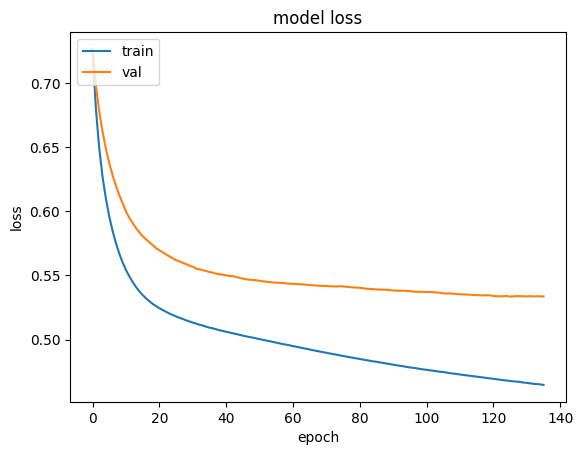

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Pokémon dataset: unbalanced classes

Pokémon are fictional creatures that are central to the Pokémon franchise.
Among them, Legendary Pokémon are a group of incredibly rare and often very powerful Pokémon, generally featured prominently in the legends and myths of the Pokémon world [[source]](https://bulbapedia.bulbagarden.net/wiki/Legendary_Pok%C3%A9mon).

The task that we will tackle in this exercise is simple: can we tell whether a Pokémon is legendary or not, by looking at its statistics (like attack, defense, HP, etc.)?

Let's start by getting the data and looking at it...

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import losses
from tensorflow import keras
import tensorflow as tf


url = 'https://raw.githubusercontent.com/lgreski/pokemonData/565a330aa57d1f60e1cab9d40320cf7473be566c/Pokemon.csv'
data = pd.read_csv(url)

data.head(10)

,Number,Name,Type1,Type2,Total,HP,Attack,Defense,SpecialAtk,SpecialDef,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,Venusaur Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
5,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
7,6,Charizard Mega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False
8,6,Charizard Mega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False
9,7,Squirtle,Water,NaN,314,44,48,65,50,64,43,1,False


We will train a neural network to predict the "Legendary" labels using 'HP', 'Attack', 'Defense', 'SpecialAtk', 'SpecialDef', and 'Speed' as features.

In [ ]:
# Extract features
X = data[['HP', 'Attack', 'Defense', 'SpecialAtk', 'SpecialDef', 'Speed']].values

# Extact targets
y = data['Legendary'].values.astype(np.float32)

Like we did before, we will need to standardize the data in order to have commensurable features.

In [ ]:
# Standardize data
X = (X - X.mean(0)) / X.std(0)
print(X)

[[-0.95374184 -0.94418213 -0.81199369 -0.25469934 -0.26483618 -0.79411224]
 [-0.36909757 -0.54629661 -0.36480047  0.19858774  0.27188033 -0.28159683]
 [ 0.41042813  0.06583496  0.27404698  0.80297053  0.98750235  0.40175705]
 ...
 [-0.33012128  1.5655573   4.36267065 -0.61732902  1.02328345 -1.88747845]
 [-0.64193156  1.44313098 -0.6842242   2.34414663  0.23609923  1.32428478]
 [ 0.7222384   0.98403231  0.018508    0.86340881  0.27188033  2.55432177]]




However, here we face a problem that we didn't have before: we have substantially less samples of one class w.r.t. the other. This means that our neural network is likely to ignore samples with $y=1$, because getting right the samples for which $y=0$ will lead to a lower error. 

Would you study for an exam question that was only asked once by the professor, in previous years? Or would you focus on the more common exercises that are more likely to be asked again? :)


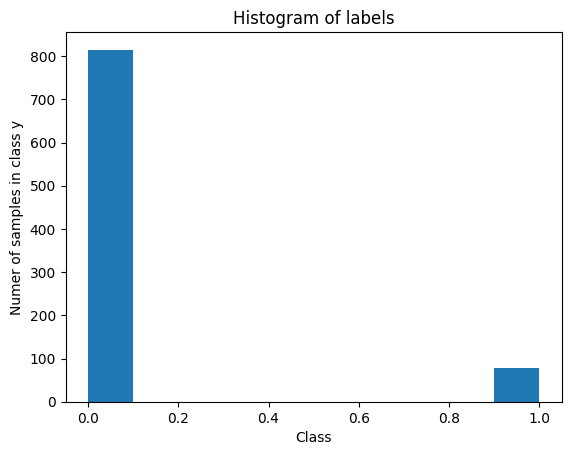

In [ ]:
# Plot histogram of labels
plt.hist(y)
plt.title("Histogram of labels")
plt.xlabel("Class")
plt.ylabel("Numer of samples in class y")
plt.show()

To deal with the __class unbalance__ we will use a simple trick, that will allow our model to learn better. 

The trick consists in __re-weighting__ the loss function, so that the error on rare samples will count more than the error on common samples:

$$
L_{\textrm{reweighted}}(y, f(X; W)) =
\begin{cases}
\lambda_0 L(y, f(X; W))\textrm{, if } y=0 \\
\lambda_1 L(y, f(X; W))\textrm{, if } y=1
\end{cases}
$$

Ideally, $\lambda_0$ and $\lambda_1$ should represent how rare the respective classes are in the dataset. 
A common way of computing the two values automatically is as: 

$$
\lambda_i = \frac{\textrm{\# samples in dataset}}{\textrm{\# classes}\cdot\textrm{\# samples of class } i}
$$

In Keras (and also in Scikit-learn) we call these values `class_weight`.

Let's see how to compute them...

In [ ]:
# Split train / test / validation data
np.random.seed(0)

X_train, X_not_train, y_train, y_not_train = train_test_split(X, y, train_size=0.8, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_not_train, y_not_train, test_size=0.5, stratify=y_not_train)

# Compute class weights
n_pokemons = X_train.shape[0]
n_legendaries = y_train.sum()
n_classes = 2
class_weights = {0: n_pokemons / (n_classes * (n_pokemons - n_legendaries)),
                 1: n_pokemons / (n_classes * n_legendaries)}

print('Training data: {} legendaries out of {} pokemons'.format(int(n_legendaries), int(n_pokemons)))
print('Training data: class weights {}'.format(class_weights))

Training data: 63 legendaries out of 715 pokemons
Training data: class weights {0: 0.5483128834355828, 1: 5.674603174603175}


In order to train a neural network in Keras using class weights, we only need to apport some minor modifications to the previous model:

In [ ]:
keras.utils.set_random_seed(0)

network = Sequential()
network.add(Dense(32, activation='relu', input_shape=X.shape[1:]))
network.add(Dense(1, activation='sigmoid'))

network.compile('sgd', 'binary_crossentropy', weighted_metrics=['acc'])

network.fit(X, y, epochs=100, validation_data=(X_val, y_val))

# network.fit(X, y, epochs=100, validation_data=(X_val, y_val), class_weight=class_weights)

Epoch 1/100
28/28 [==============================] - 1s 15ms/step - loss: 0.4975 - acc: 0.8535 - val_loss: 0.4704 - val_acc: 0.9101
Epoch 2/100
28/28 [==============================] - 0s 5ms/step - loss: 0.4465 - acc: 0.8982 - val_loss: 0.4305 - val_acc: 0.9101
Epoch 3/100
28/28 [==============================] - 0s 5ms/step - loss: 0.4089 - acc: 0.9094 - val_loss: 0.4010 - val_acc: 0.9101
Epoch 4/100
28/28 [==============================] - 0s 5ms/step - loss: 0.3800 - acc: 0.9105 - val_loss: 0.3782 - val_acc: 0.9101
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 0.3571 - acc: 0.9116 - val_loss: 0.3600 - val_acc: 0.9101
Epoch 6/100
28/28 [==============================] - 0s 6ms/step - loss: 0.3385 - acc: 0.9116 - val_loss: 0.3452 - val_acc: 0.9101
Epoch 7/100
28/28 [==============================] - 0s 8ms/step - loss: 0.3229 - acc: 0.9116 - val_loss: 0.3329 - val_acc: 0.9101
Epoch 8/100
28/28 [==============================] - 0s 7ms/step - loss: 0.3098 - 

Finally, let's analyze the __test__ performance of our model:

Loss: 0.1152 - Accuracy: 0.94
3/3 [==============================] - 0s 3ms/step


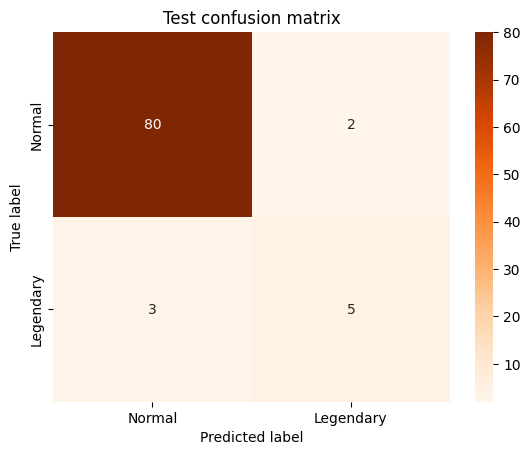

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes=["Normal", "Legendary"]):
    cm = confusion_matrix(y_true, y_pred)
    fig = sns.heatmap(cm, annot=True, xticklabels=classes,
                      yticklabels=classes, cmap=plt.cm.Oranges)
    fig.set_xlabel("Predicted label")
    fig.set_ylabel("True label")
    fig.set_title("Test confusion matrix")


test_results = network.evaluate(X_test, y_test, verbose=False)
print('Loss: {:.4f} - Accuracy: {:.2f}'.format(*test_results))

y_pred = network.predict(X_test)
y_pred = np.round(y_pred)

plot_confusion_matrix(y_test, y_pred)
